# Enzyme titration with naproxen and tolmetin data analysis

In [2]:
library(ggplot2)
library(nlshelper)

Loading required package: nlme
Loading required package: broom
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: mgcv
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.
Loading required package: magicaxis


In [3]:
ggplotRegression <- function (fit) {

require(ggplot2)

ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1])) + 
  geom_point() +
  stat_smooth(method = "lm", col = "red") +
  labs(title = paste("Adj R2 = ",signif(summary(fit)$adj.r.squared, 5),
                     "Intercept =",signif(fit$coef[[1]],5 ),
                     " Slope =",signif(fit$coef[[2]], 5),
                     " P =",signif(summary(fit)$coef[2,4], 5)))
}

In [4]:
allPlotter <- function (dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp,
                        end_double_exp, STUBBORN = FALSE) {
    require(ggplot2)
        #whole raw reaction plot
    whole_PLOT <- ggplot(dot_data, aes(V1,V2)) + geom_point() +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 30)) 

#linear approximation of non-enzymatic part of reaction
    
    non_enz_fit_part <- subset(dot_data, V1 > linear_start & V1 < enzyme_start) #choose exact time of boundaries
    nEnz_start = non_enz_fit_part$V1[which(abs(non_enz_fit_part$V1 - linear_start)
                            ==min(abs(non_enz_fit_part$V1 - linear_start)))]
    nEnz_end = non_enz_fit_part$V1[which(abs(non_enz_fit_part$V1 - enzyme_start)
                            ==min(abs(non_enz_fit_part$V1 - enzyme_start)))]
    
    fit <- lm(V2~V1, data = non_enz_fit_part)
    non_enz_regression_PLOT <- ggplotRegression(fit)
    slope = fit$coefficients[[2]]

#whole plot with non-enzymatic reaction substracted from it
    dot_data_norm <- dot_data
    dot_data_norm$V2 <- dot_data$V2 - dot_data$V1 * slope
    whole_normalized_PLOT <- ggplot(dot_data_norm, aes(V1,V2)) + geom_point() +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 30))

    
    #Find exact time of enzyme reaction start
    true_enz_start = enzyme_start + start_linear
    enz_part <- subset(dot_data_norm, V1 > (true_enz_start))
    
    Enz_start =  enz_part$V1[which(abs(enz_part$V1 - true_enz_start)
                            ==min(abs(enz_part$V1 - true_enz_start)))]
    
#enzymatic reaction part of the experiment (normalized and inverted)


    react_start_current = dot_data_norm$V2[which(abs(dot_data_norm$V1-enzyme_start)
                            ==min(abs(dot_data_norm$V1-enzyme_start)))] #find index of the element closest to enzyme_start
    dot_data_exp <- subset(dot_data_norm, V1 > enzyme_start)
    dot_data_exp$V2 <- (react_start_current - dot_data_exp$V2) * 270 / max(dot_data$V2)
    dot_data_exp$V1 <- dot_data_exp$V1 - enzyme_start
    enzymatic_react_PLOT <- ggplot(dot_data_exp, aes(V1,V2)) + geom_point() +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 30))
    
#Enzymatic part of the data output============================================
    Enz_data_part <- subset(dot_data_exp, V1 > start_linear)
    
    Enz_data_part$V1 <- Enz_data_part$V1 - Enz_data_part$V1[[1]] #make data start at 0,0
    Enz_data_part$V2 <- Enz_data_part$V2 - Enz_data_part$V2[[1]] #make data start at 0,0

#=============================================================================
     dot_data_exp_start <- subset(dot_data_exp, V1 > start_linear & V1 < end_exp)

     dot_data_exp_start$V1 <- dot_data_exp_start$V1 - dot_data_exp_start$V1[[1]] #make data start at 0,0
     dot_data_exp_start$V2 <- dot_data_exp_start$V2 - dot_data_exp_start$V2[[1]] #make data start at 0,0
    dot_data_exp_start_OUT <- dot_data_exp_start
    
    #Linear approximation of enzymatic reaction rate
    fit <- lm(V2~V1, data = dot_data_exp_start, subset = ( V1 < end_linear))
    approx_linear_PLOT <- ggplotRegression(fit)
    approx_linear_slope = fit$coefficients[[2]]
    
    if (STUBBORN == TRUE) {
        #Exponential approximation of enzymatic reaction rate
        
        fit_exp <- nls(V2 ~ P_inf * (1-exp(-V1/tau)),
                        data = dot_data_exp_start, start = c(P_inf = 25, tau = 11), 
                        algorithm ="port", control = list(maxiter = 5000, minFactor=1/2000, warnOnly=T))
        output_exp <- coef(fit_exp)
        output_exp["v0"] <- output_exp["P_inf"]/output_exp["tau"]

        exp_coefs <- list(coef(fit_exp))

        approx_exp_PLOT <- ggplot(dot_data_exp_start, aes(x = V1,y = V2)) + geom_point() +
        stat_smooth(method = "nls",
                    formula = y ~ P_inf * (1-exp(-x/tau)),
                    method.args = exp_coefs, se = F, colour = "red", na.rm=TRUE) +
        ggtitle(paste(" V0 = ", round(output_exp["v0"], digits = 2)))


        #Double exponent approximation of enzymatic reaction rate
        dot_data_exp_start <- subset(dot_data_exp, V1 > start_exp & V1 < end_double_exp)

        dot_data_exp_start$V1 <- dot_data_exp_start$V1 - dot_data_exp_start$V1[[1]] #make data start at 0,0
        dot_data_exp_start$V2 <- dot_data_exp_start$V2 - dot_data_exp_start$V2[[1]] #make data start at 0,0
        message("SUBBORN first points before double exp approx",
                dot_data_exp_start$V1[[1]],
               dot_data_exp_start$V2[[1]])
        fit_exp <- nls(
            V2 ~ y0 + A1 * (1 - exp( -V1/t1)) + A2 * (1 - exp( -V1/t2)),
            data = dot_data_exp_start, start = c(y0 = 0, A1 = 10, t1 = 5, A2 = 20, t2 = 47), 
            algorithm ="port", control = list(maxiter = 5000, minFactor=1/2000, warnOnly=T))
        

        output_doub_exp <- coef(fit_exp)
        output_doub_exp["v0"] <- output_doub_exp["A1"]/output_doub_exp["t1"] + output_doub_exp["A2"]/output_doub_exp["t2"]

        exp_coefs <- list(coef(fit_exp))

        dot_data_exp_start$pred_nls <- predict(fit_exp)
        approx_double_exp_PLOT <- ggplot(dot_data_exp_start, aes(x = V1,y = V2)) + geom_point() +
            geom_line(aes(x = V1,y = pred_nls), colour = "red", size=1.5) +
            ggtitle(paste(" V0 = ", round(output_doub_exp["v0"], digits = 2)))    
        
        
        exponentials_out <- list(approx_exp_PLOT = approx_exp_PLOT,
                approx_double_exp_PLOT = approx_double_exp_PLOT,
                output_exp = output_exp,
                output_doub_exp = output_doub_exp)
    } else {
    
        exponentials_out <- tryCatch(
            {
                #Exponential approximation of enzymatic reaction rate

                
                fit_exp <- nls(V2 ~ P_inf * (1-exp(-V1/tau)),
                                data = dot_data_exp_start, start = c(P_inf = 25, tau = 11), 
                                control = list(maxiter = 50000, minFactor=1/2000))
                output_exp <- coef(fit_exp)
                output_exp["v0"] <- output_exp["P_inf"]/output_exp["tau"]

                exp_coefs <- list(coef(fit_exp))

                approx_exp_PLOT <- ggplot(dot_data_exp_start, aes(x = V1,y = V2)) + geom_point() +
                stat_smooth(method = "nls",
                            formula = y ~ P_inf * (1-exp(-x/tau)),
                            method.args = exp_coefs, se = F, colour = "red", na.rm=TRUE) +
                ggtitle(paste(" V0 = ", round(output_exp["v0"], digits = 2)))


                #Double exponent approximation of enzymatic reaction rate
                dot_data_exp_start <- subset(dot_data_exp, V1 > start_exp & V1 < end_double_exp)

                dot_data_exp_start$V1 <- dot_data_exp_start$V1 - start_linear #make data start at 0,0
                dot_data_exp_start$V2 <- dot_data_exp_start$V2 - dot_data_exp_start$V2[[1]] #make data start at 0,0
                
                fit_exp <- nls(
                    V2 ~ y0 + A1 * (1 - exp( -V1/t1)) + A2 * (1 - exp( -V1/t2)),
                    data = dot_data_exp_start, start = c(y0 = 0, A1 = 10, t1 = 5, A2 = 20, t2 = 47), 
                    control = list(maxiter = 50000, minFactor=1/2000))
                

                output_doub_exp <- coef(fit_exp)
                output_doub_exp["v0"] <- output_doub_exp["A1"]/output_doub_exp["t1"] + output_doub_exp["A2"]/output_doub_exp["t2"]

                exp_coefs <- list(coef(fit_exp))
                dot_data_exp_start$pred_nls <- predict(fit_exp)


                approx_double_exp_PLOT <- ggplot(dot_data_exp_start, aes(x = V1,y = V2)) + geom_point() +
                    stat_smooth(method = "nls",
                                formula = y ~ y0 + A1 * (1-exp(-x/t1)) + A2 * (1-exp(-x/t2)),
                                method.args = exp_coefs, se = F, colour = "red") +
                ggtitle(paste(" V0 = ", round(output_doub_exp["v0"], digits = 2)))    
                
                
                list(approx_exp_PLOT = approx_exp_PLOT,
                        approx_double_exp_PLOT = approx_double_exp_PLOT,
                        output_exp = output_exp,
                        output_doub_exp = output_doub_exp)
        },
        error=function(cond) {
            message("Error occured. Probably should try a different RANGE values.")
        #         message("Here's the original error message:")
        #         message(cond)
            return(NULL)
        },
        finally={

        }
        )
    }

    return(list(whole_PLOT = whole_PLOT,
                non_enz_regression_PLOT = non_enz_regression_PLOT,
                whole_normalized_PLOT = whole_normalized_PLOT,
                enzymatic_react_PLOT = enzymatic_react_PLOT,
                approx_linear_PLOT = approx_linear_PLOT,
                exponentials = exponentials_out,
               approx_linear_slope = approx_linear_slope,
               nEnz_start = nEnz_start,
               nEnz_end = nEnz_end,
               Enz_start = Enz_start,
               Enz_data_part = Enz_data_part,
               dot_data_exp_start_OUT = dot_data_exp_start_OUT))
}

In [5]:
final_table <- data.frame(nEnz_start = double(),
                          nEnz_end = double(),
                          Enz_start = double(),
                          lin_v0 = double(),
                          P_inf = double(),
                          tau = double(),
                          exp_v0 = double(),
                          A1 = double(),
                          t1 = double(),
                          A2 = double(),
                          t2 = double(),
                          doub_exp_v0 = double())

In [6]:
var_names <- c("01-0SE-FCii1mM_hem2uM_AA100uM1ul_E10ul___Y",
"02-0S(0E)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l0nM___Y",
"03-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l600nM___Y",
"04-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l1200nM___Y",
"05-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l1500nM___Y",
"06-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l1800nM___Y",
"07-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l2100nM___Y",
"08-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l2400nM___Y",
"09-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l3000nM___Y",
"10-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l5000nM___Y",
"11-IS(IE)-FCii1mM_hem2uM_Tol1200nM_AA100uM1ul_IE11ulT0l1200nM___Y",
"12-IS(IE)-FCii1mM_hem2uM_Tol2400nM_AA100uM1ul_IE11ulT0l2400nM___Y",
"13-IS(0E)-FCii1mM_hem2uM_Tol3000nM_AA100uM1ul_IE11ulT0l0nM___Y",
"14-0S(0E)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l0nM___Y",
"15-0S(0E)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr0nM___Y",
"16-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr600nM___Y",
"17-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr1200nM___Y",
"18-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr1500nM___Y",
"19-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr1800nM___Y",
"20-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr2100nM___Y",
"21-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr3000nM___Y",
"22-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr5000nM___Y")

CURVE_END = 3313
ID <- c(1:CURVE_END)
enz_curves <- data.frame(ID)

In [7]:
head(enz_curves)

ID
1 1 
2 2 
3 3 
4 4 
5 5 
6 6

In [8]:
final_table

nEnz_start nEnz_end Enz_start lin_v0 P_inf tau exp_v0 A1 t1 A2 t2
     doub_exp_v0

## 1 experimental point (01-0SE-FCii1mM_hem2uM_AA100uM1ul_E10ul)

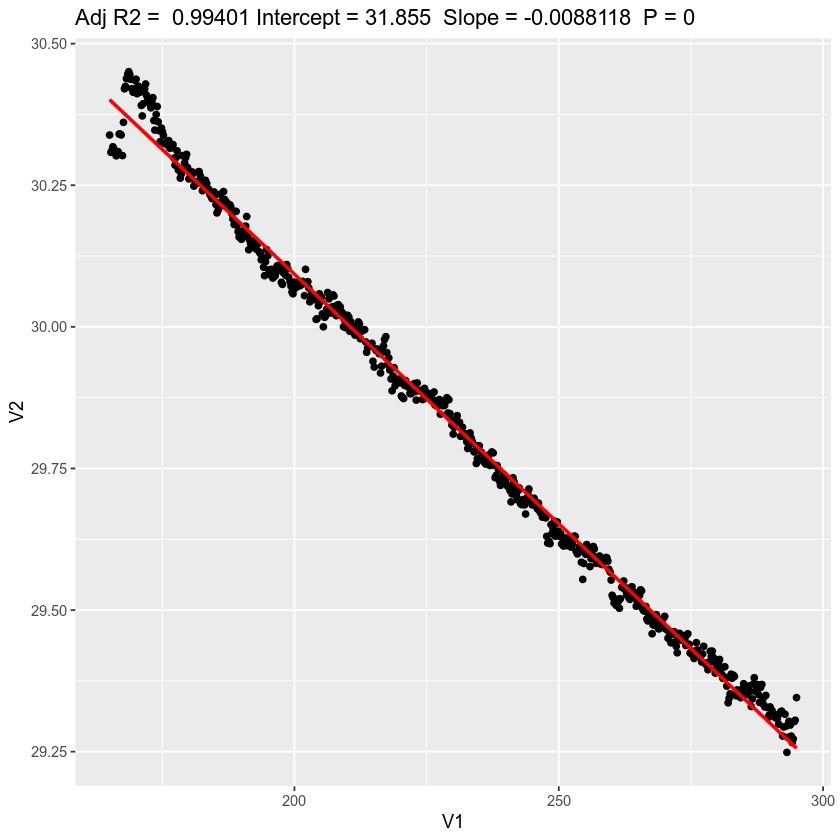

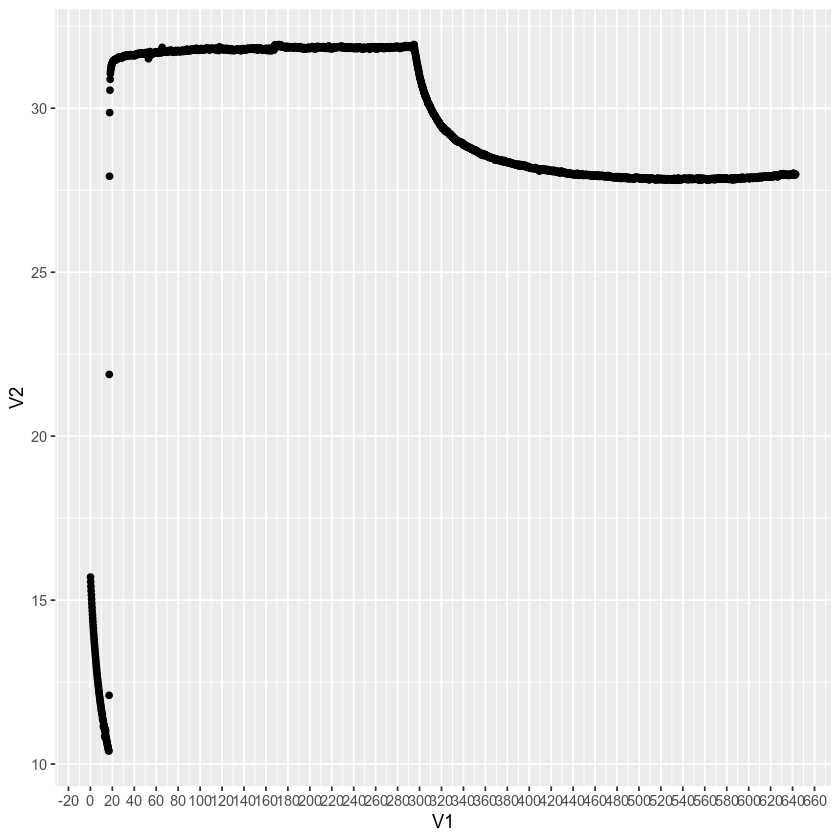

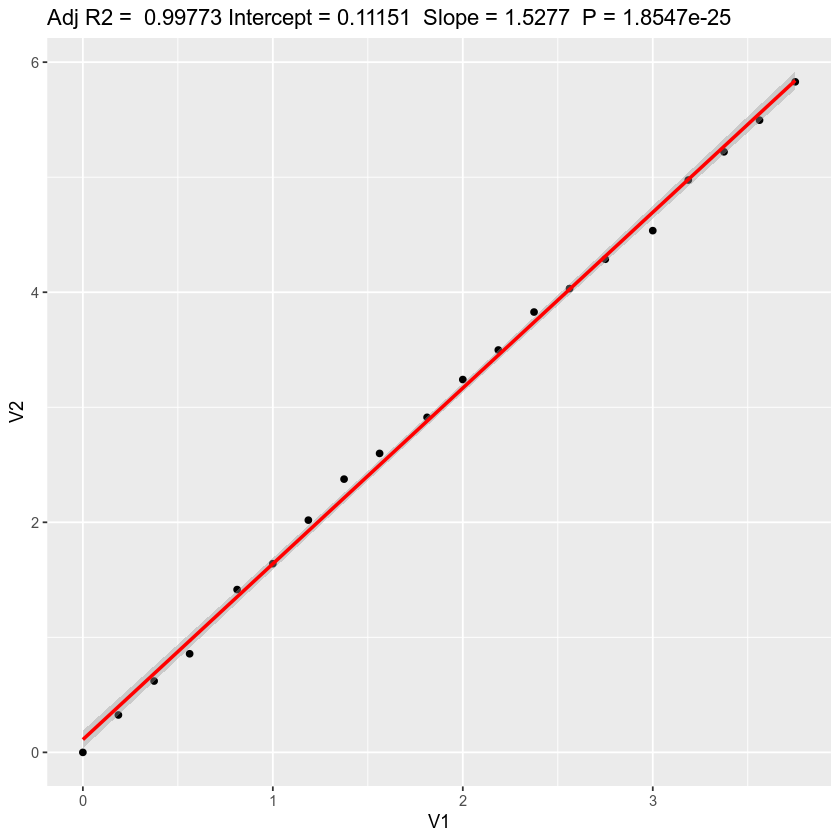

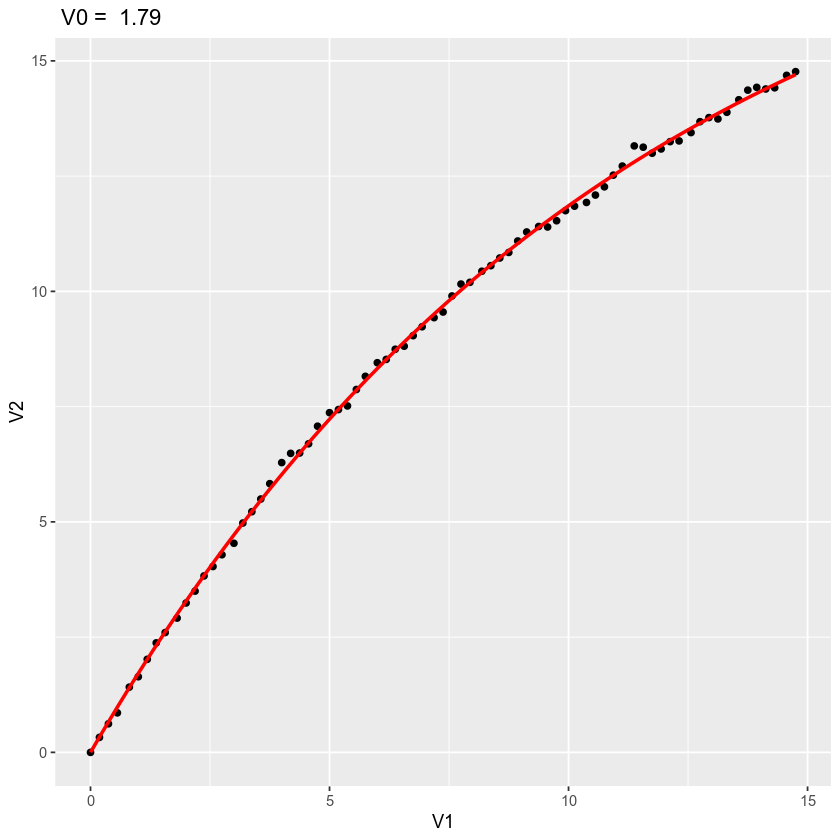

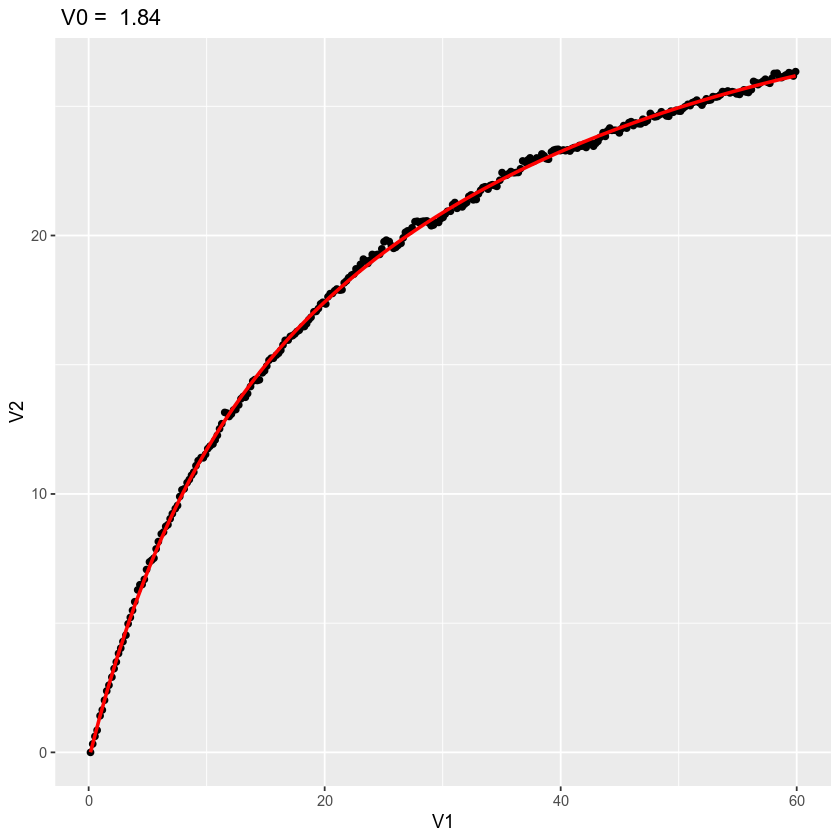

In [21]:
dot_data <- read.table("data/1.DAT", dec = ",")

# =========================== RANGES ===================================
#The whole graph
linear_start = 165
enzyme_start = 295
end_enzyme = 520

#Approximations
start_linear = 1
end_linear = 4
start_exp = start_linear
end_exp = 16
end_double_exp = 61
# ======================================================================
INDEX = 1

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 2 experimental point (02-0S(0E)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l0nM)

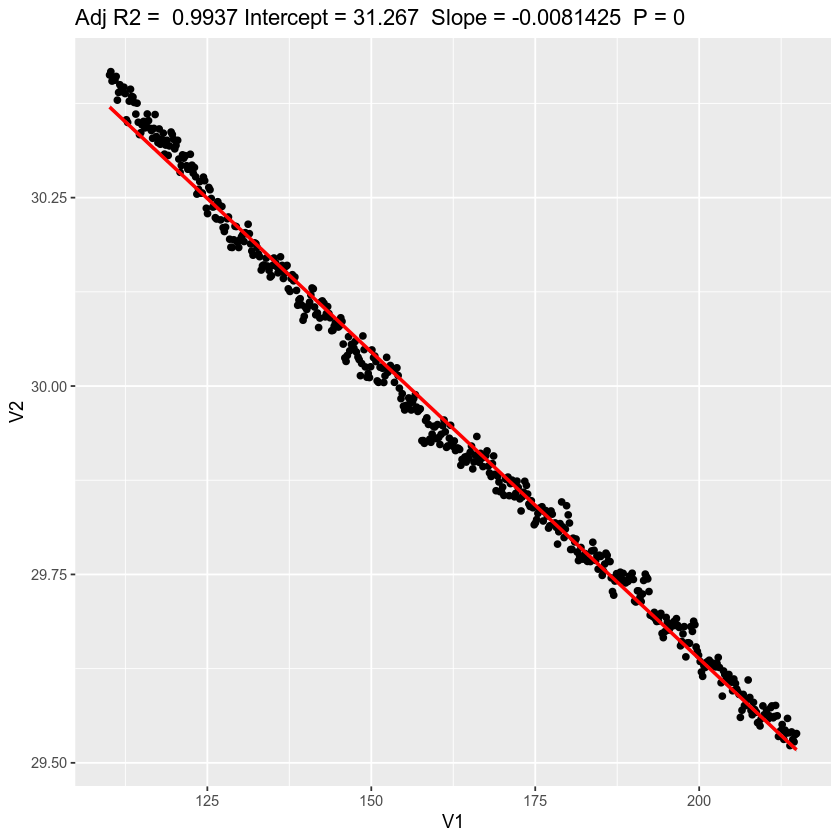

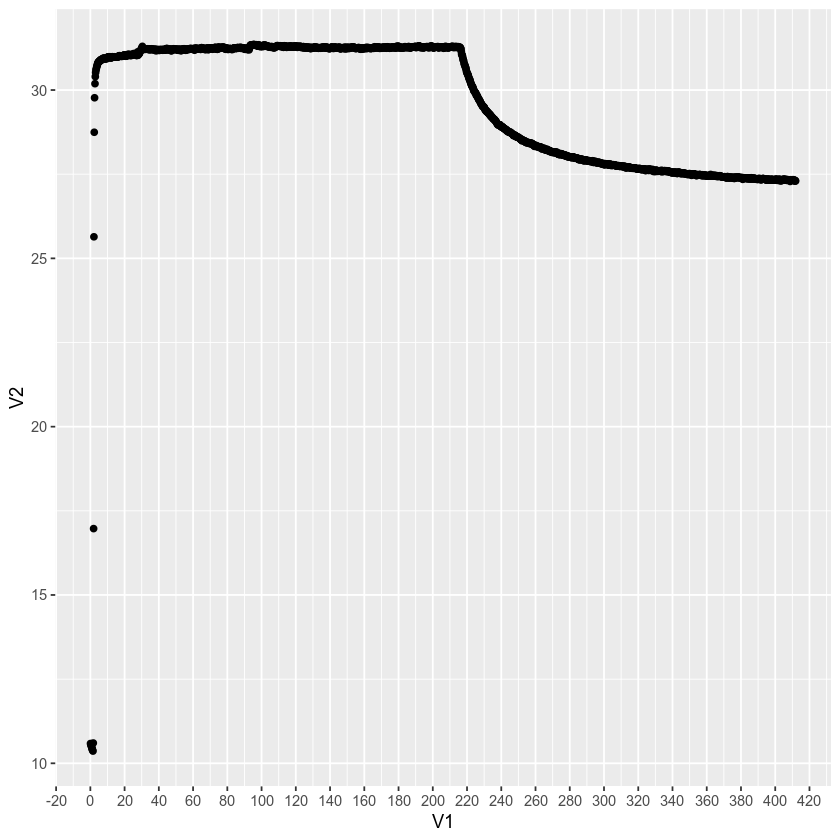

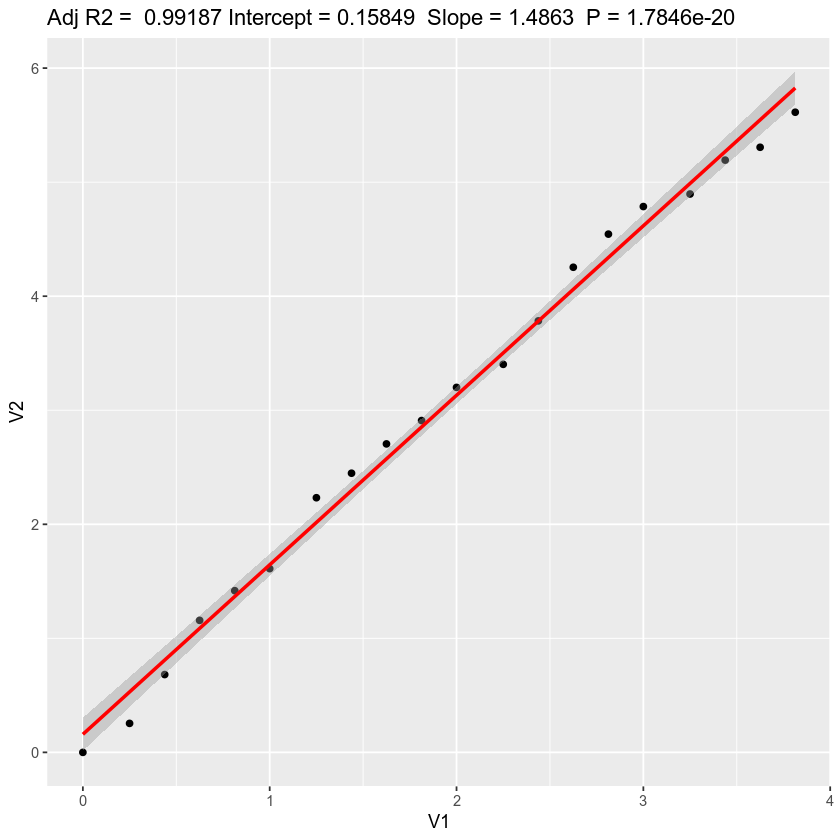

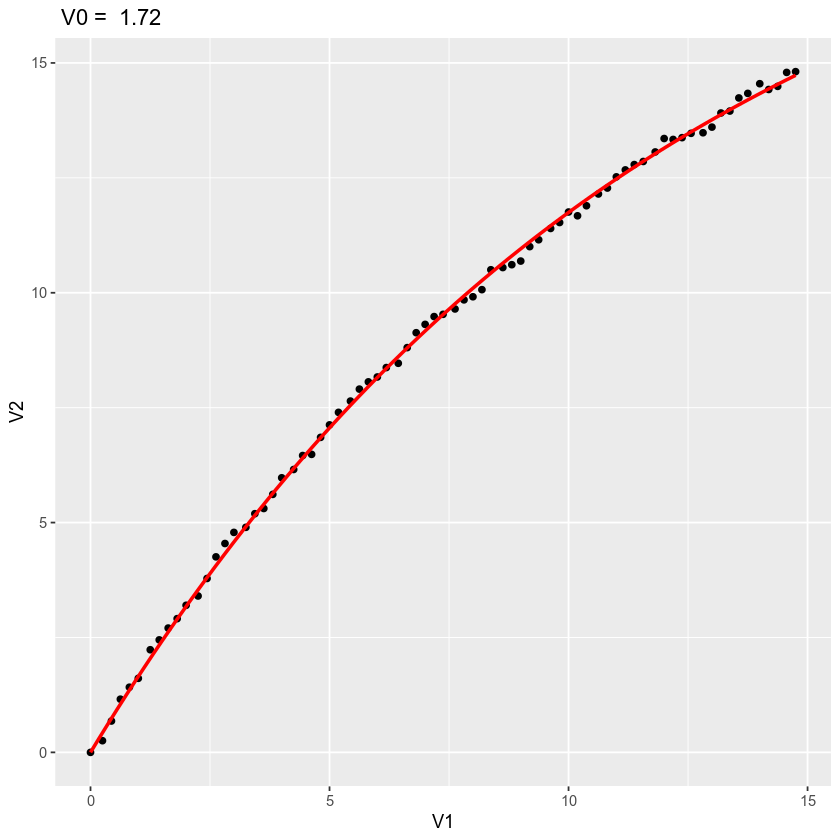

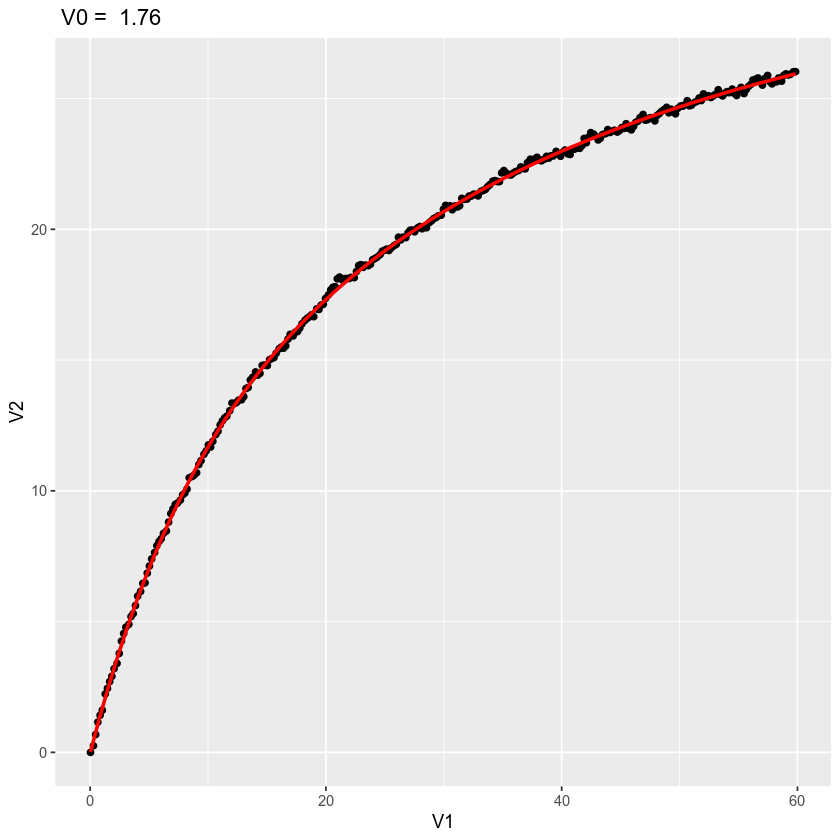

In [22]:
dot_data <- read.table("data/2.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 110
enzyme_start = 215
end_enzyme = 520

#Approximations
start_linear = 2
end_linear = 4
start_exp = start_linear
end_exp = 17
end_double_exp = 62
# ======================================================================
INDEX = 2

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 3 experimental point (03-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l600nM)

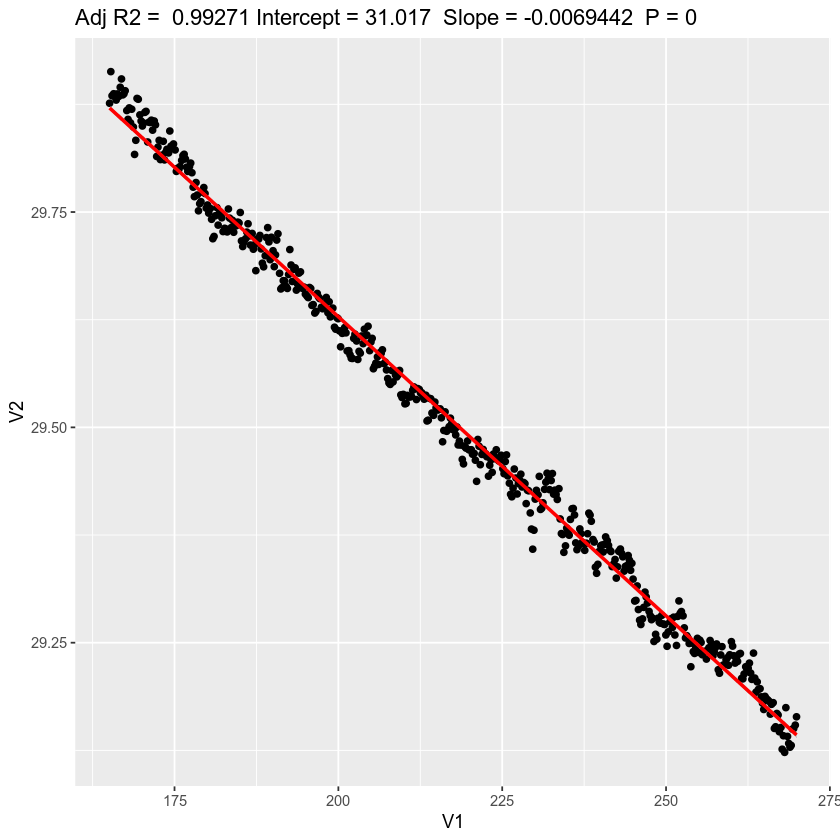

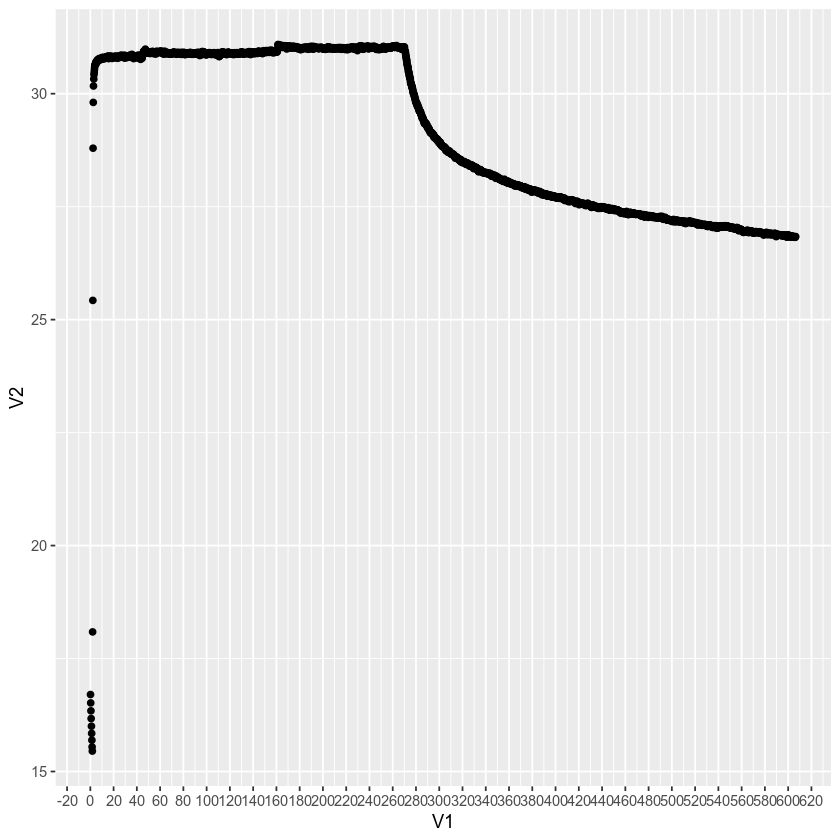

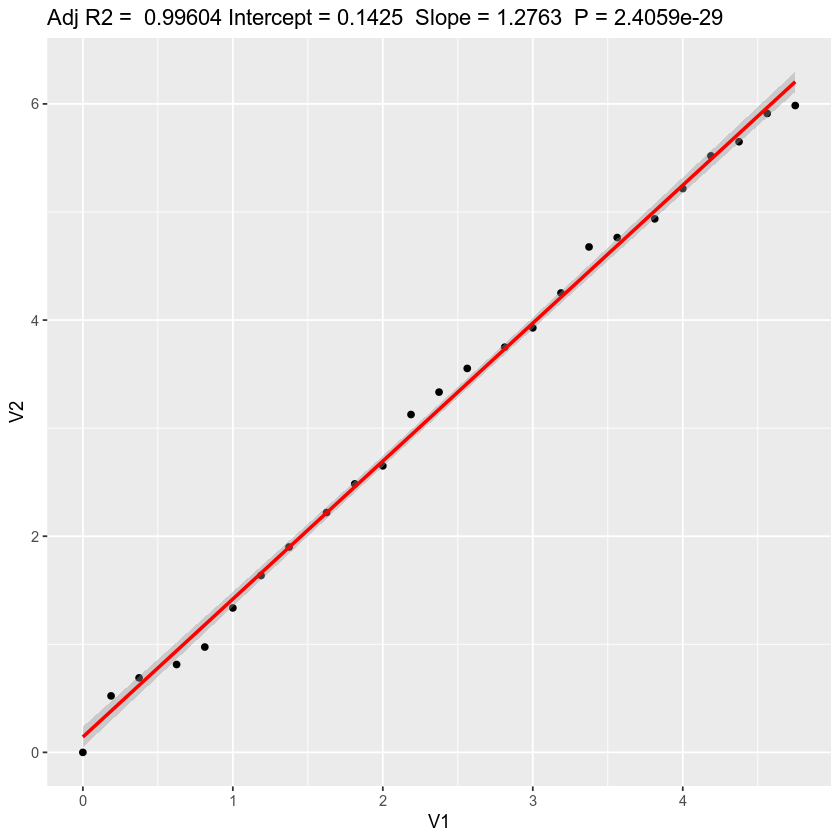

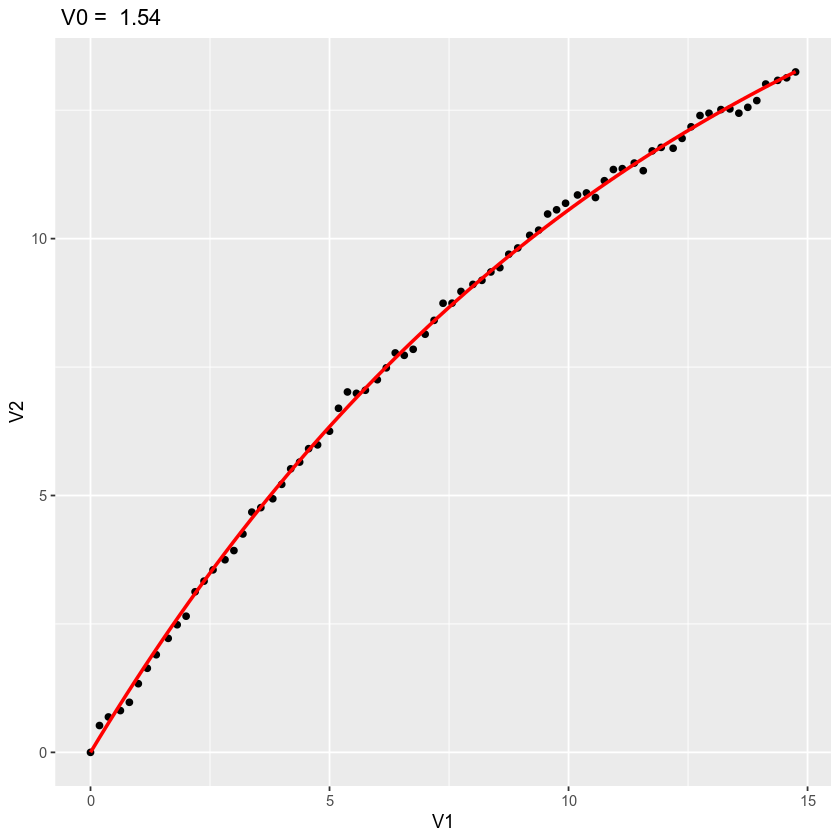

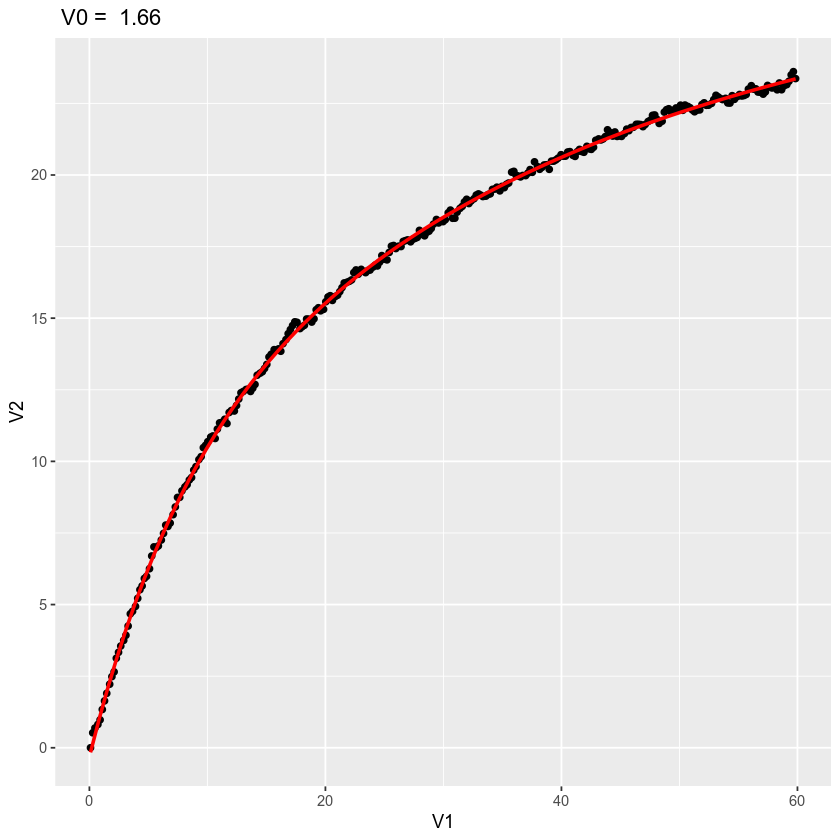

In [23]:
dot_data <- read.table("data/3.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 165
enzyme_start = 270
end_enzyme = 520

#Approximations
start_linear = 0
end_linear = 5
start_exp = start_linear
end_exp = 15
end_double_exp = 60
# ======================================================================
INDEX = 3

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 4 experimental point (04-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l1200nM)

SUBBORN first points before double exp approx00
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: singular convergence (7)”

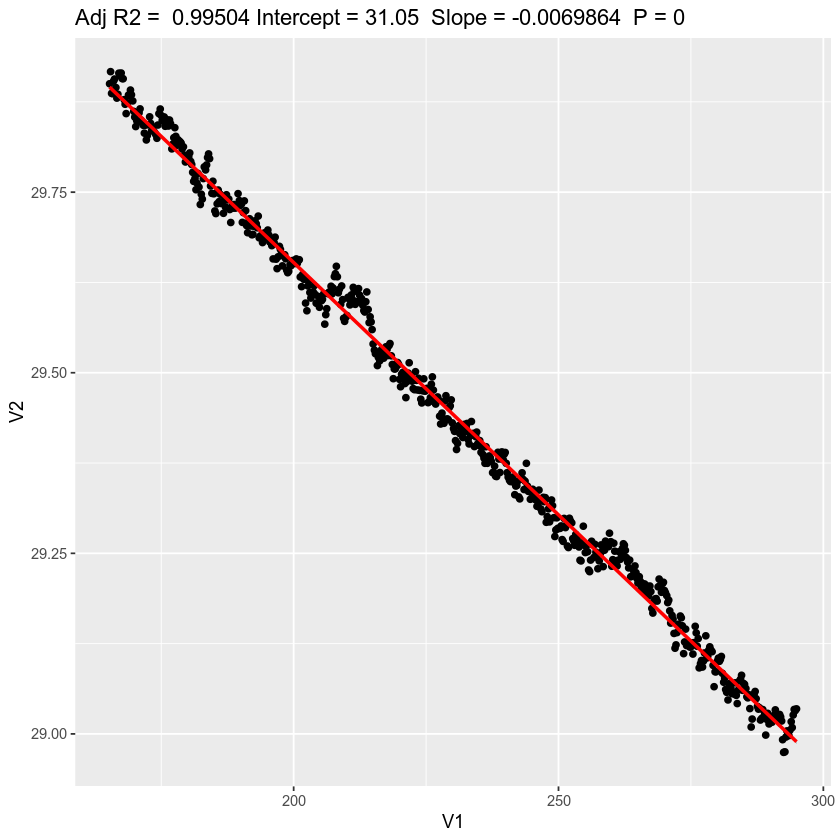

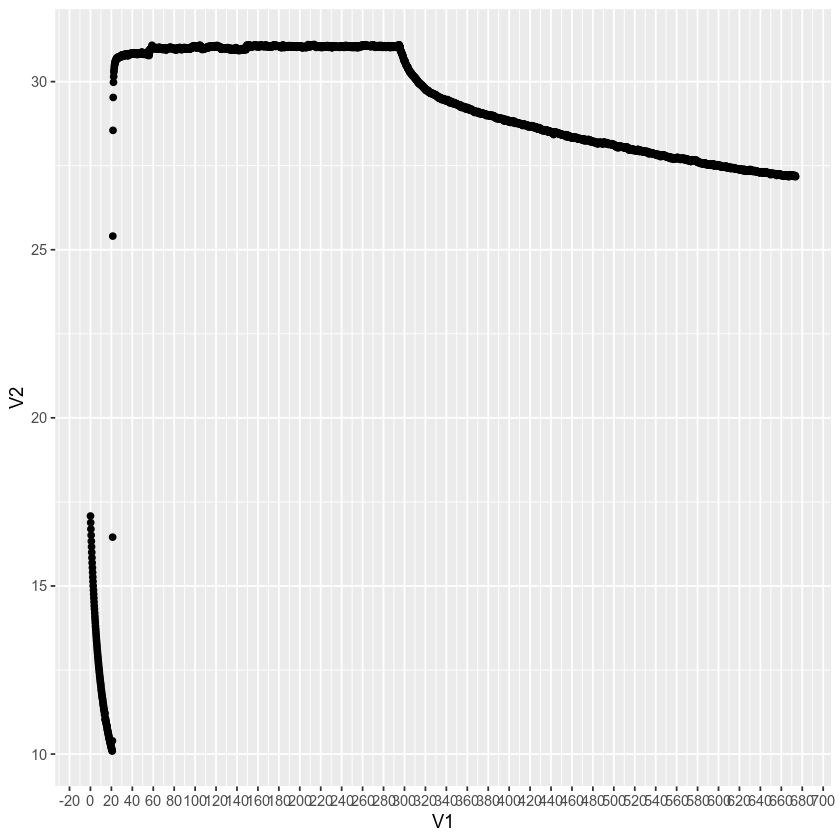

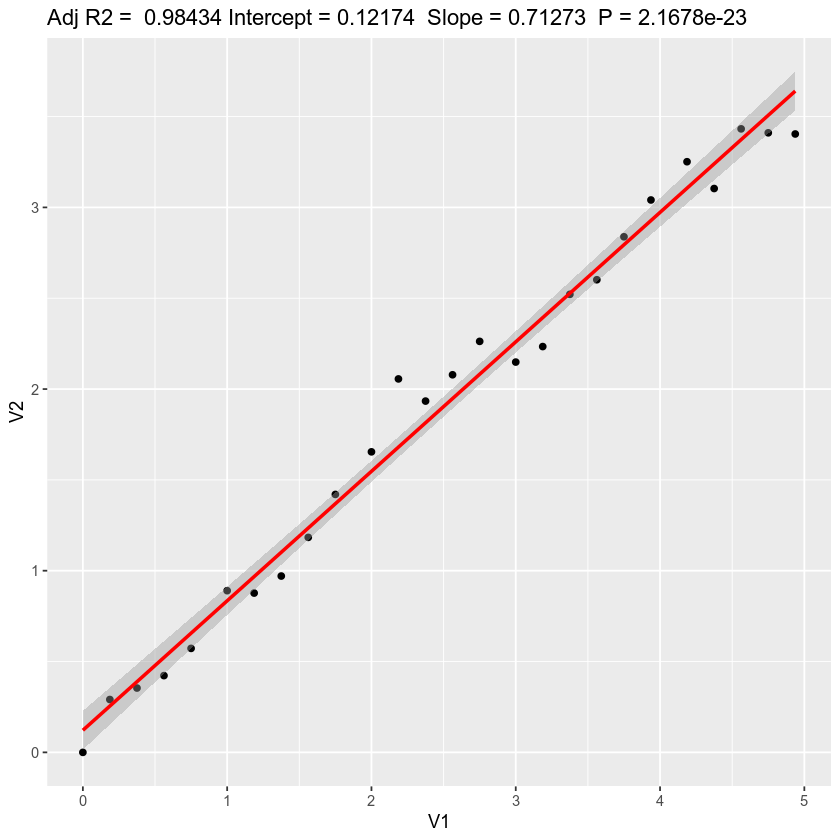

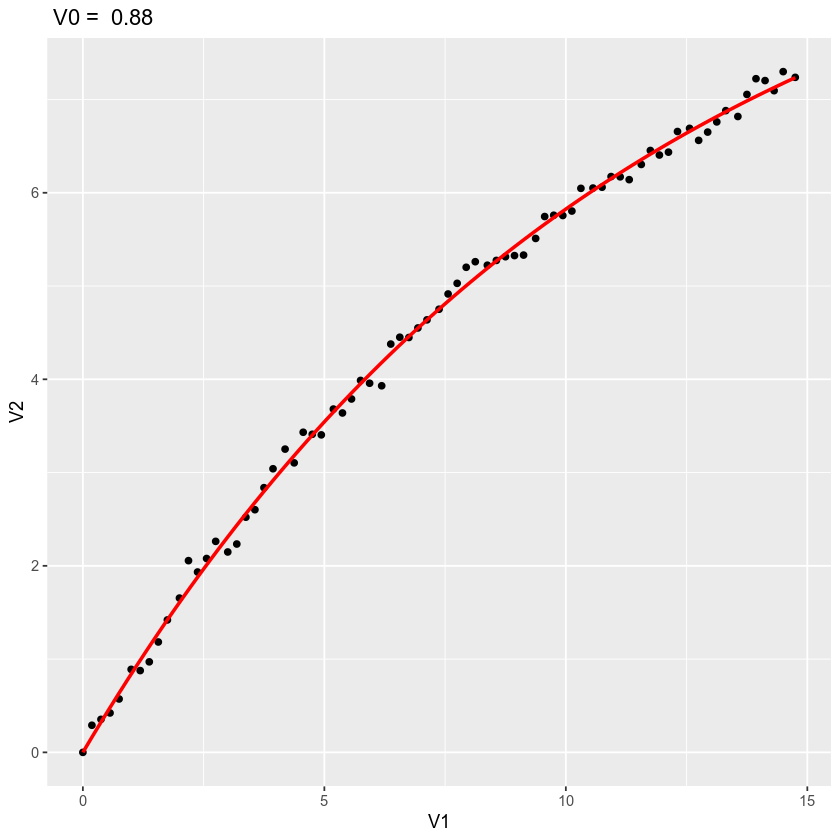

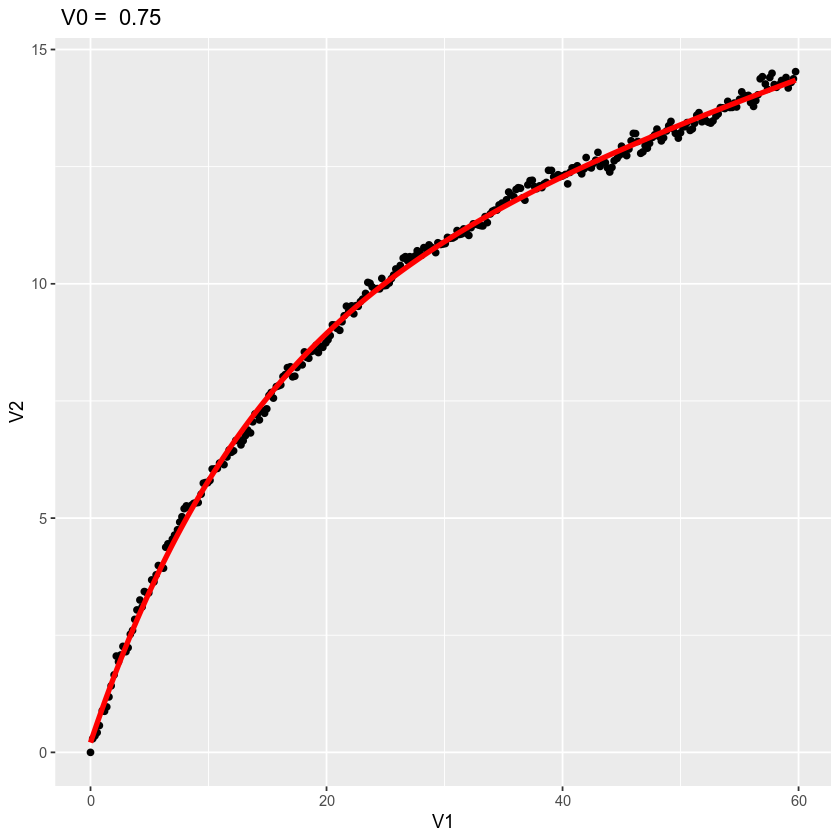

In [24]:
dot_data <- read.table("data/4.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 165
enzyme_start = 295
end_enzyme = 520

#Approximations
start_linear = 2
end_linear = 5
start_exp = start_linear
end_exp = 17
end_double_exp = 62

STUBBORN = TRUE
# ======================================================================
INDEX = 4

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp, STUBBORN)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

Poor convergence archieved for double exponent approximation since data is too close to a straight line. 
Using parameters from not converged approximation with least square distance from data.

## 5 experimental point (05-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l1500nM)

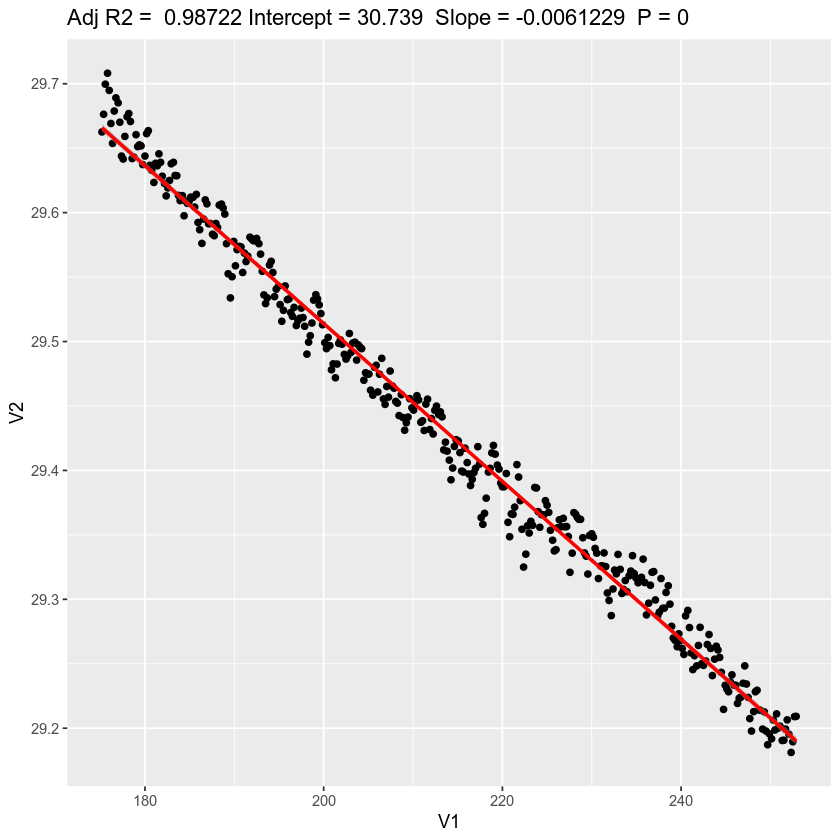

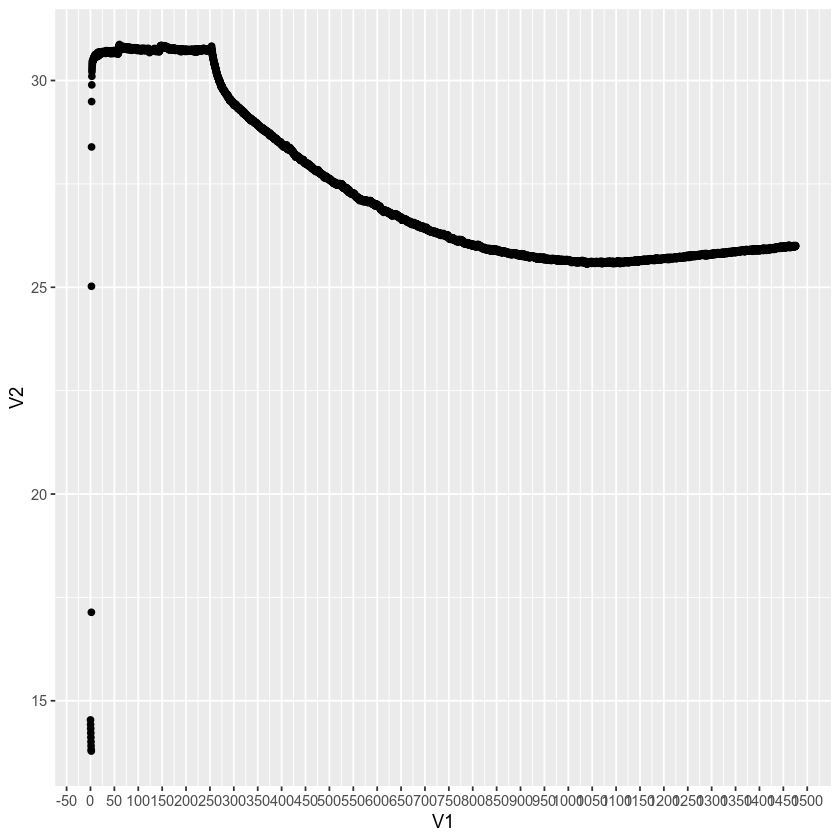

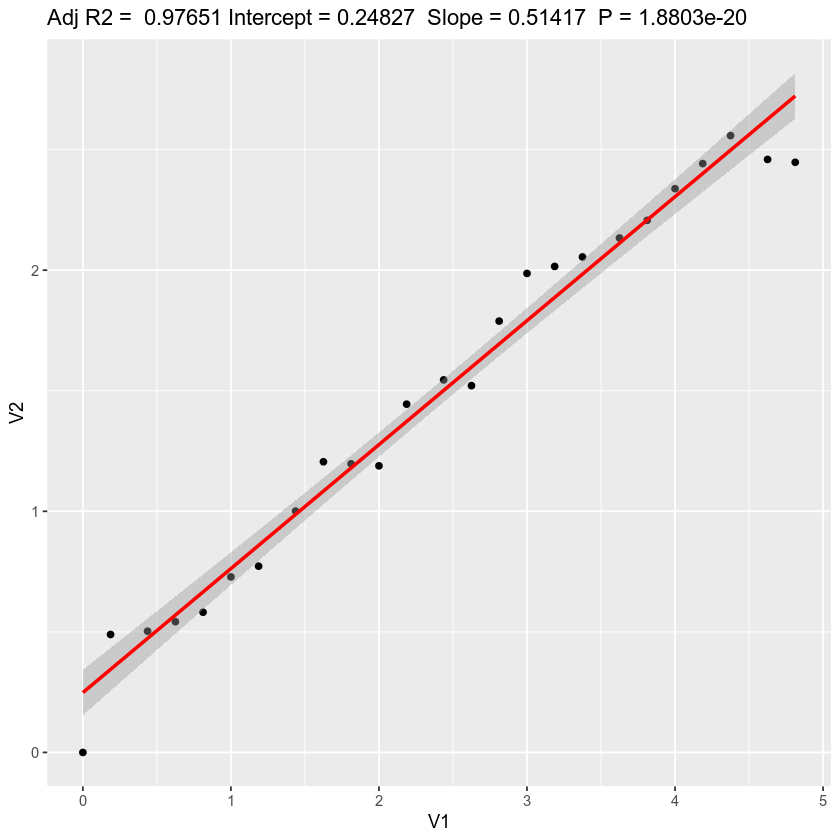

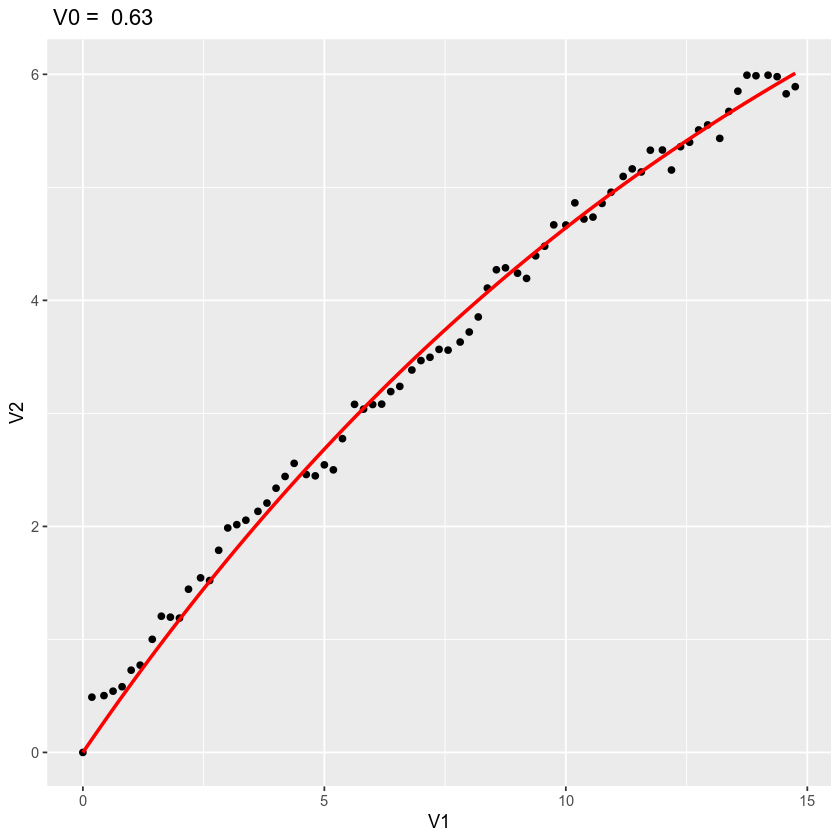

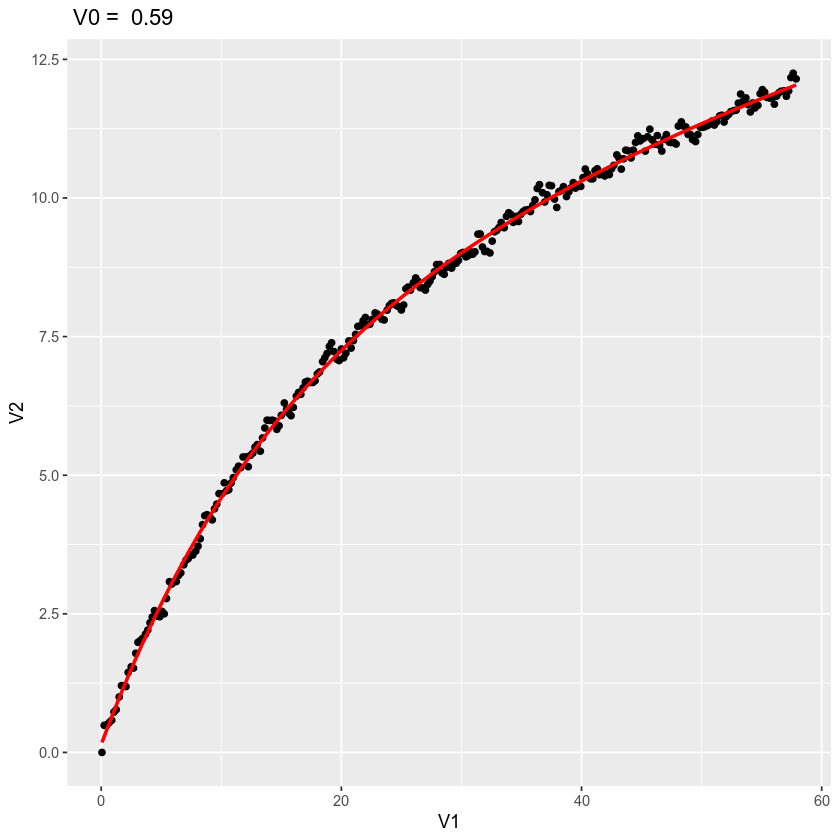

In [9]:
dot_data <- read.table("data/5.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 175
enzyme_start = 253
end_enzyme = 520

#Approximations
start_linear = 2
end_linear = 5
start_exp = start_linear
end_exp = 17
end_double_exp = 60
# ======================================================================
INDEX = 5

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 6 experimental point (06-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l1800nM)

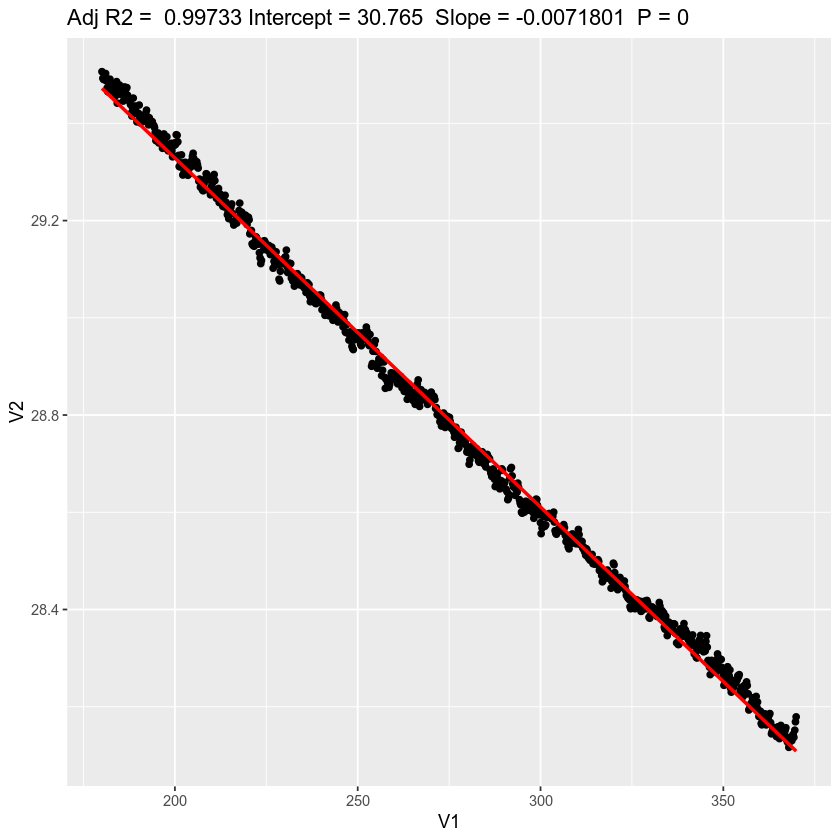

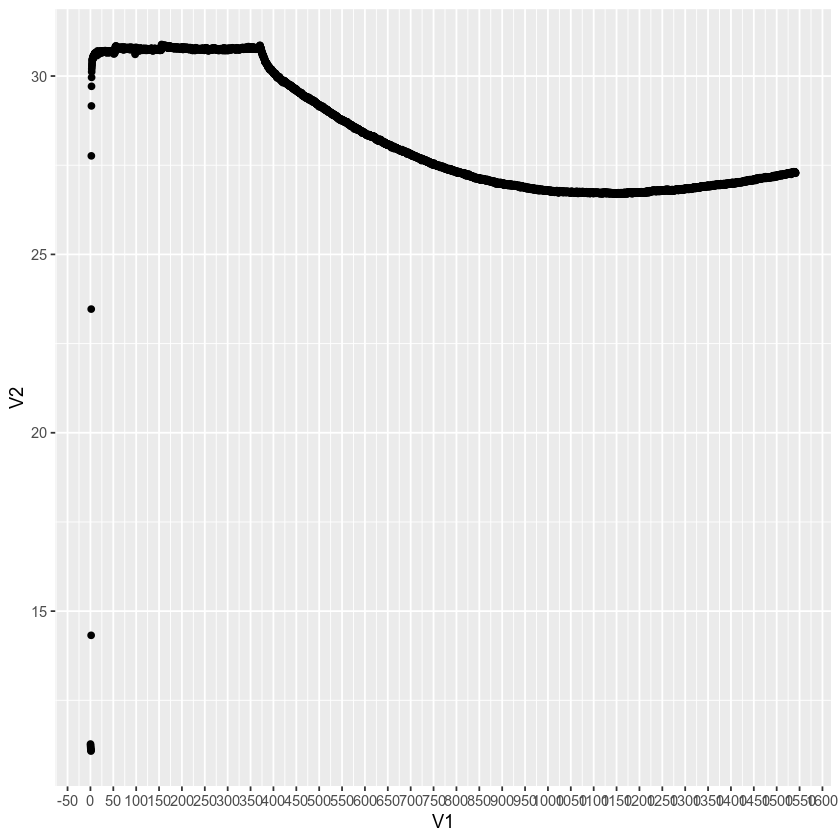

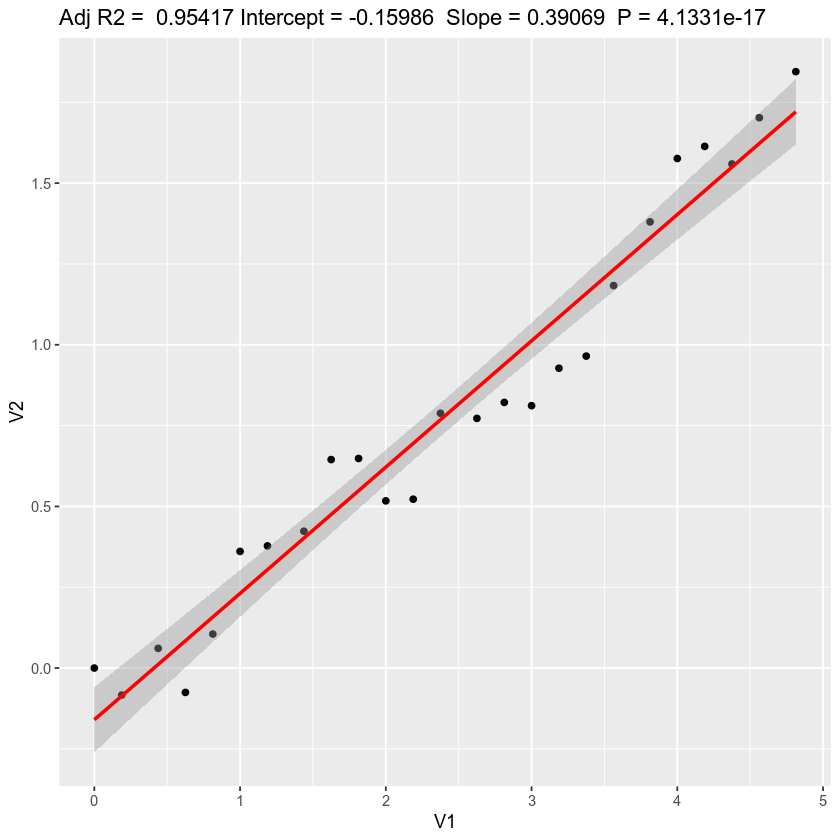

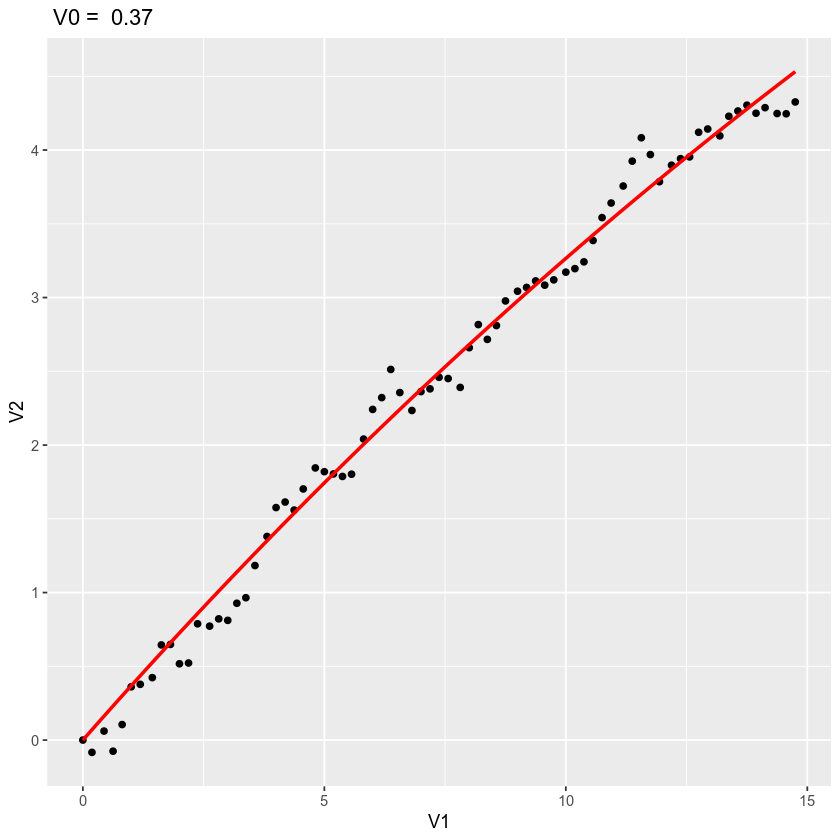

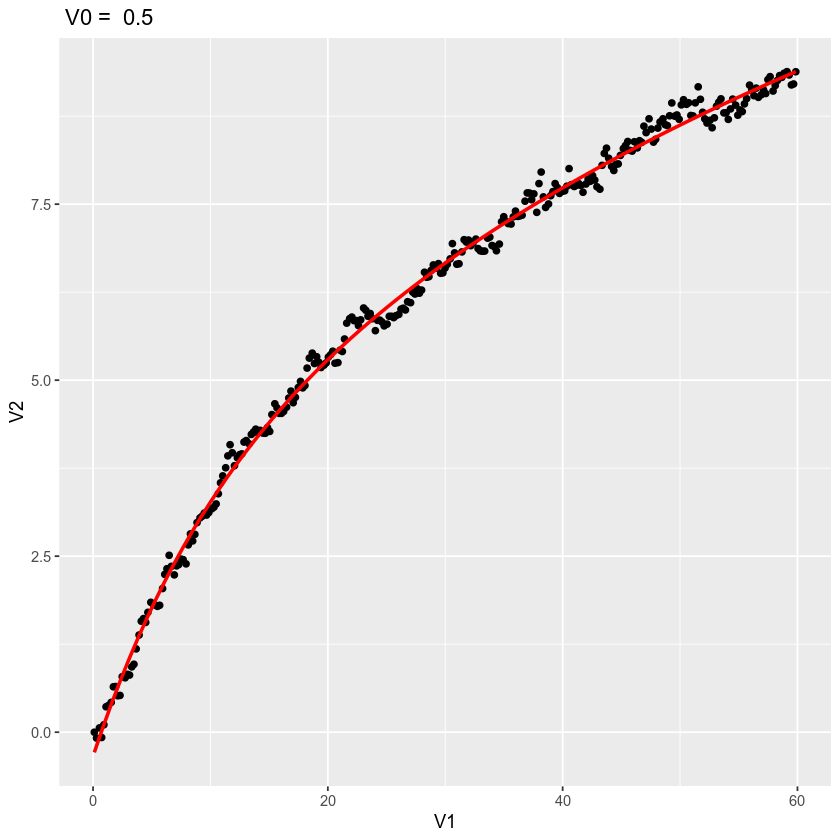

In [26]:
dot_data <- read.table("data/6.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 180
enzyme_start = 370
end_enzyme = 520

#Approximations
start_linear = 0
end_linear = 5
start_exp = start_linear
end_exp = 15
end_double_exp = 60
# ======================================================================
INDEX = 6

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 7 experimental point (07-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l2100nM)

SUBBORN first points before double exp approx00
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: singular convergence (7)”

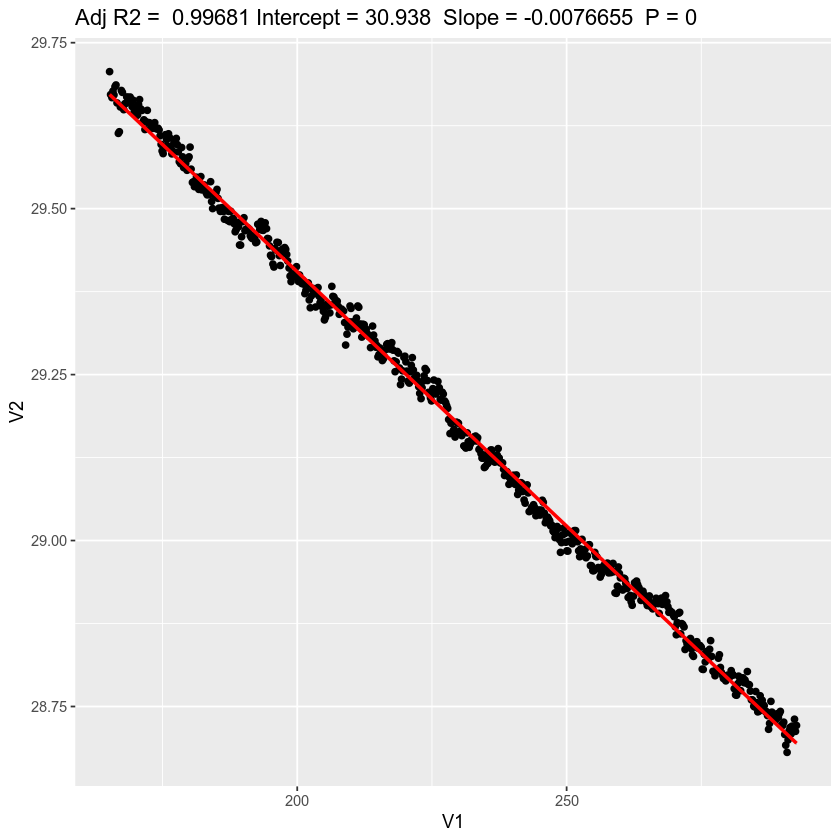

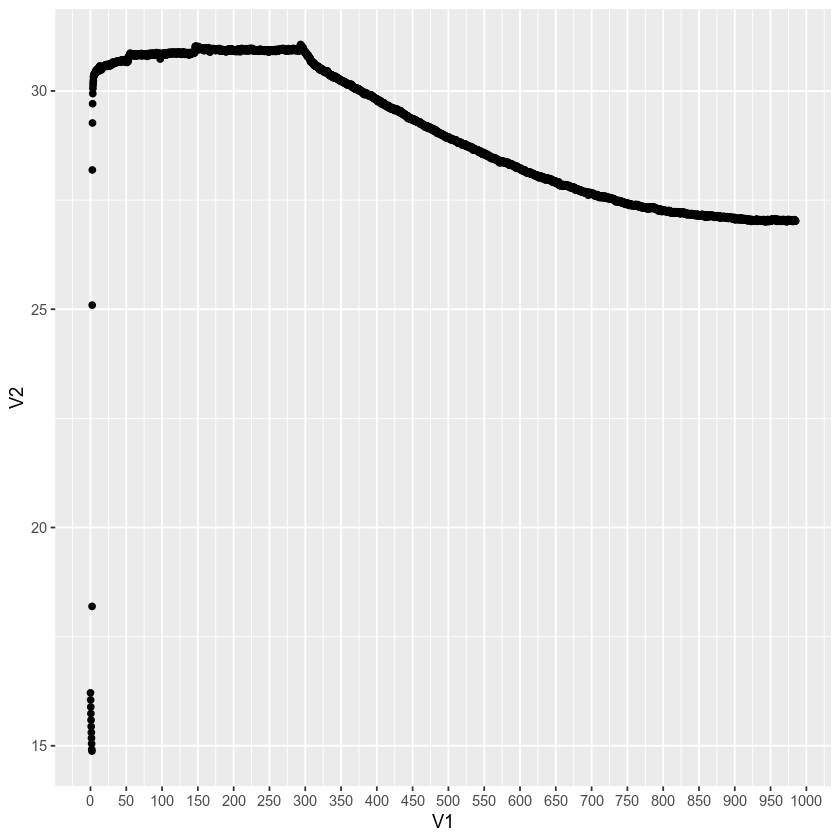

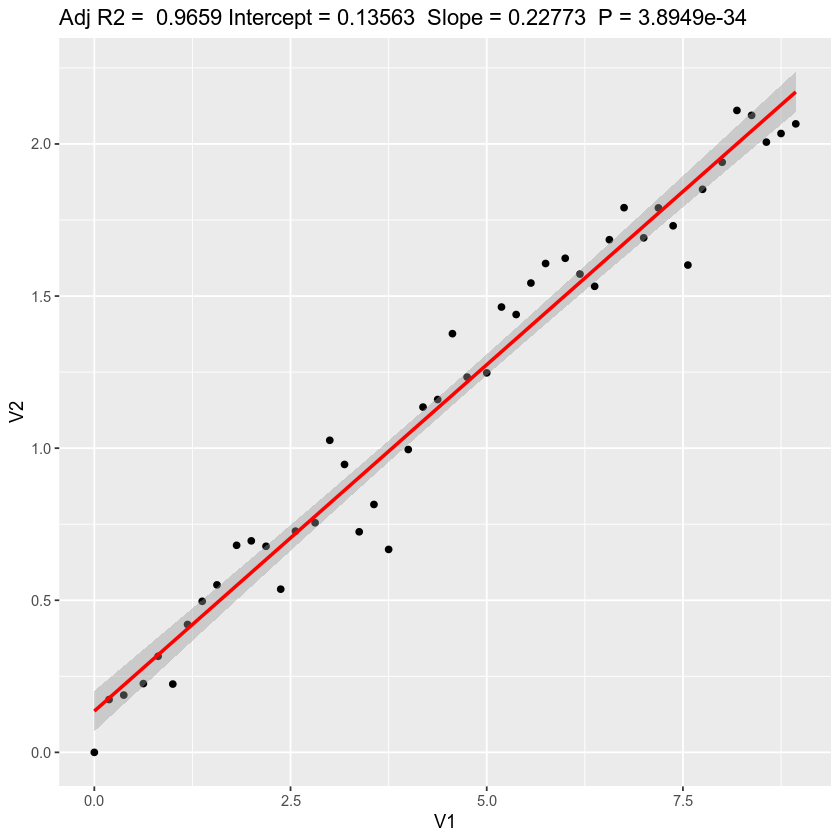

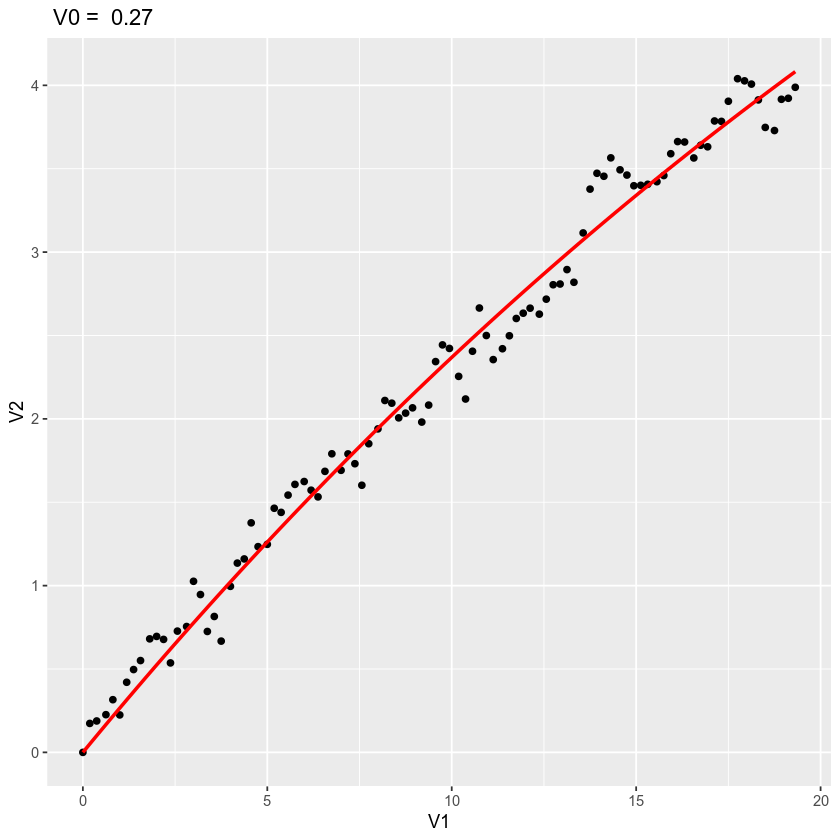

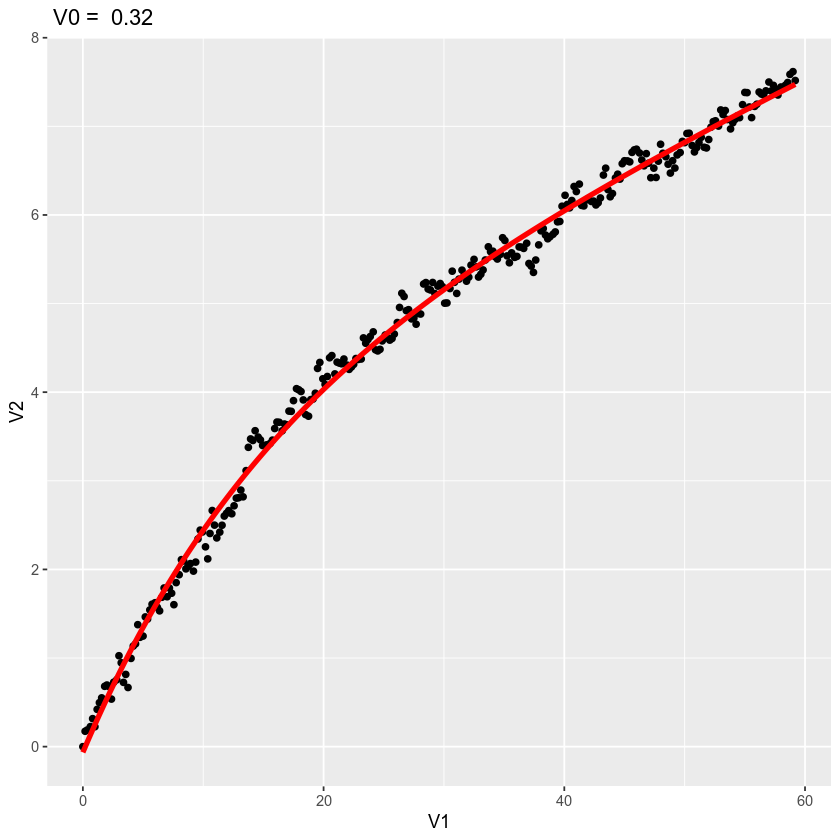

In [27]:
dot_data <- read.table("data/7.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 165
enzyme_start = 292.8
end_enzyme = 520

#Approximations
start_linear = 0.5
end_linear = 9
start_exp = start_linear
end_exp = 20
end_double_exp = 60
# ======================================================================
INDEX = 7

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp, STUBBORN = TRUE)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 8 experimental point (08-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l2400nM)

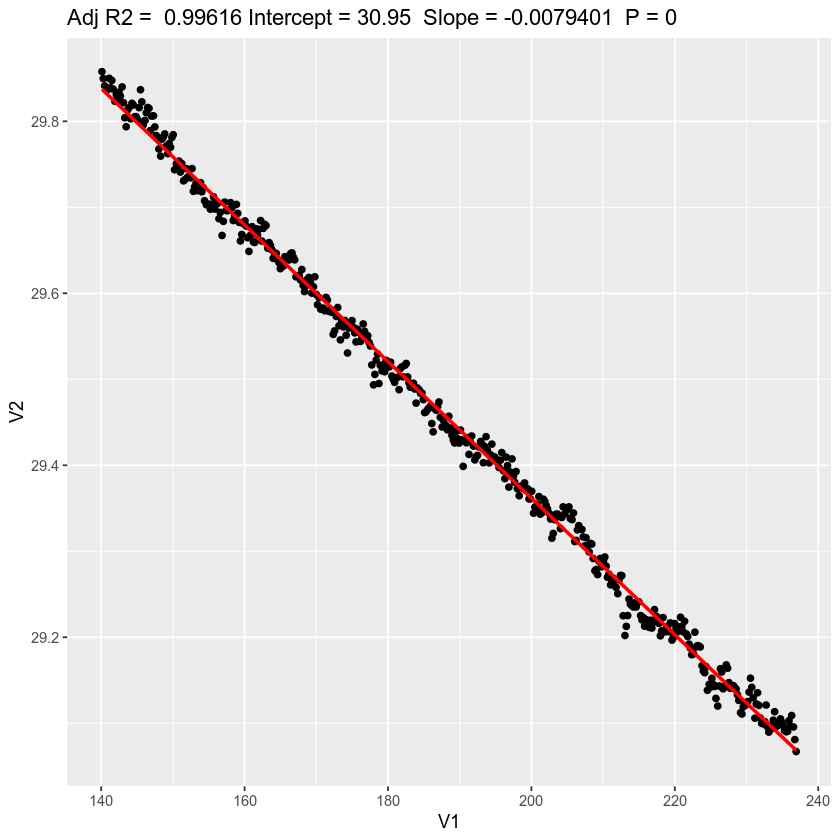

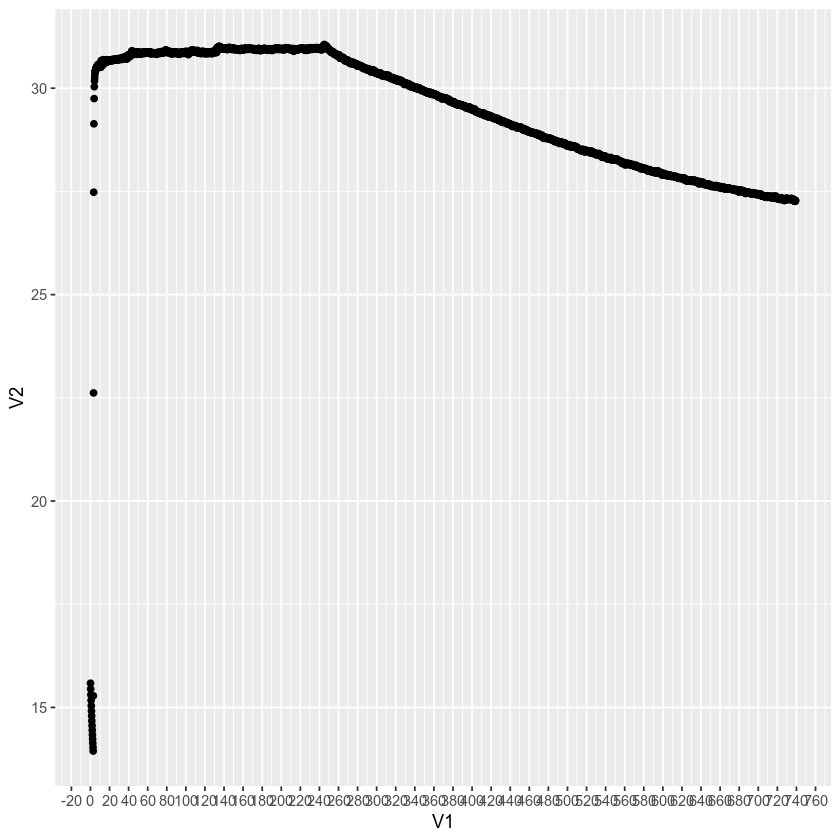

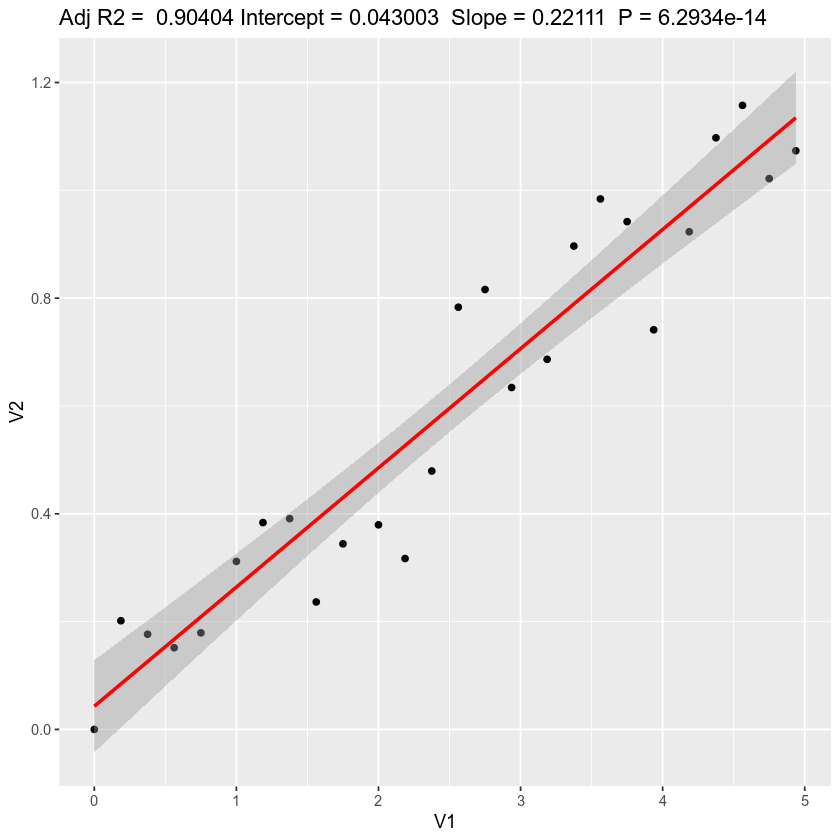

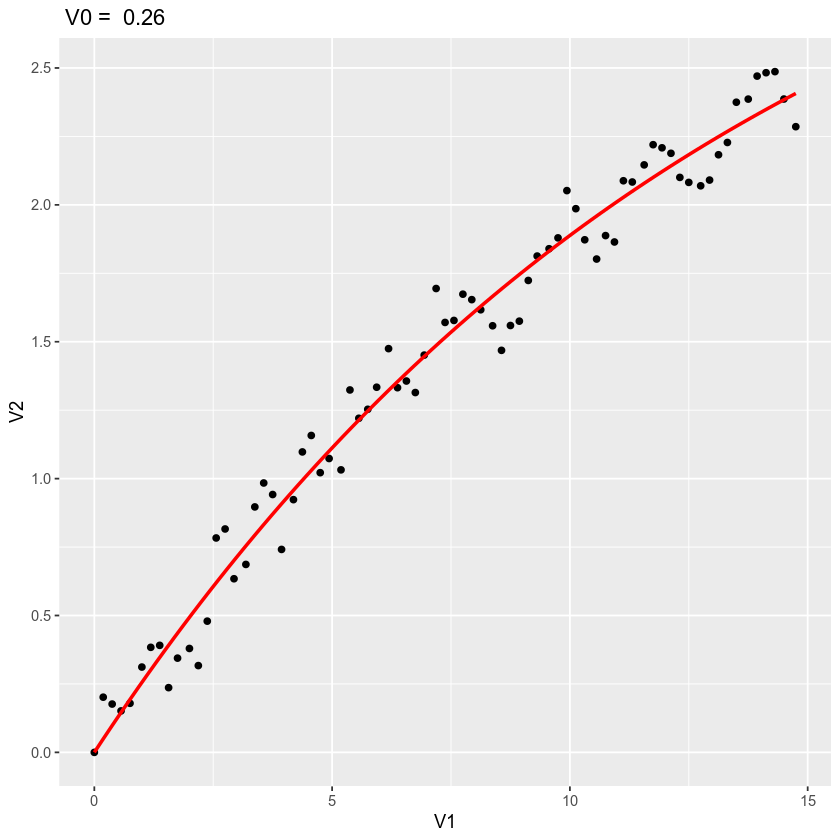

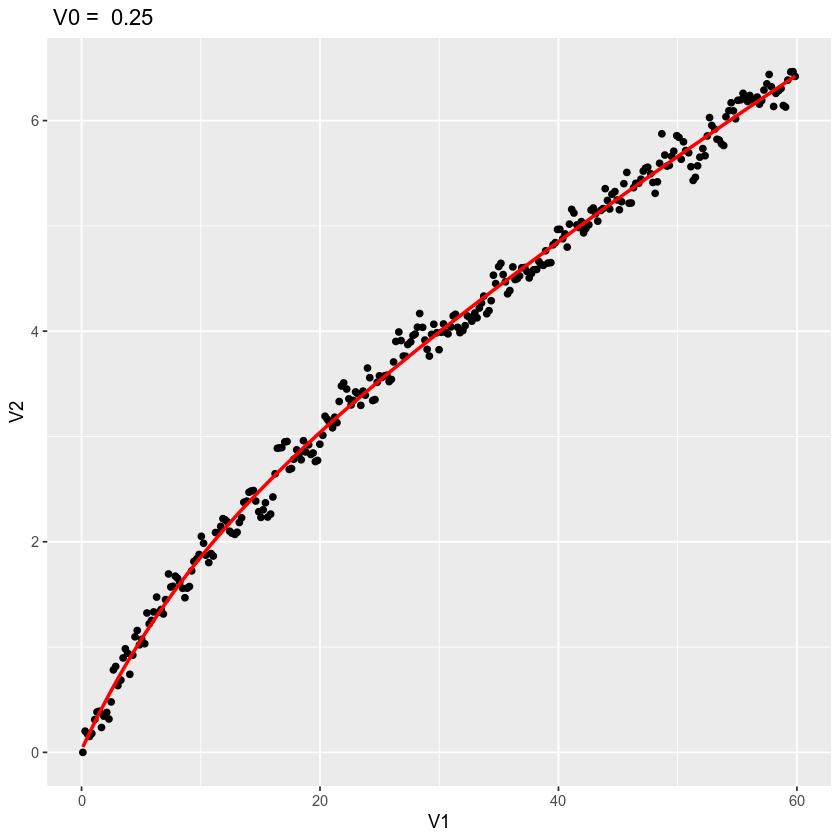

In [28]:
dot_data <- read.table("data/8.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 140
enzyme_start = 237
end_enzyme = 520

#Approximations
start_linear = 8
end_linear = 5
start_exp = start_linear
end_exp = 23
end_double_exp = 68
# ======================================================================
INDEX = 8

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

Poor convergence archieved for double exponent approximation since data is too close to a straight line. 
Using parameters from not converged approximation with least square distance from data.

## 9 experimental point (09-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l3000nM)

SUBBORN first points before double exp approx00
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: function evaluation limit reached without convergence (9)”

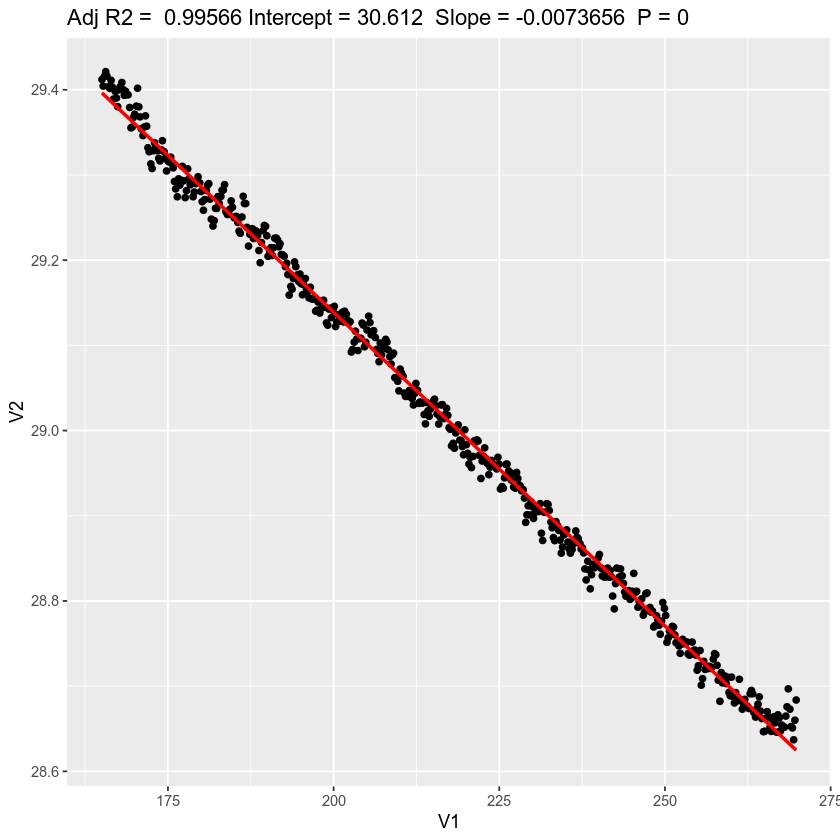

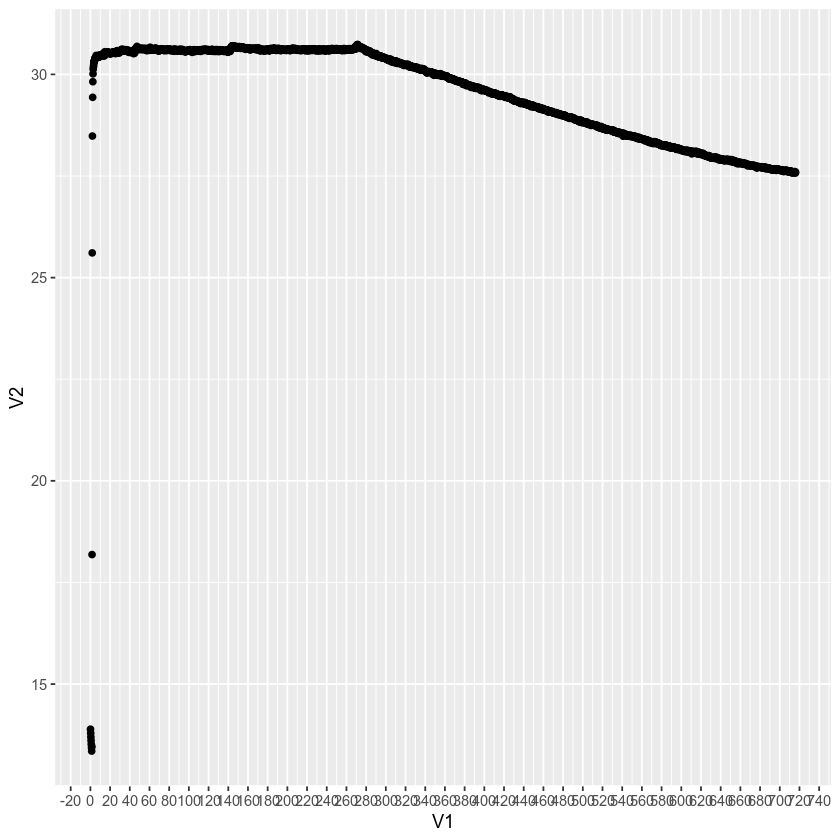

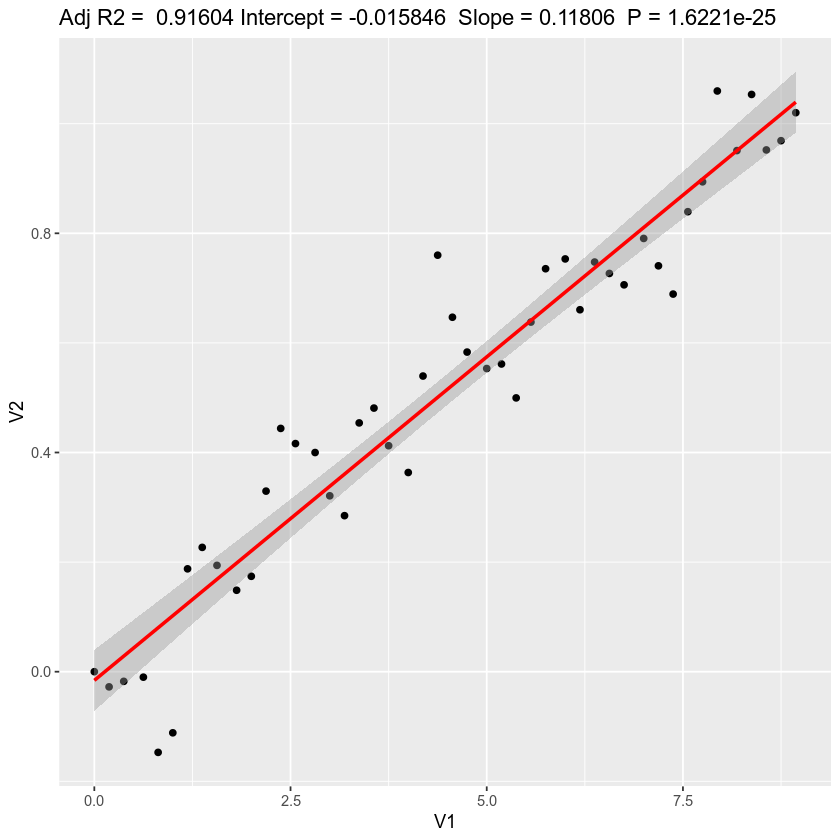

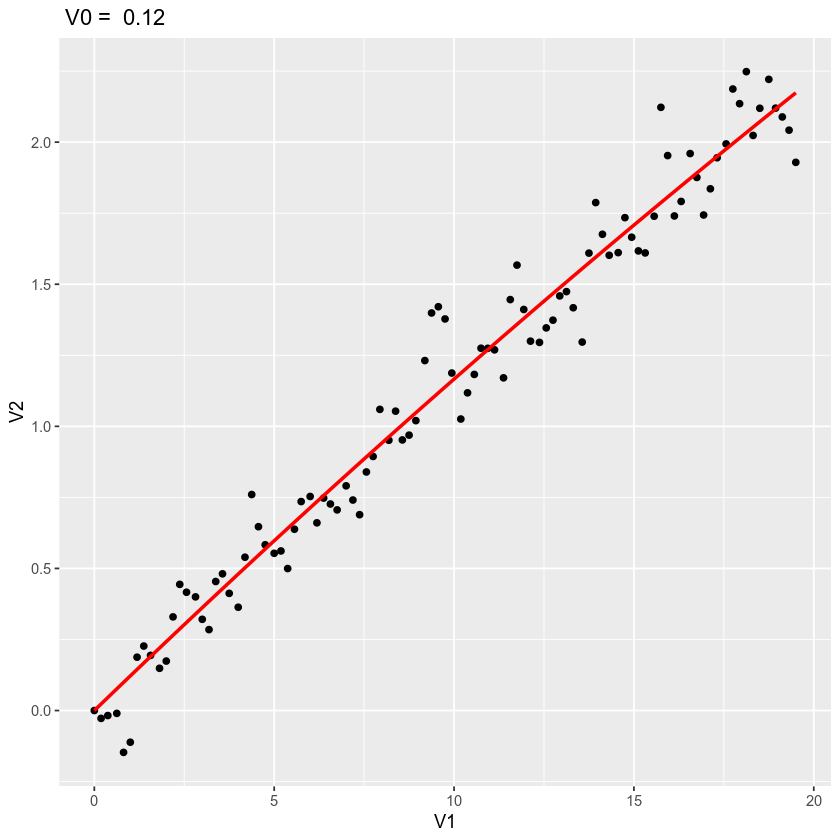

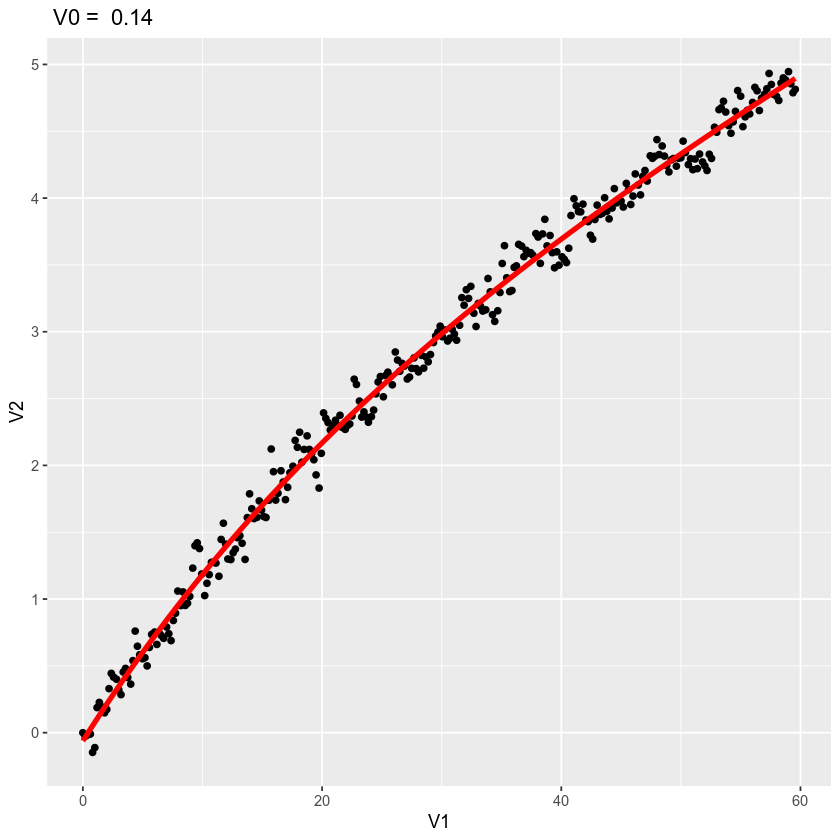

In [29]:
dot_data <- read.table("data/9.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 165
enzyme_start = 270
end_enzyme = 520

#Approximations
start_linear = 0.4
end_linear = 9
start_exp = start_linear
end_exp = 20
end_double_exp = 60
# ======================================================================
INDEX = 9

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp, STUBBORN = T)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out 
#add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table

enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 10 experimental point (10-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l5000nM)

SUBBORN first points before double exp approx00
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: function evaluation limit reached without convergence (9)”

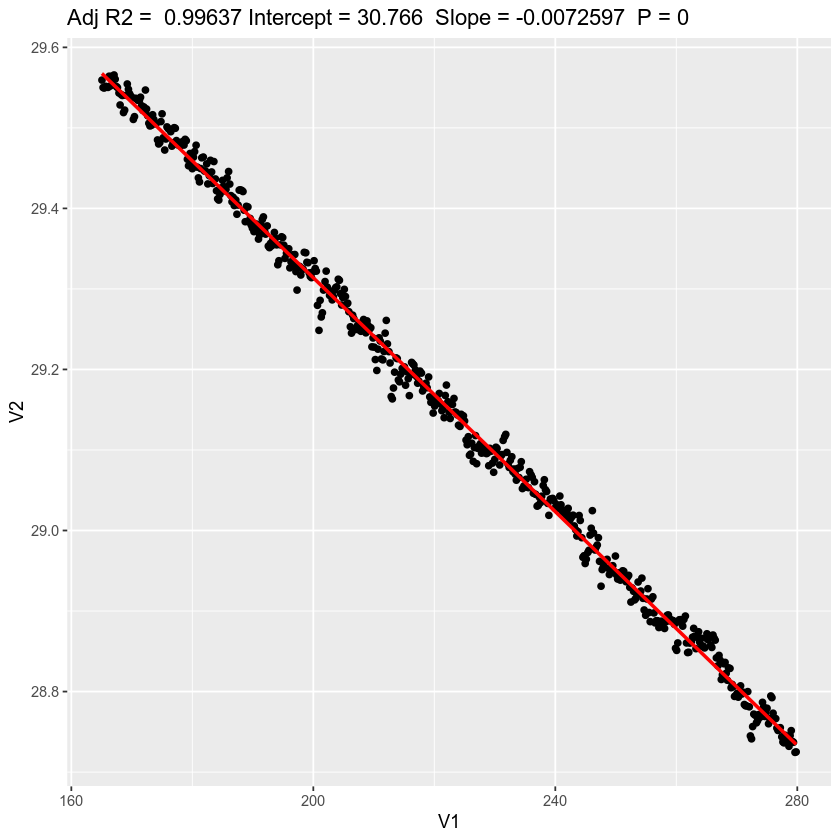

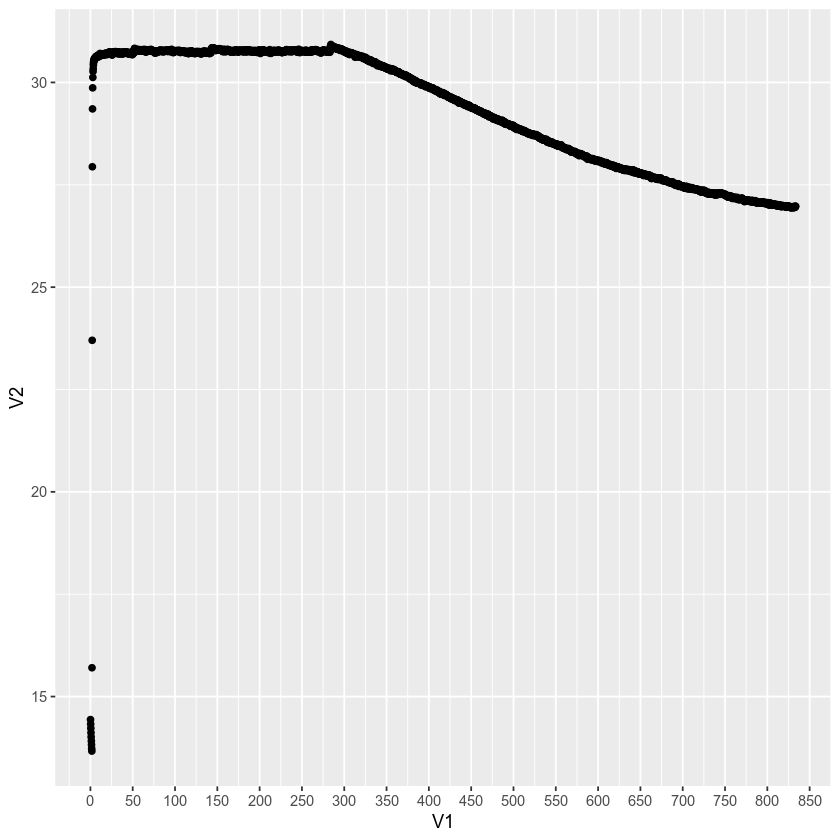

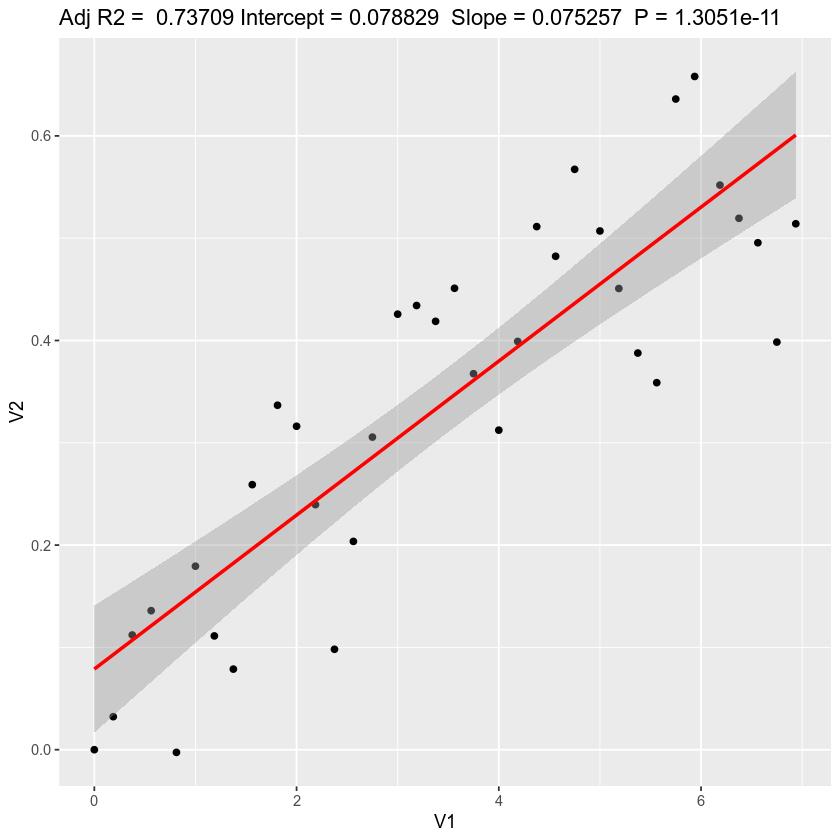

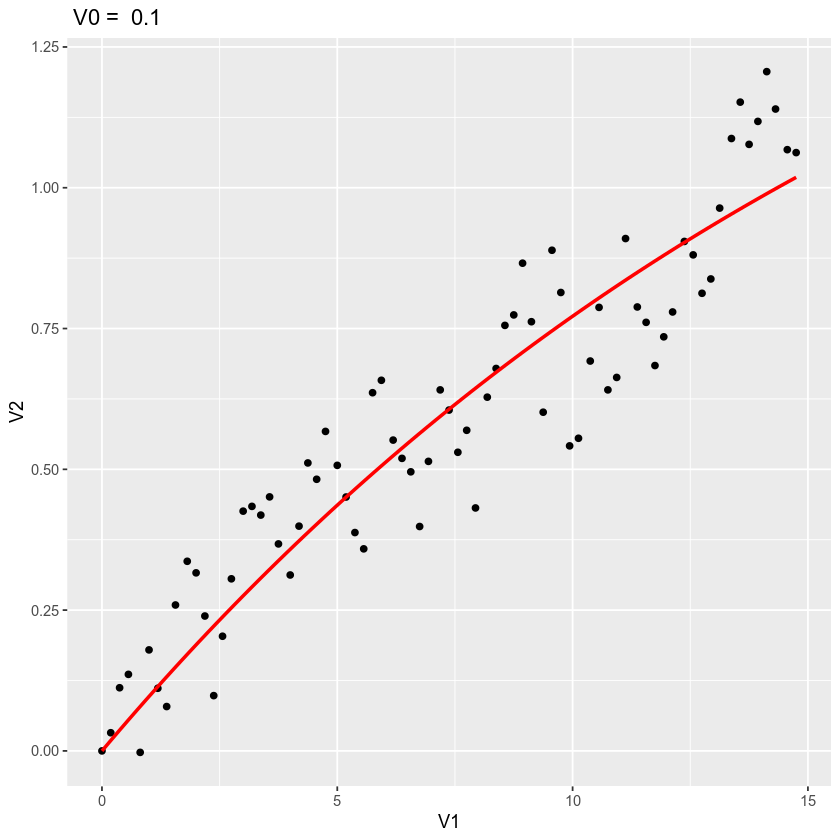

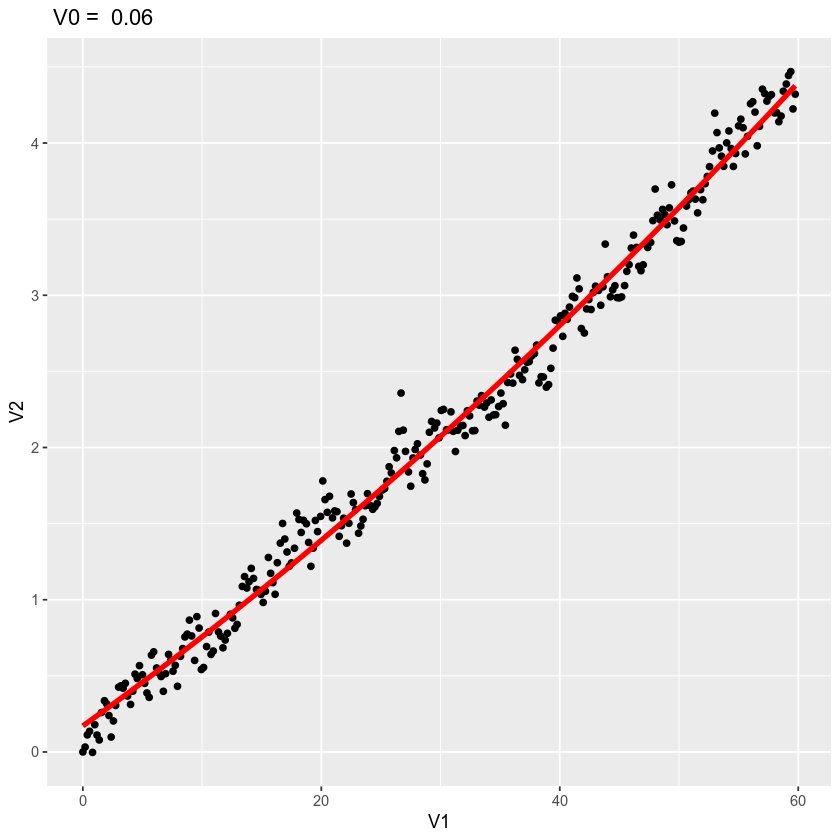

In [30]:
dot_data <- read.table("data/10.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 165
enzyme_start = 280
end_enzyme = 520

#Approximations
start_linear = 6
end_linear = 7
start_exp = start_linear
end_exp = 21
end_double_exp = 66
# ======================================================================
INDEX = 10

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp, STUBBORN = T)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

Poor convergence archieved for double exponent approximation since data is too close to a straight line. 
Using parameters from not converged approximation with least square distance from data.

## 11 experimental point (11-IS(IE)-FCii1mM_hem2uM_Tol1200nM_AA100uM1ul_IE11ulT0l1200nM)

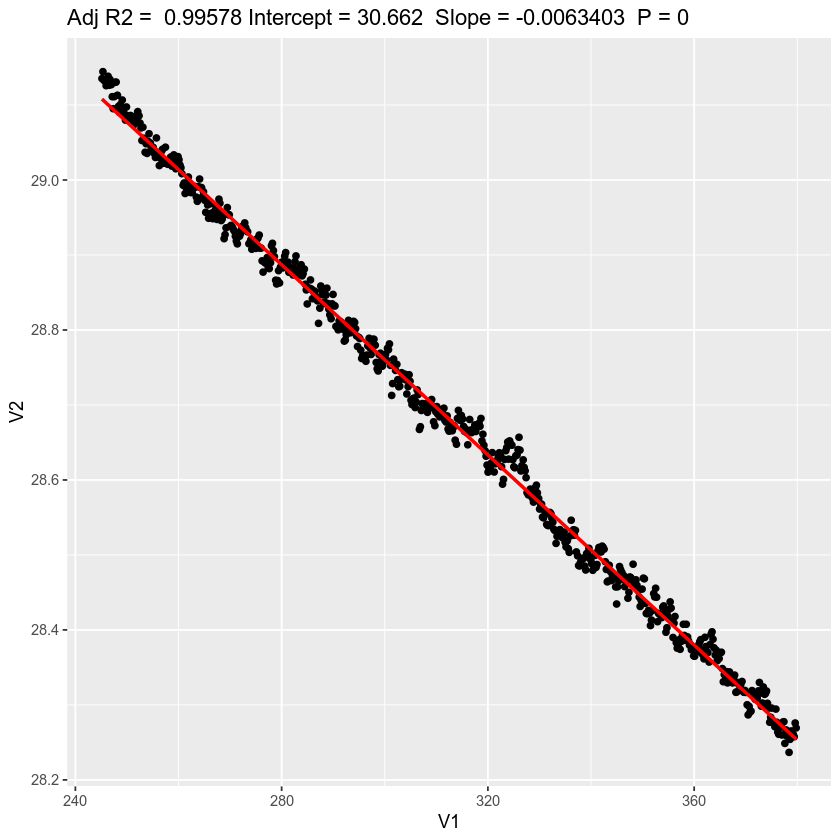

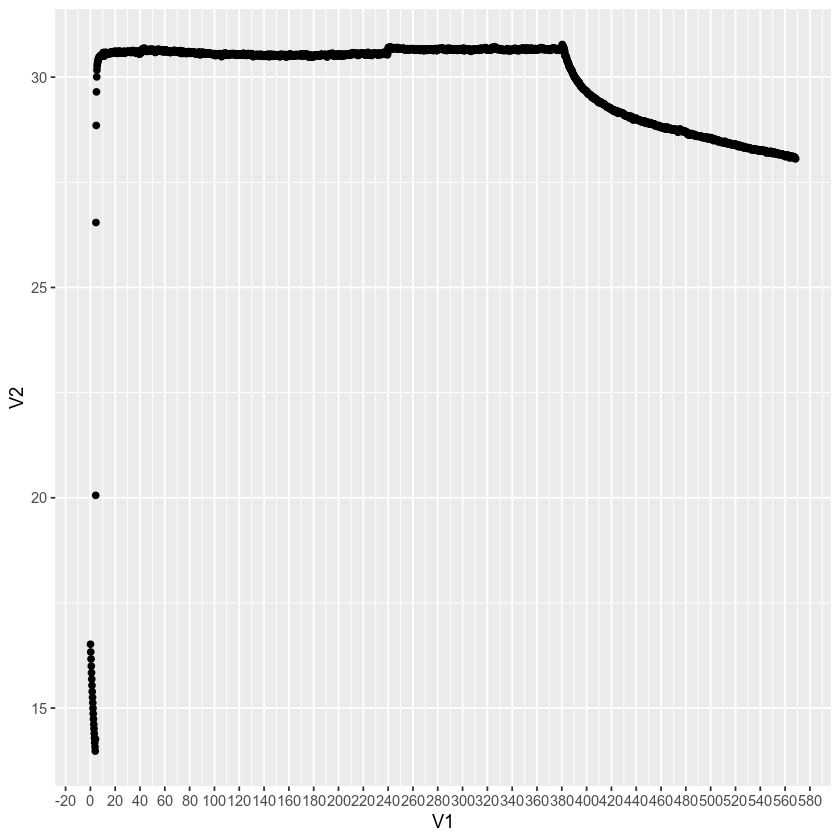

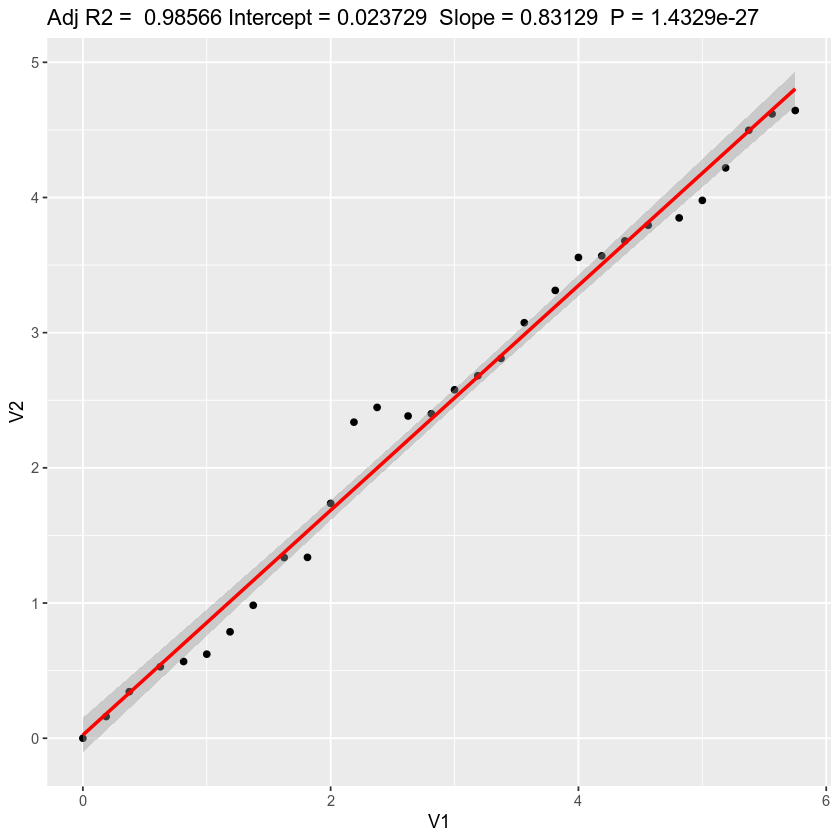

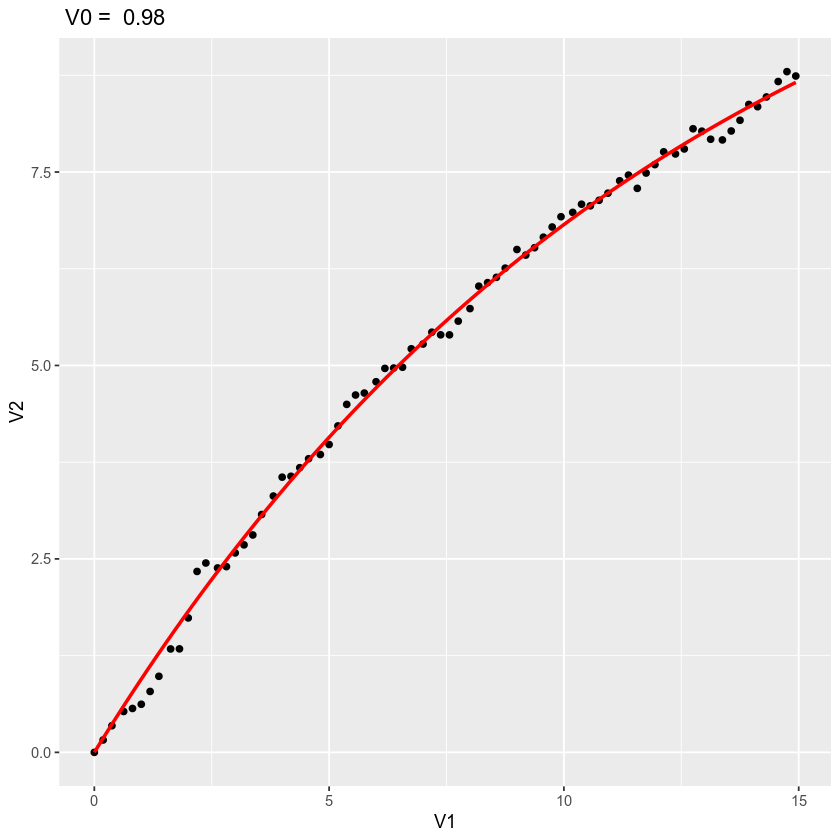

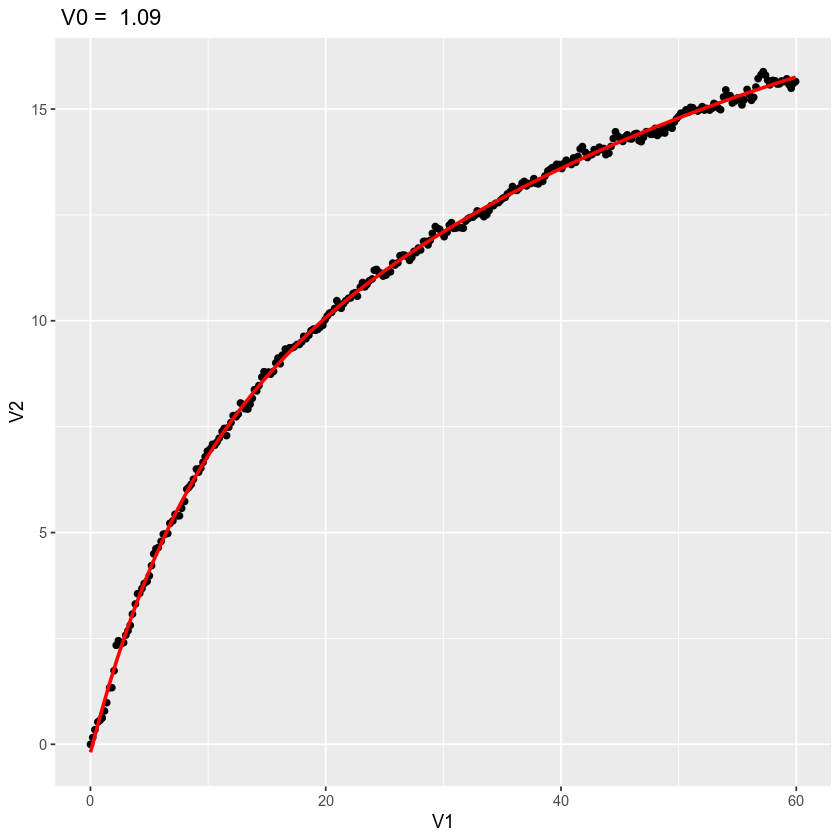

In [31]:
dot_data <- read.table("data/11.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 245
enzyme_start = 380
end_enzyme = 560

#Approximations
start_linear = 0.4
end_linear = 6
start_exp = start_linear
end_exp = 15.4
end_double_exp = 60.4
# ======================================================================
INDEX = 11

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 12 experimental point (12-IS(IE)-FCii1mM_hem2uM_Tol2400nM_AA100uM1ul_IE11ulT0l2400nM)

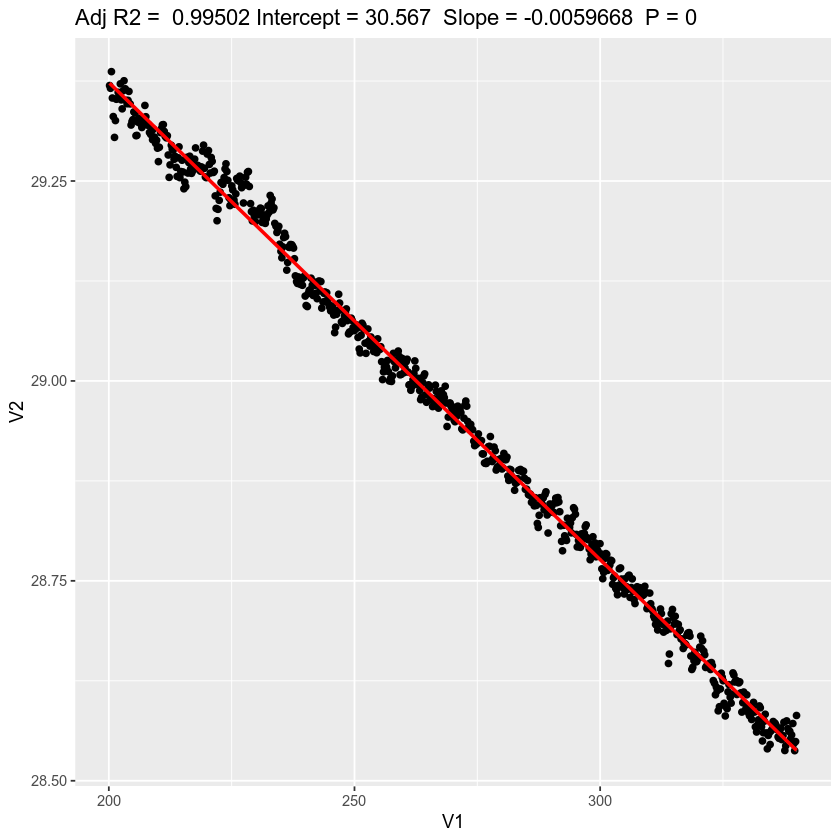

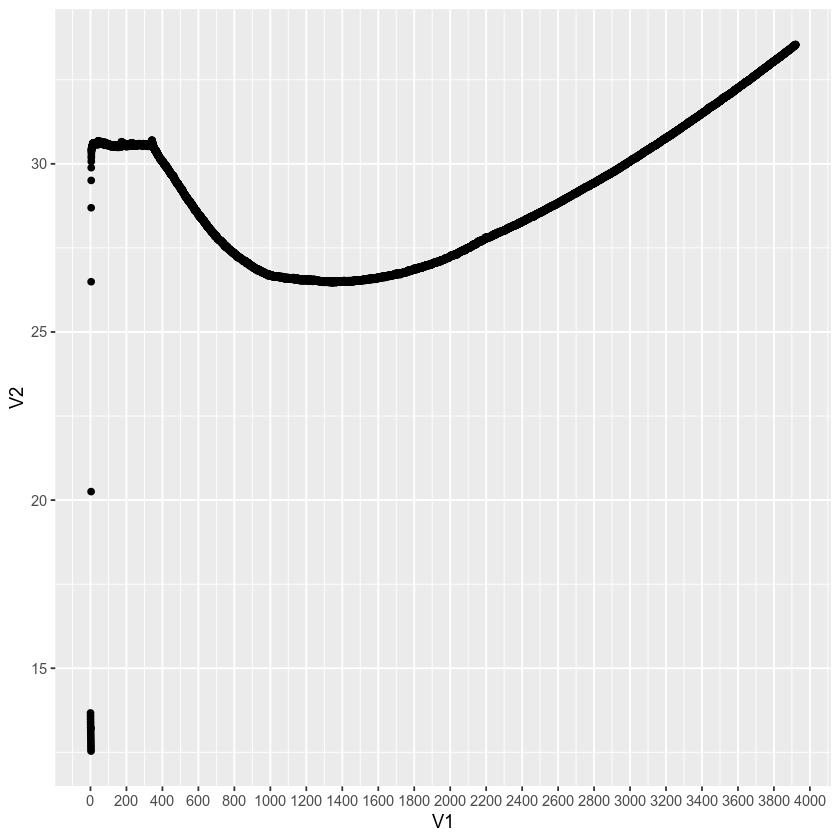

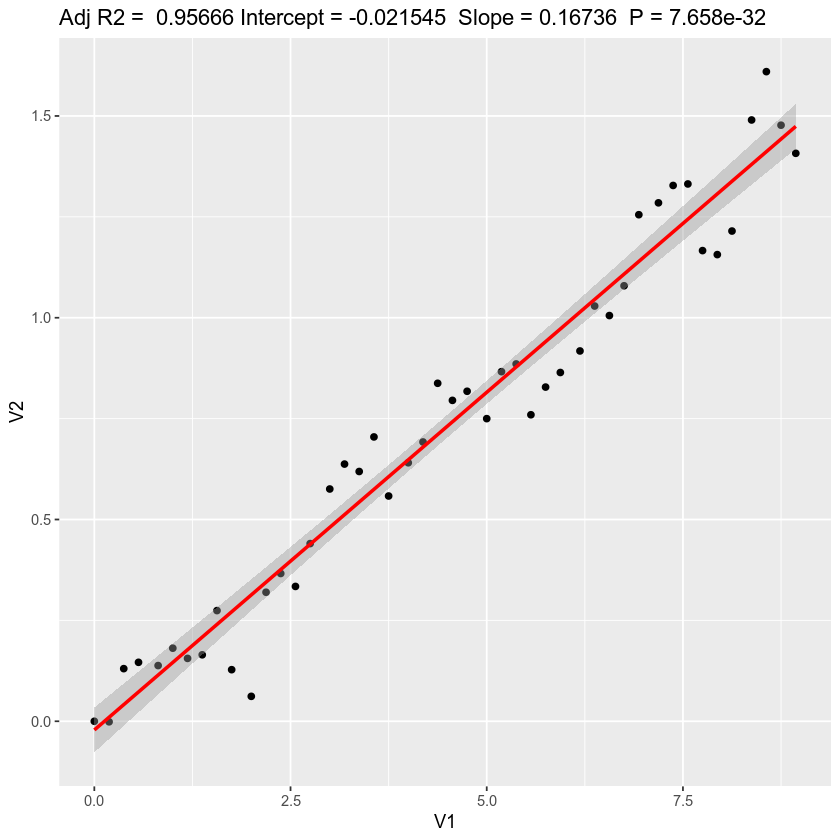

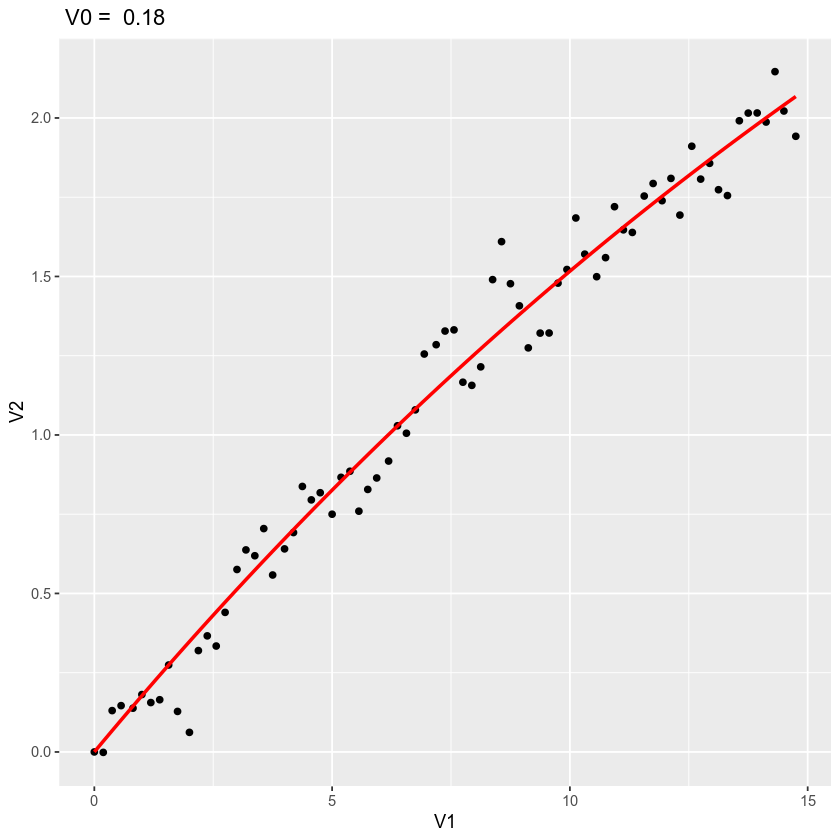

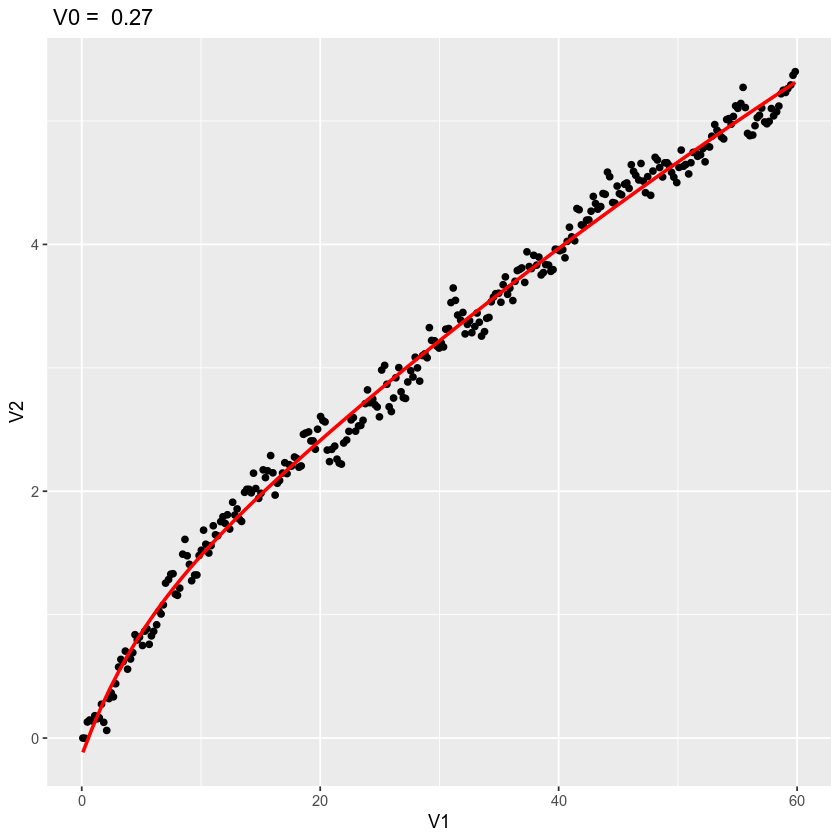

In [32]:
dot_data <- read.table("data/12.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 200
enzyme_start = 340
end_enzyme = 1000

#Approximations
start_linear = 2.5
end_linear = 9
start_exp = start_linear
end_exp = 17.5
end_double_exp = 62.5
# ======================================================================
INDEX = 12

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 13 experimental point (13-IS(0E)-FCii1mM_hem2uM_Tol3000nM_AA100uM1ul_IE11ulT0l0nM)

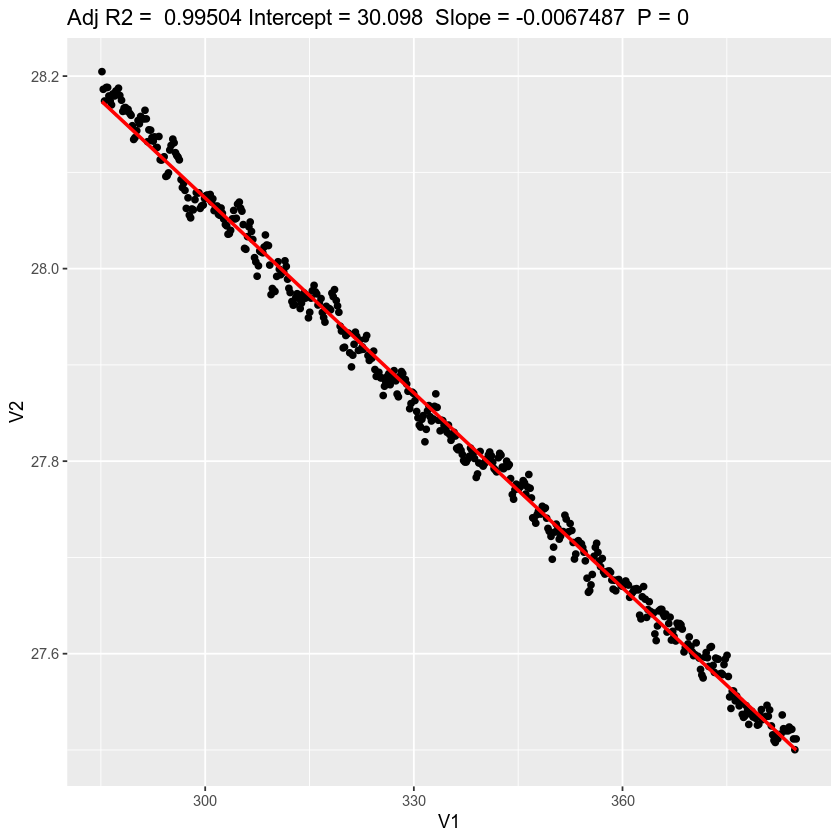

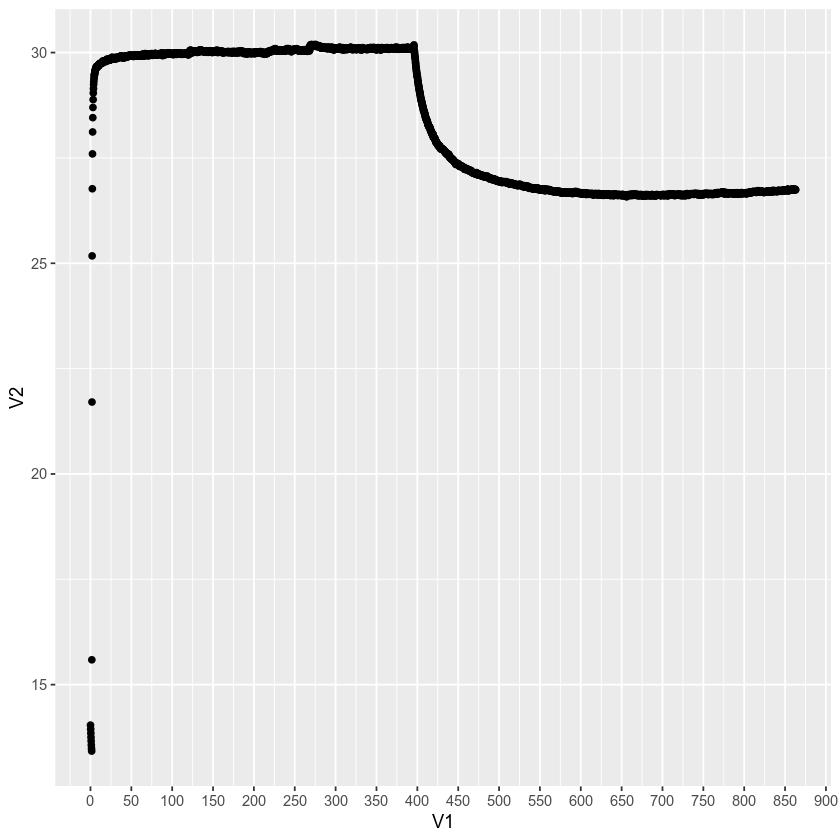

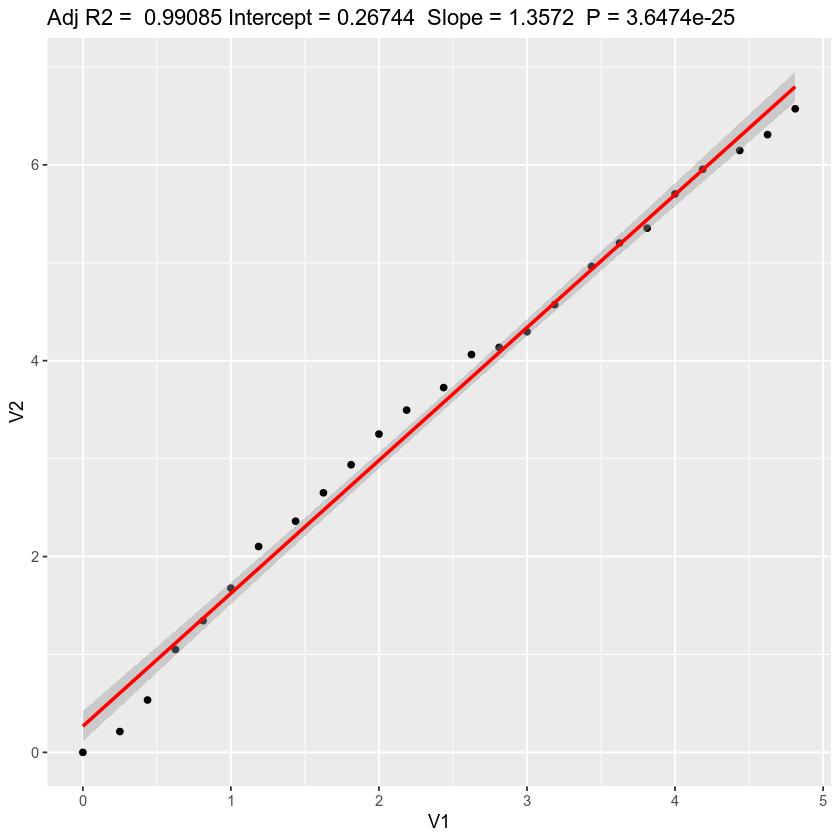

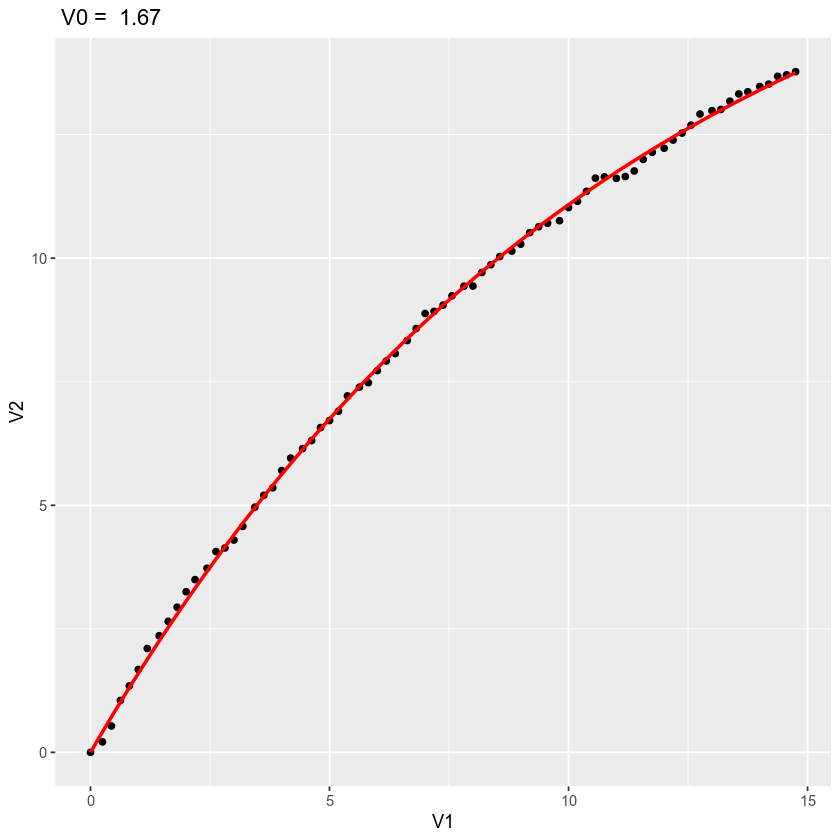

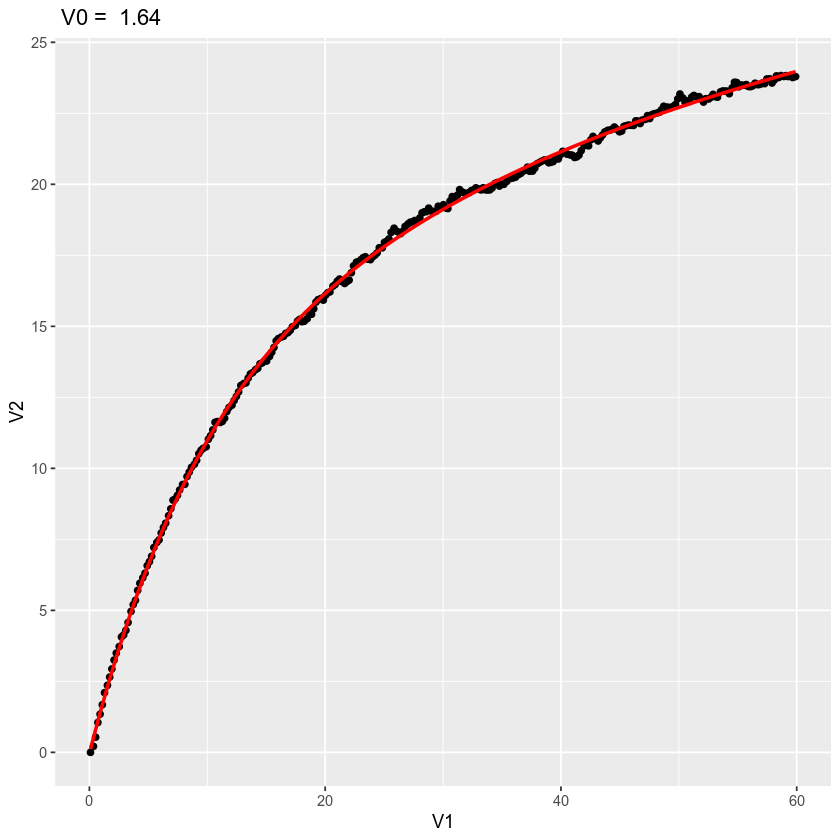

In [33]:
dot_data <- read.table("data/13.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 285
enzyme_start = 385
end_enzyme = 520

#Approximations
start_linear = 12
end_linear = 5
start_exp = start_linear
end_exp = 27
end_double_exp = 72
# ======================================================================
INDEX = 13

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 14 experimental point (14-0S(0E)-FCii1mM_hem2uM_AA100uM1ul_IE11ulT0l0nM)

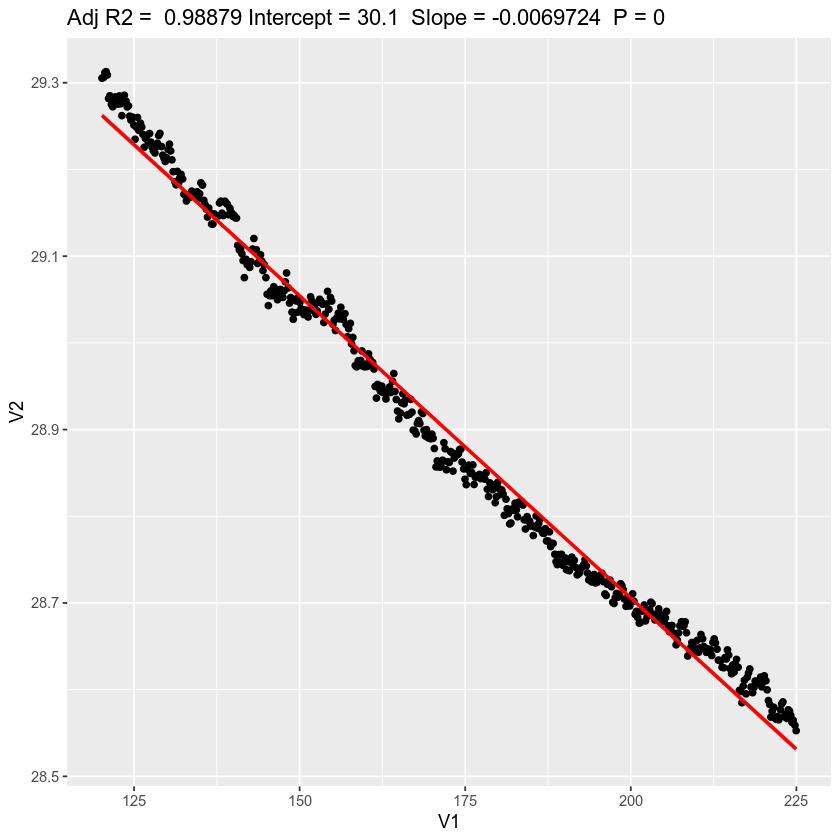

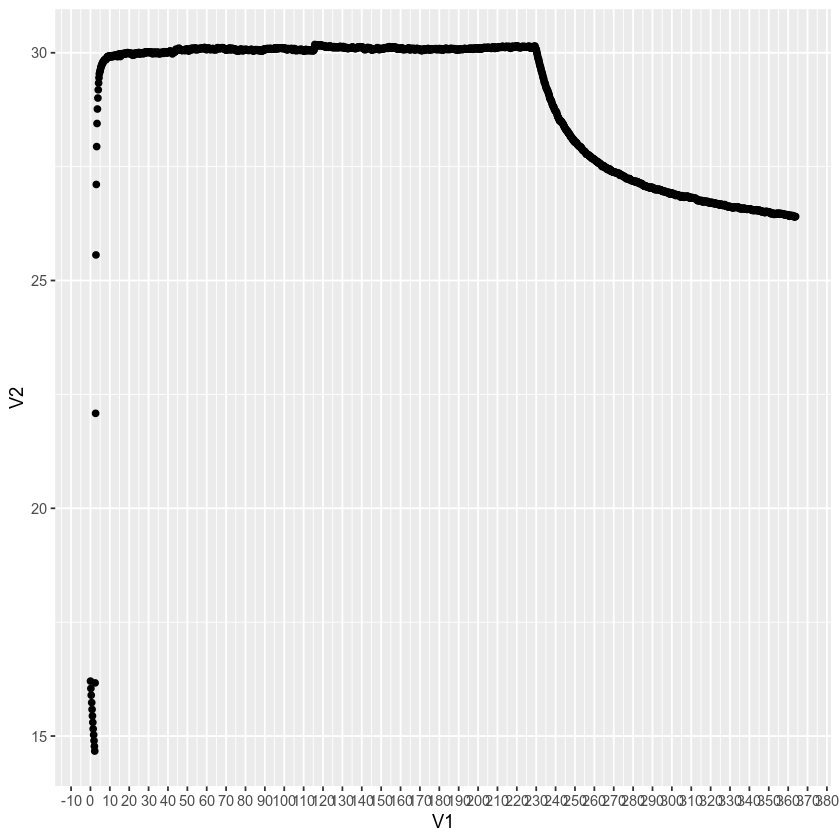

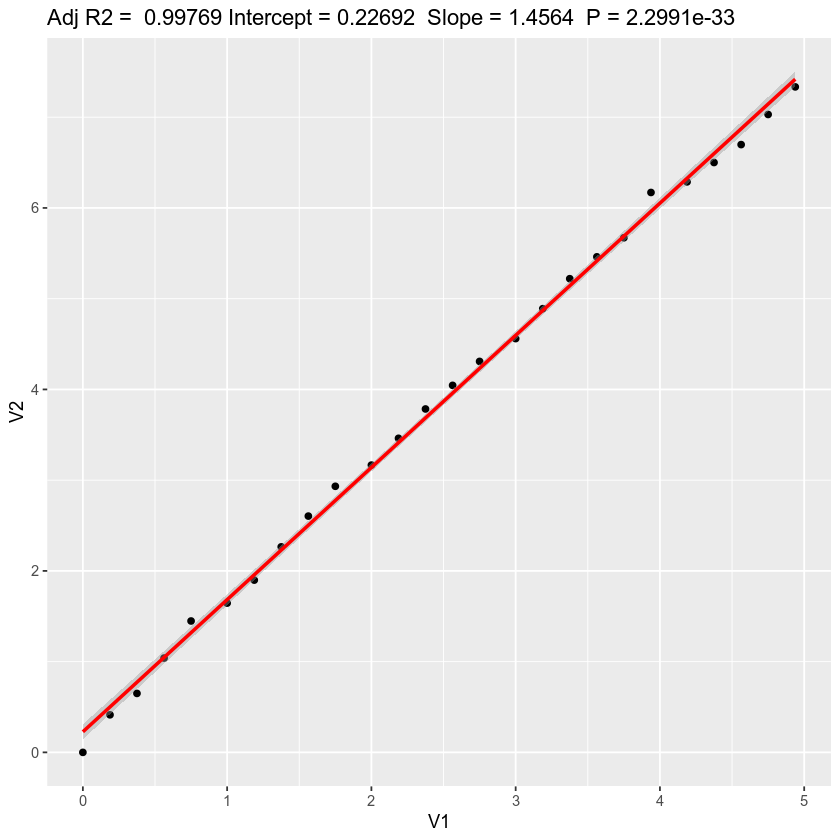

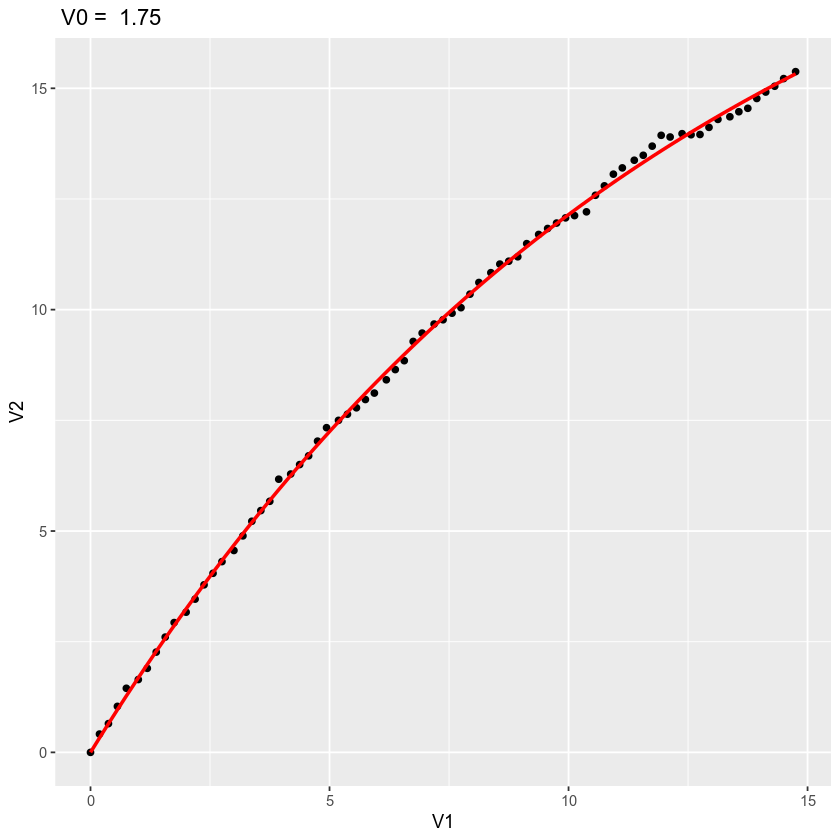

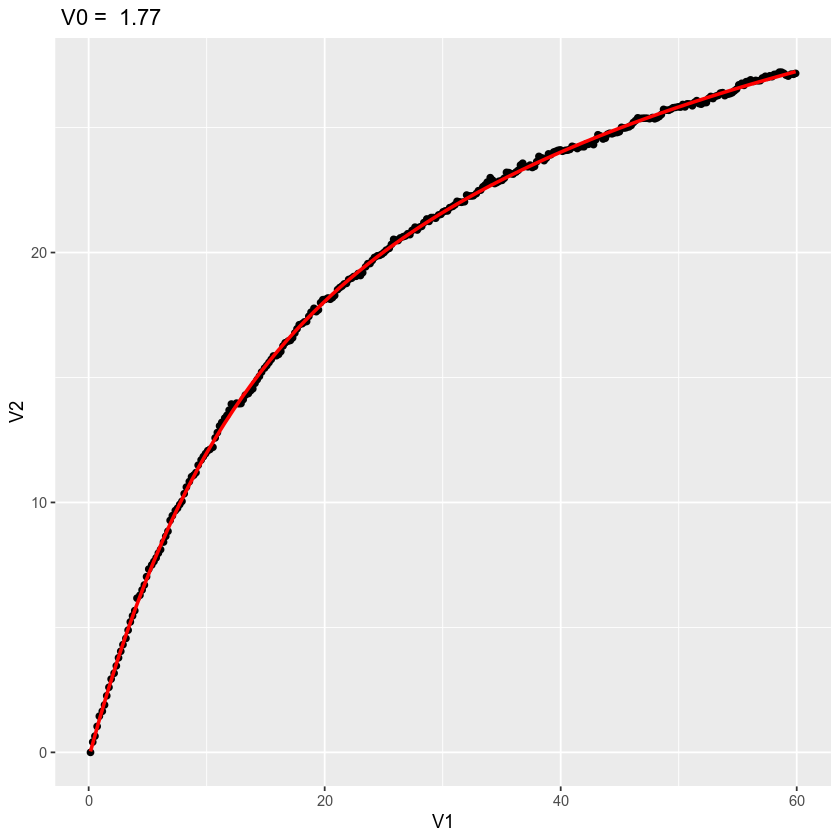

In [34]:
dot_data <- read.table("data/14.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 120
enzyme_start = 225
end_enzyme = 520

#Approximations
start_linear = 5
end_linear = 5
start_exp = start_linear
end_exp = 20
end_double_exp = 65
# ======================================================================
INDEX = 14

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 15 experimental point (15-0S(0E)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr0nM)

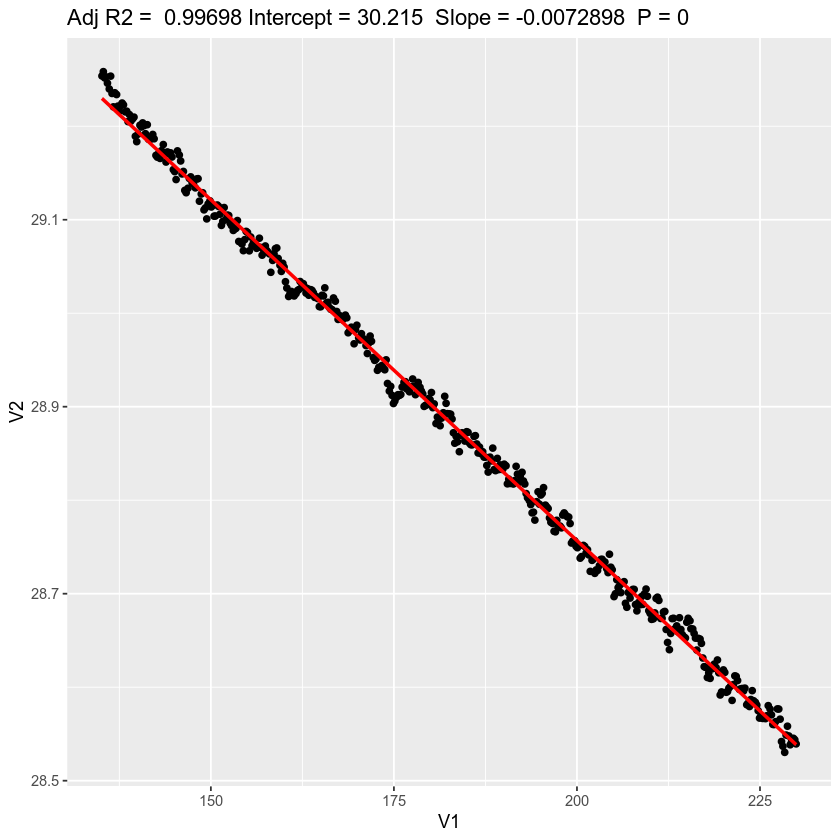

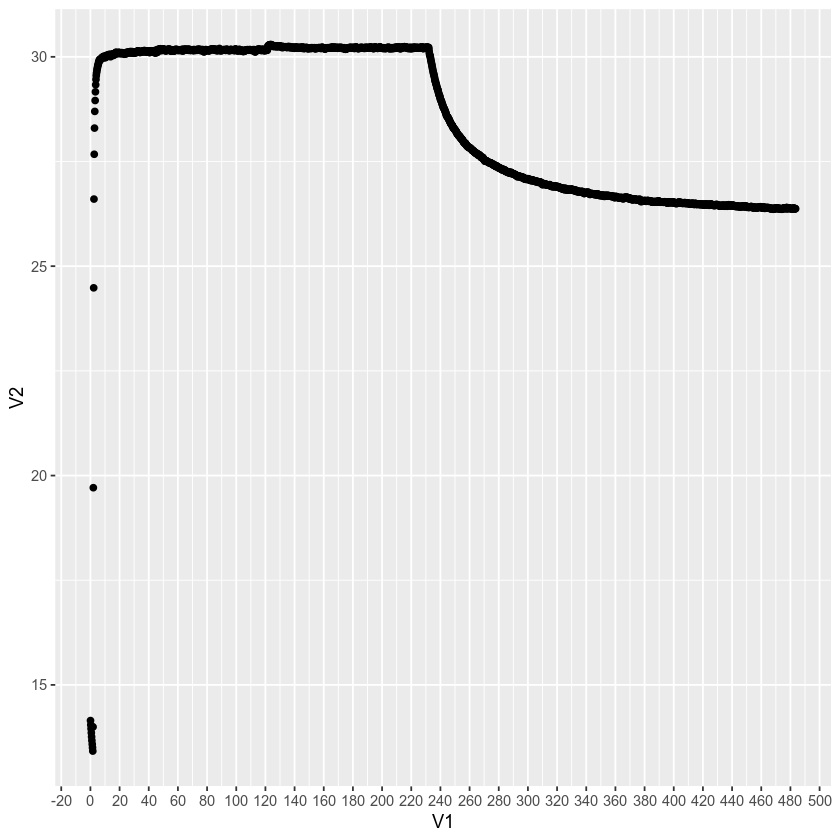

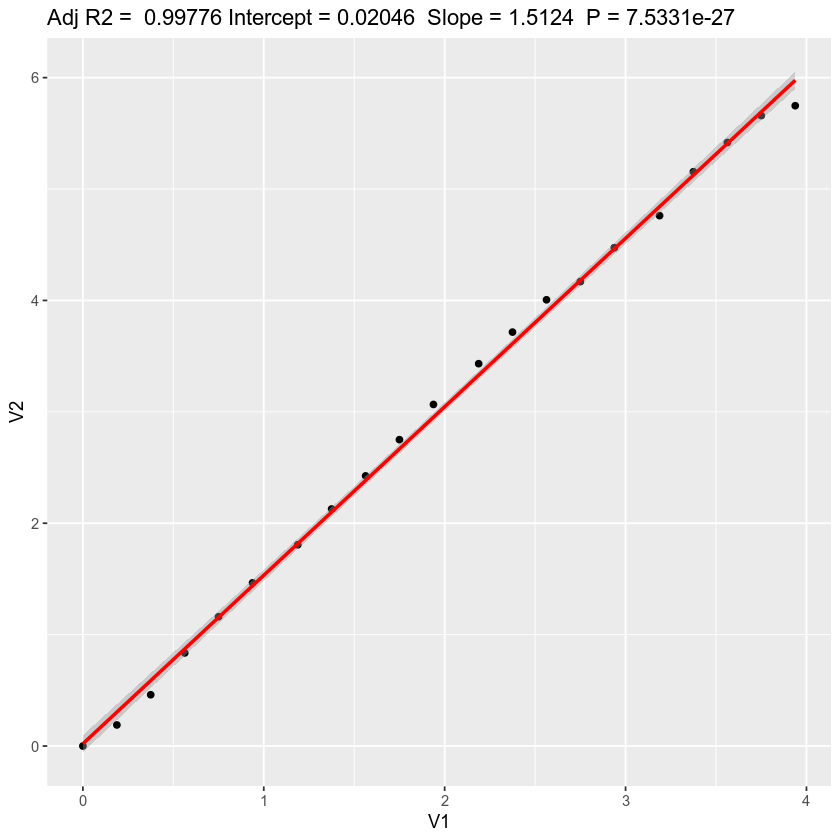

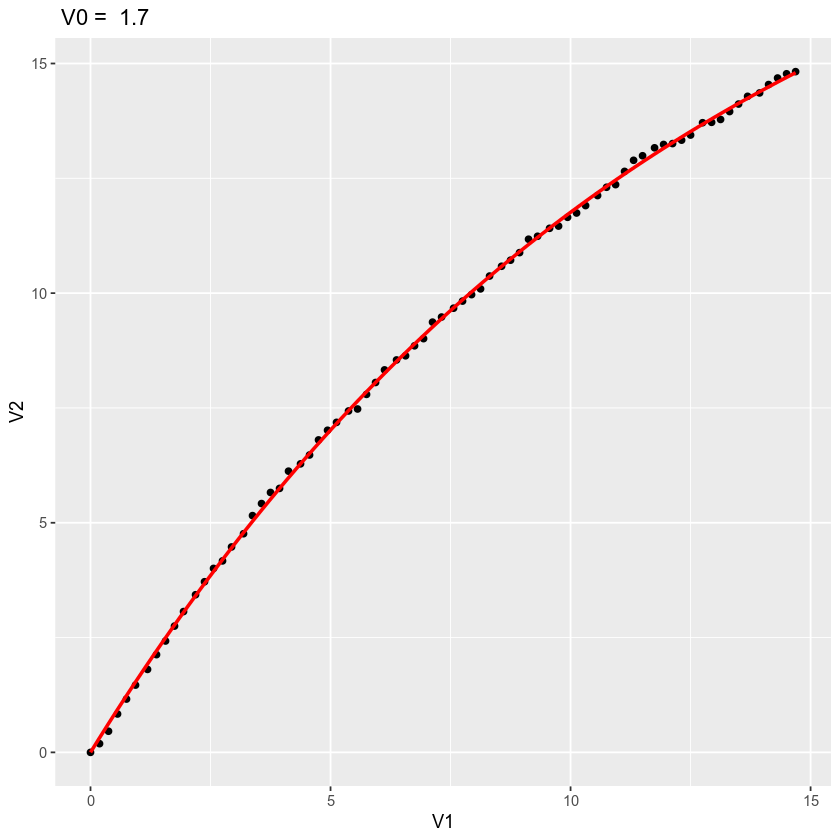

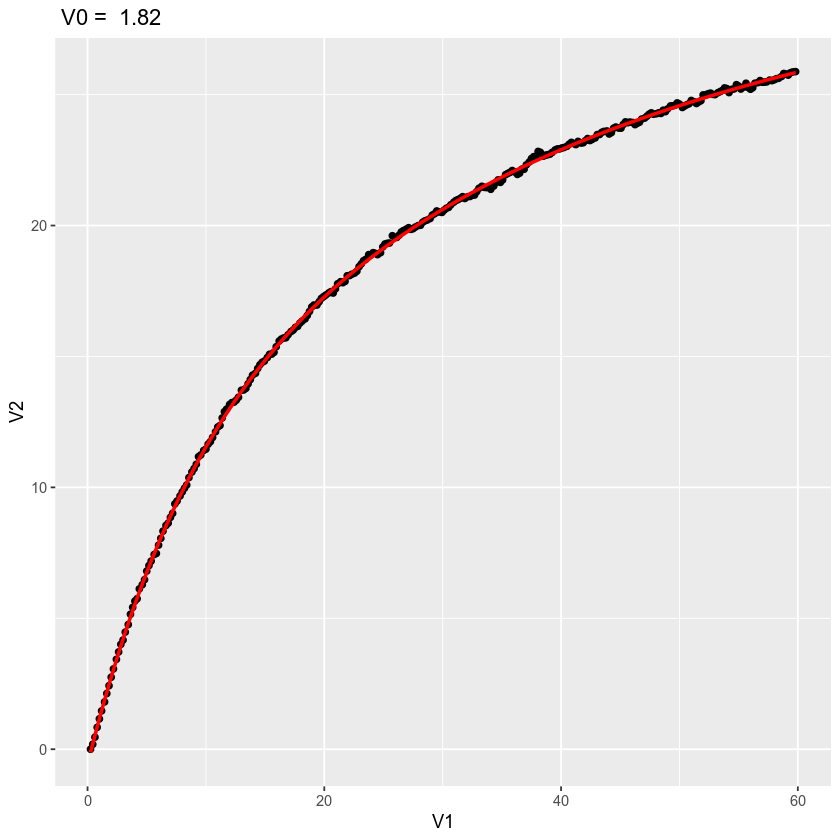

In [35]:
dot_data <- read.table("data/15.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 135
enzyme_start = 230
end_enzyme = 520

#Approximations
start_linear = 2.5
end_linear = 4
start_exp = start_linear
end_exp = 17.5
end_double_exp = 62.5
# ======================================================================
INDEX = 15

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 16 experimental point (16-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr600nM)

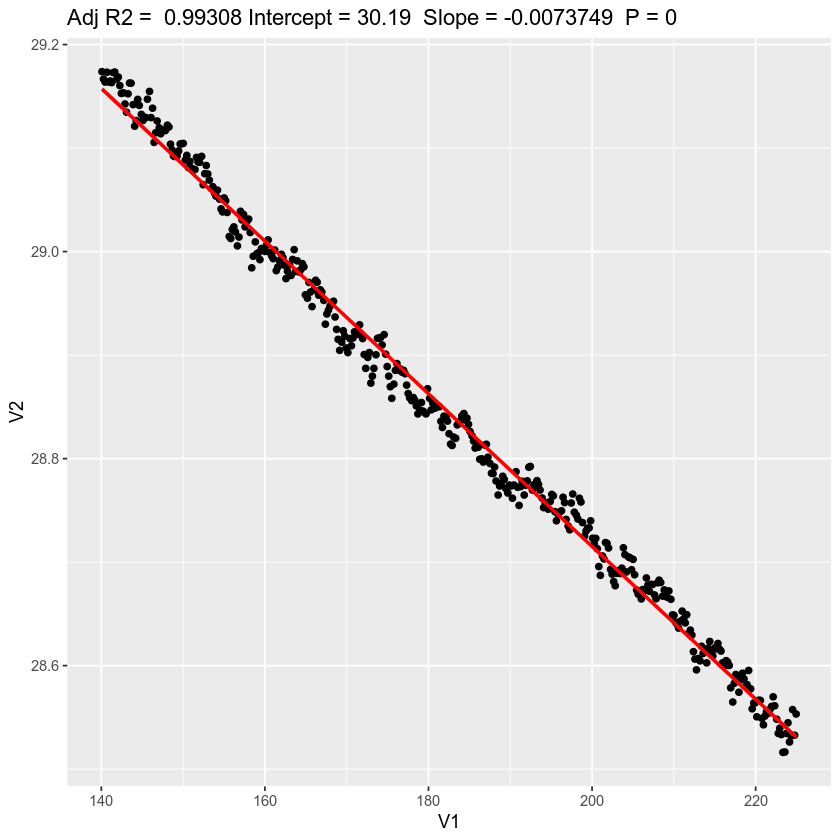

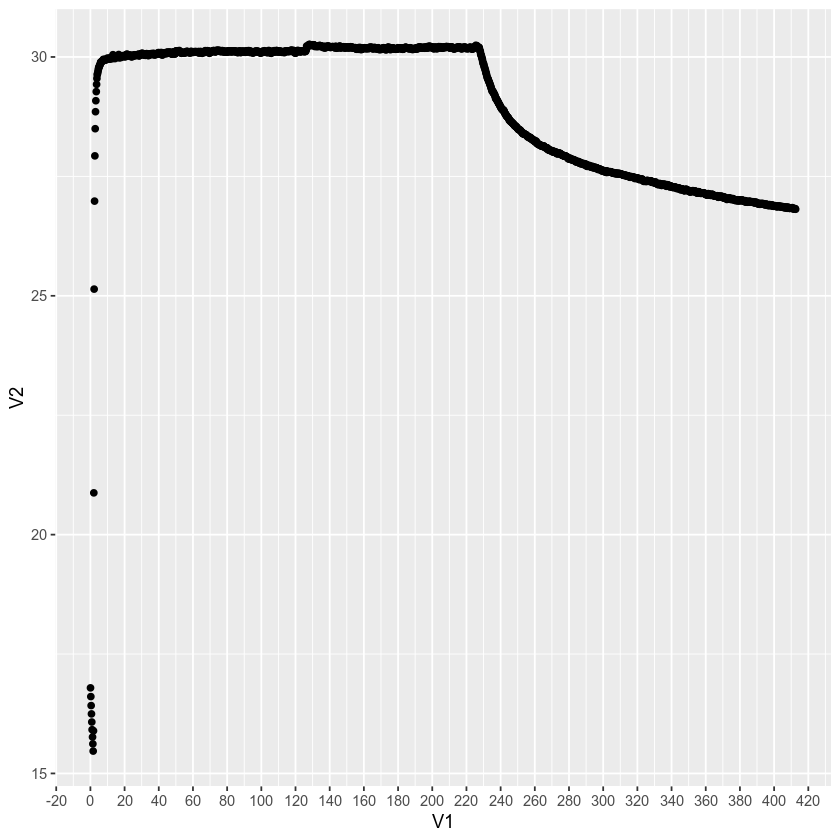

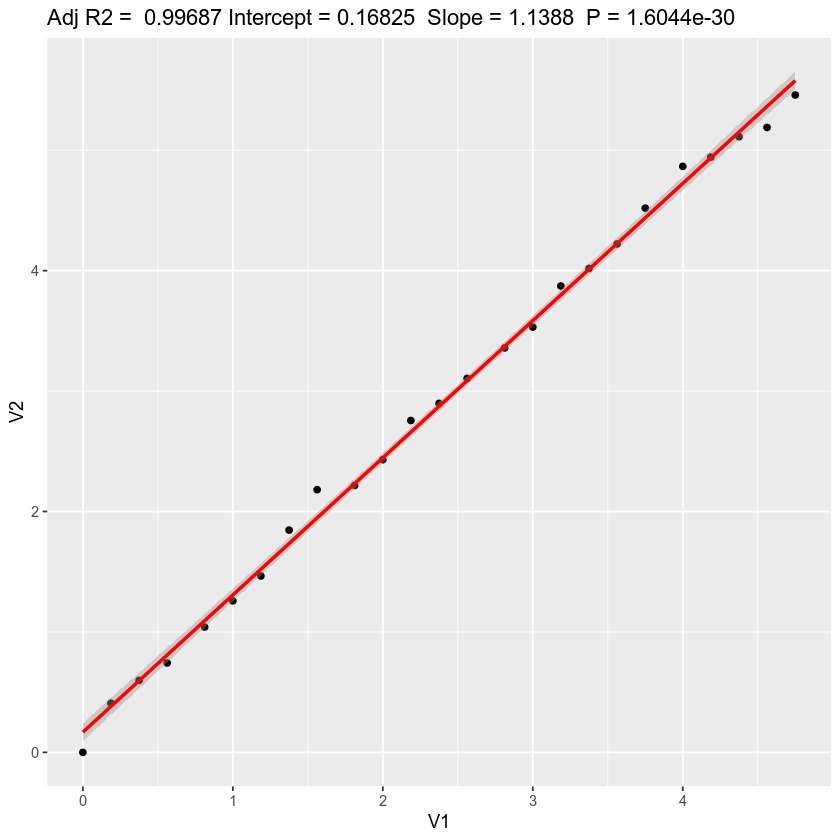

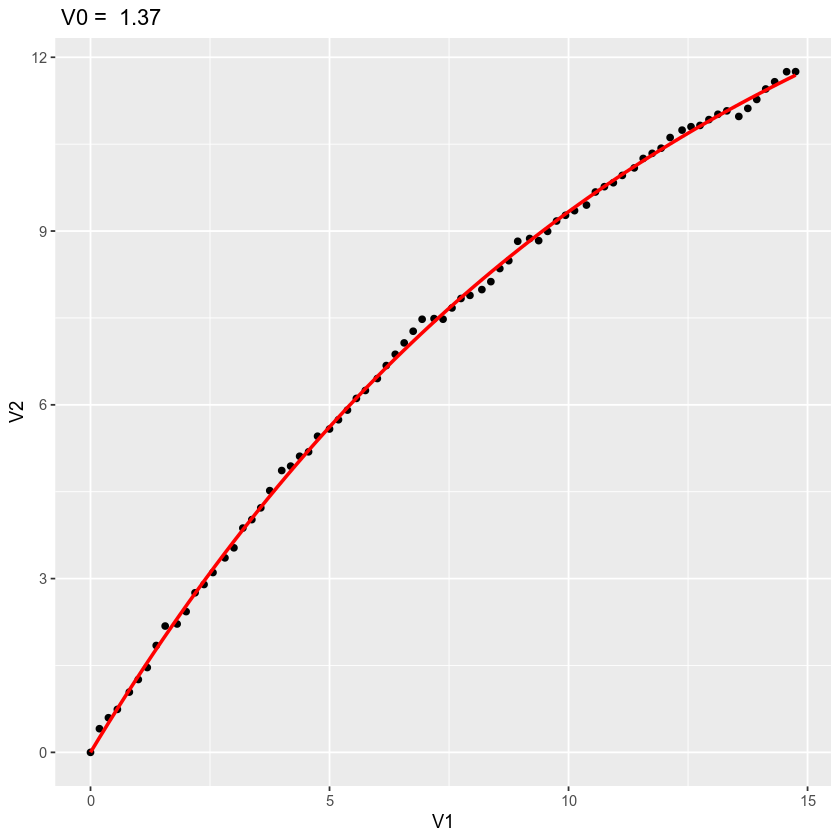

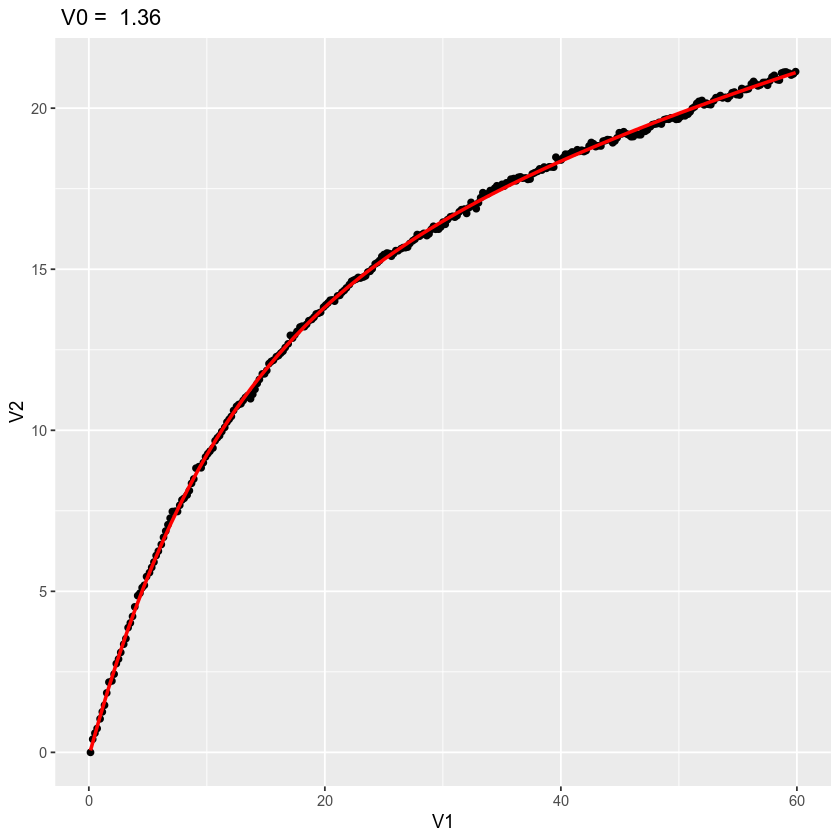

In [36]:
dot_data <- read.table("data/16.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 140
enzyme_start = 225
end_enzyme = 520

#Approximations
start_linear = 3
end_linear = 5
start_exp = start_linear
end_exp = 18
end_double_exp = 63
# ======================================================================
INDEX = 16

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 17 experimental point (17-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr1200nM)

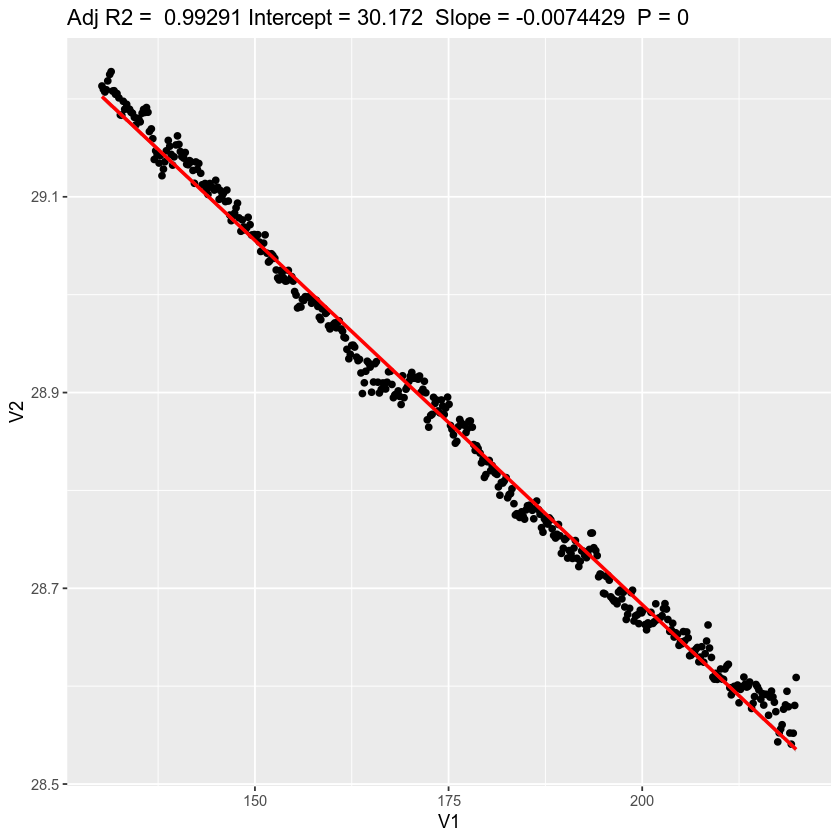

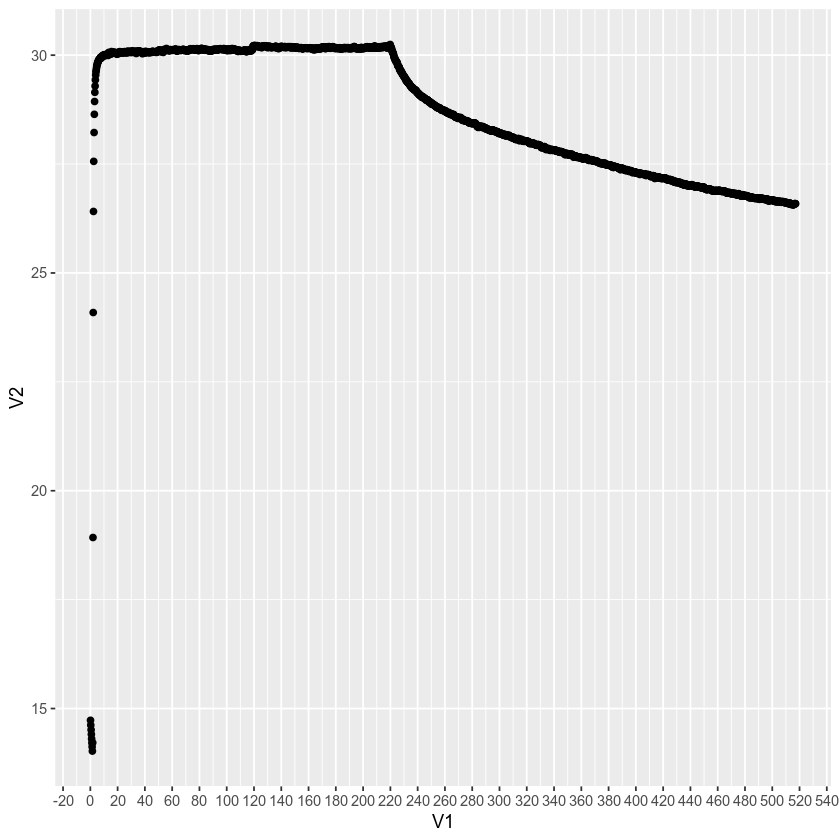

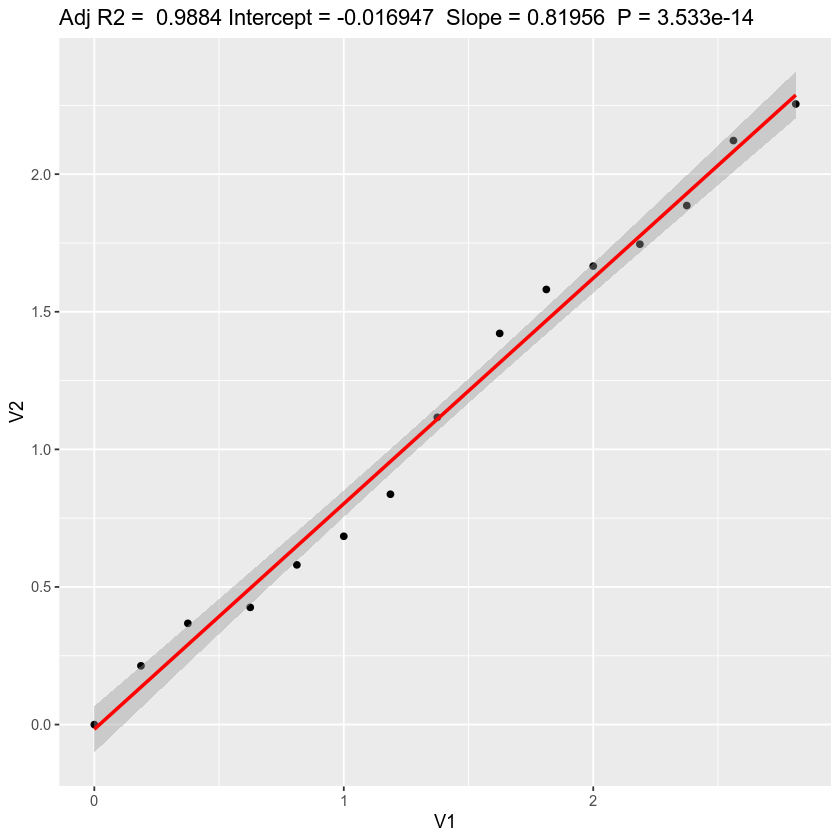

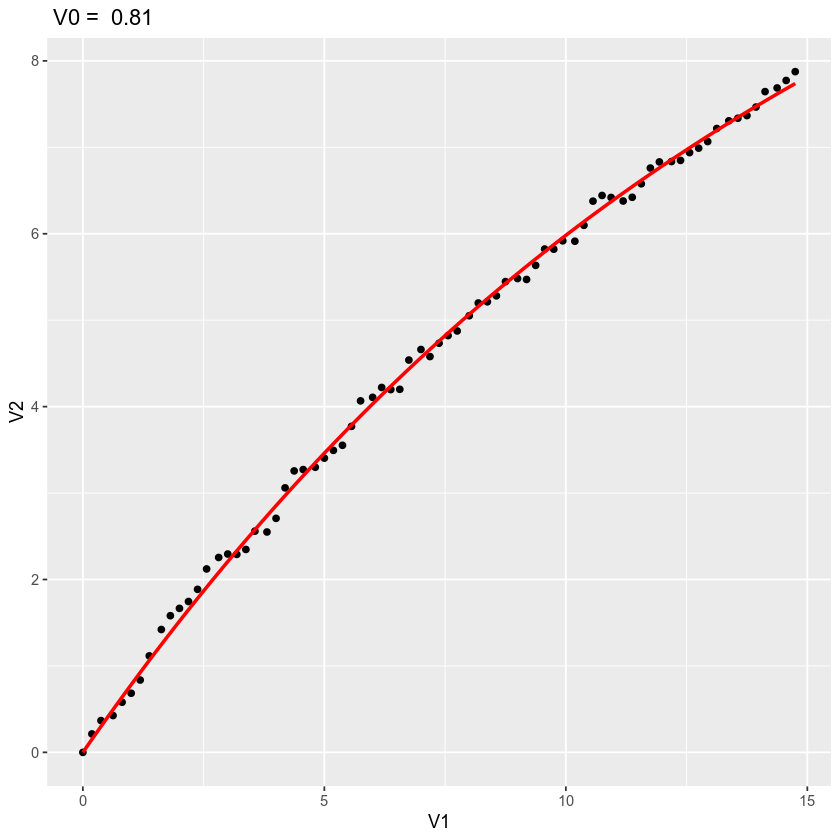

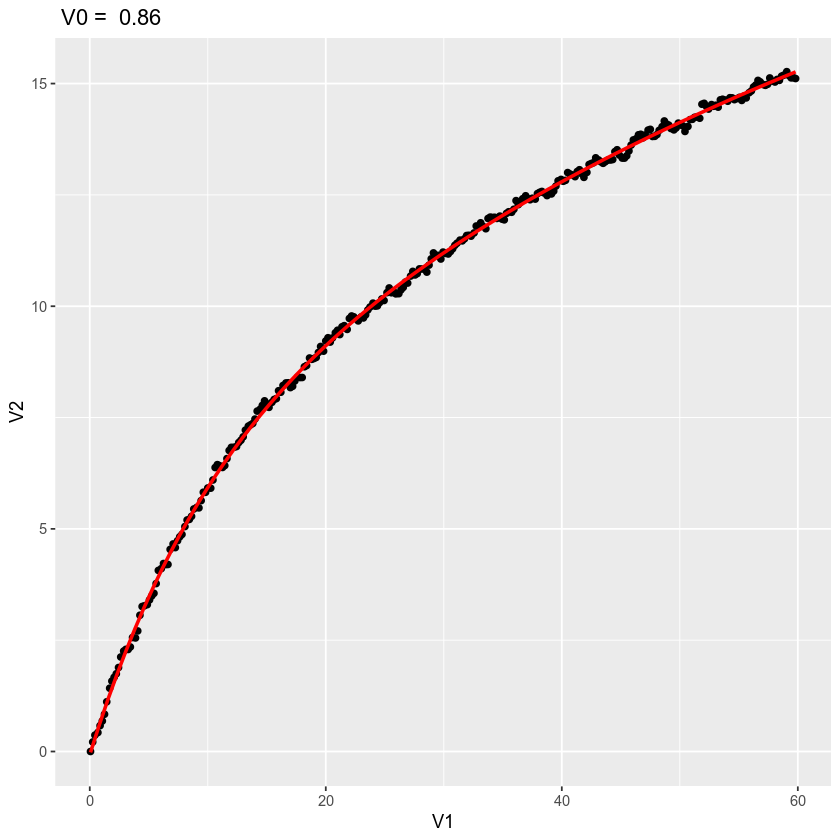

In [37]:
dot_data <- read.table("data/17.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 130
enzyme_start = 220
end_enzyme = 520

#Approximations
start_linear = 1
end_linear = 3
start_exp = start_linear
end_exp = 16
end_double_exp = 61
# ======================================================================
INDEX = 17

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 18 experimental point (18-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr1500nM)

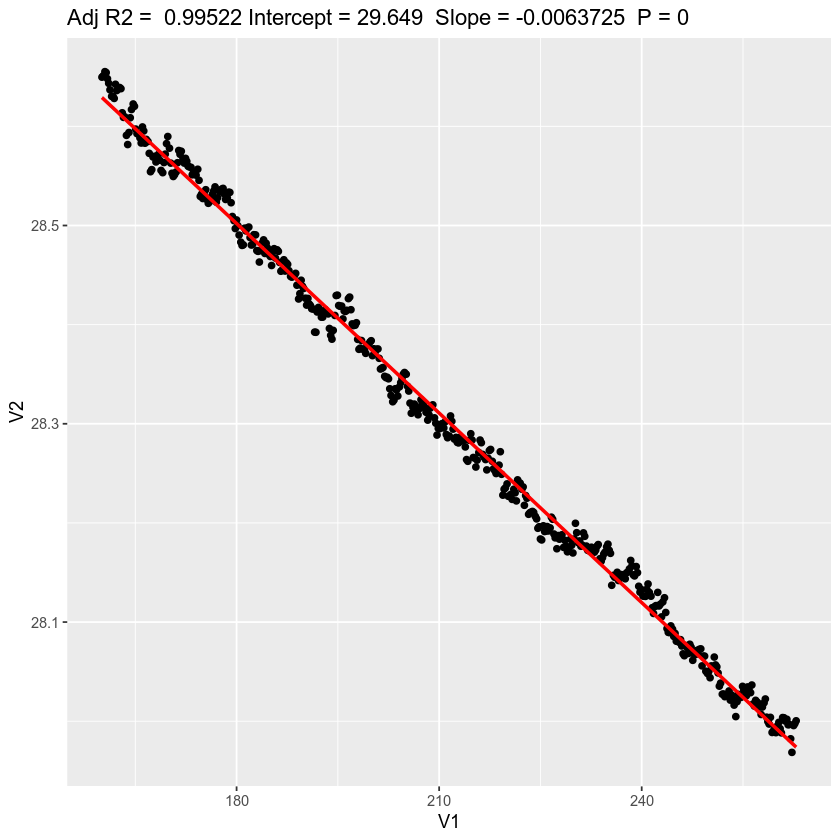

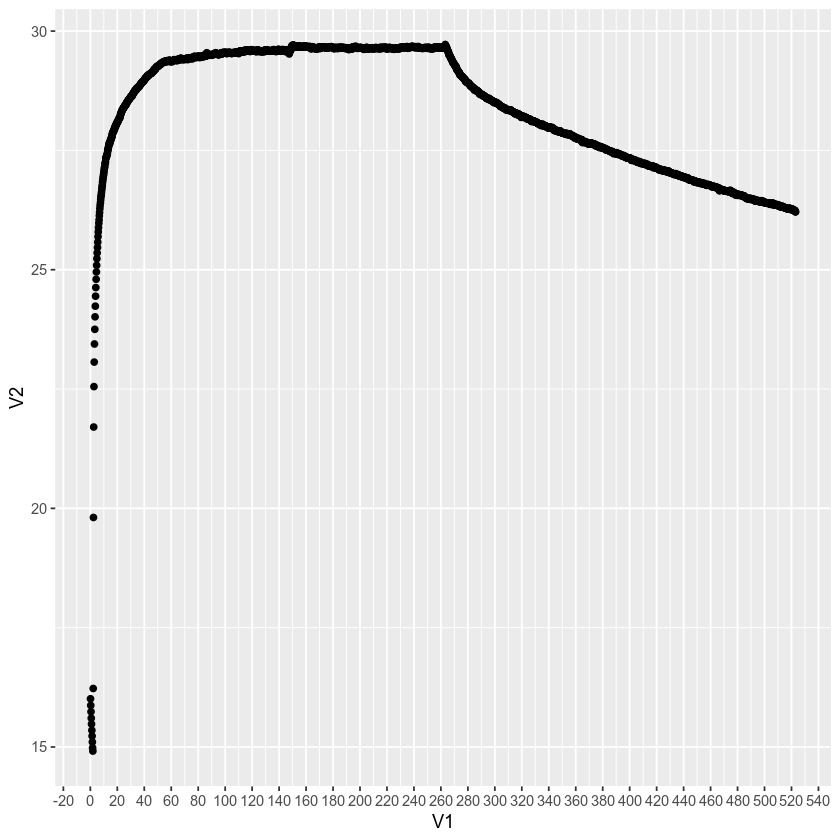

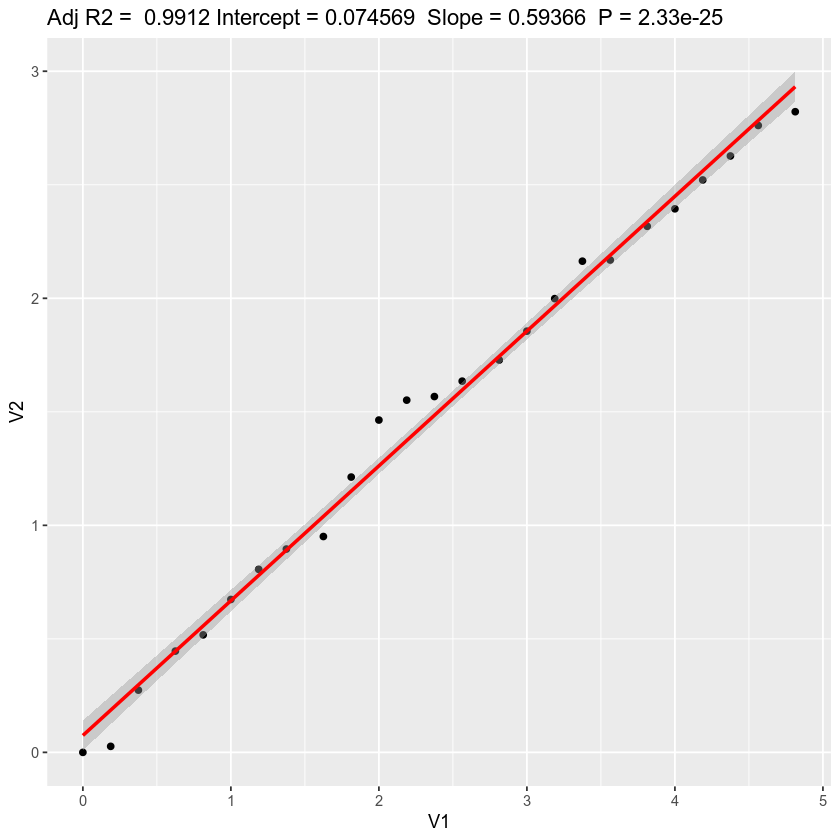

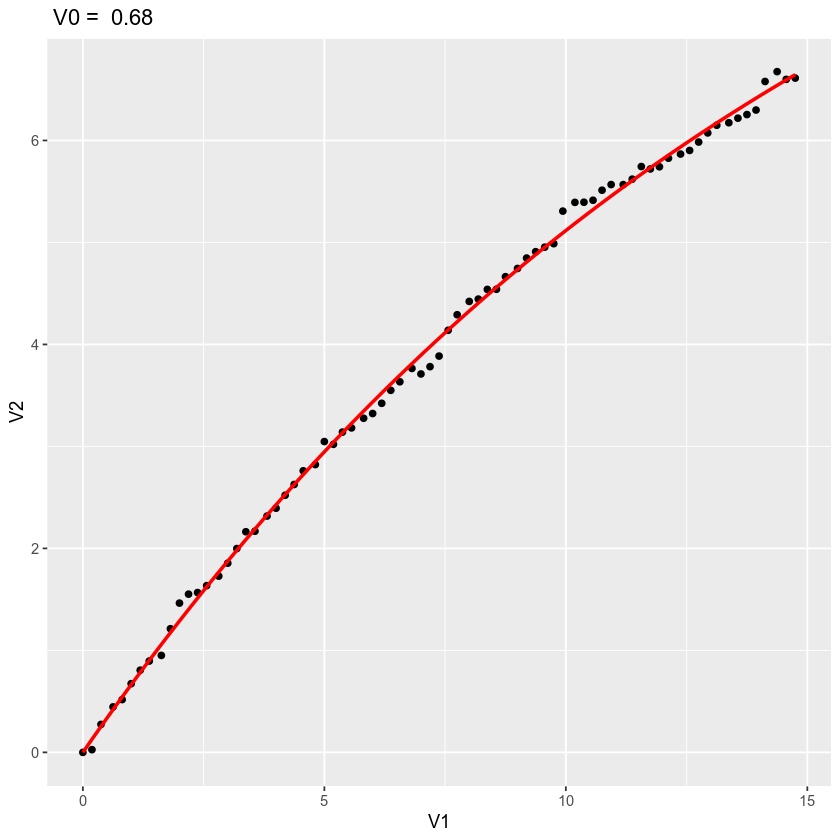

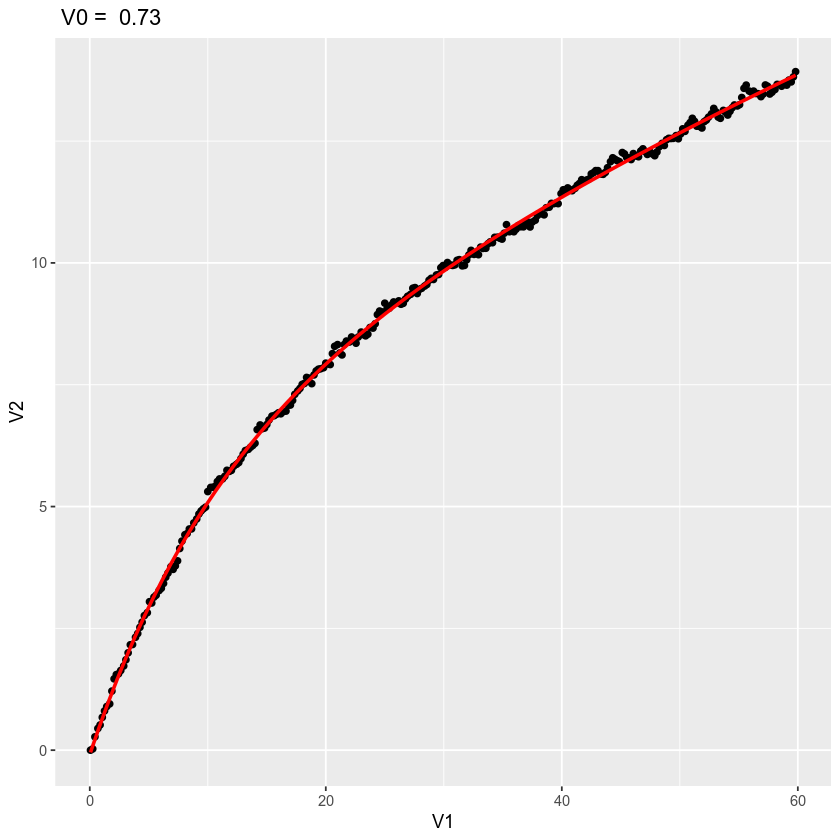

In [38]:
dot_data <- read.table("data/18.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 160
enzyme_start = 263
end_enzyme = 520

#Approximations
start_linear = 1
end_linear = 5
start_exp = start_linear
end_exp = 16
end_double_exp = 61
# ======================================================================
INDEX = 18

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 19 experimental point (19-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr1800nM)

SUBBORN first points before double exp approx00
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: singular convergence (7)”

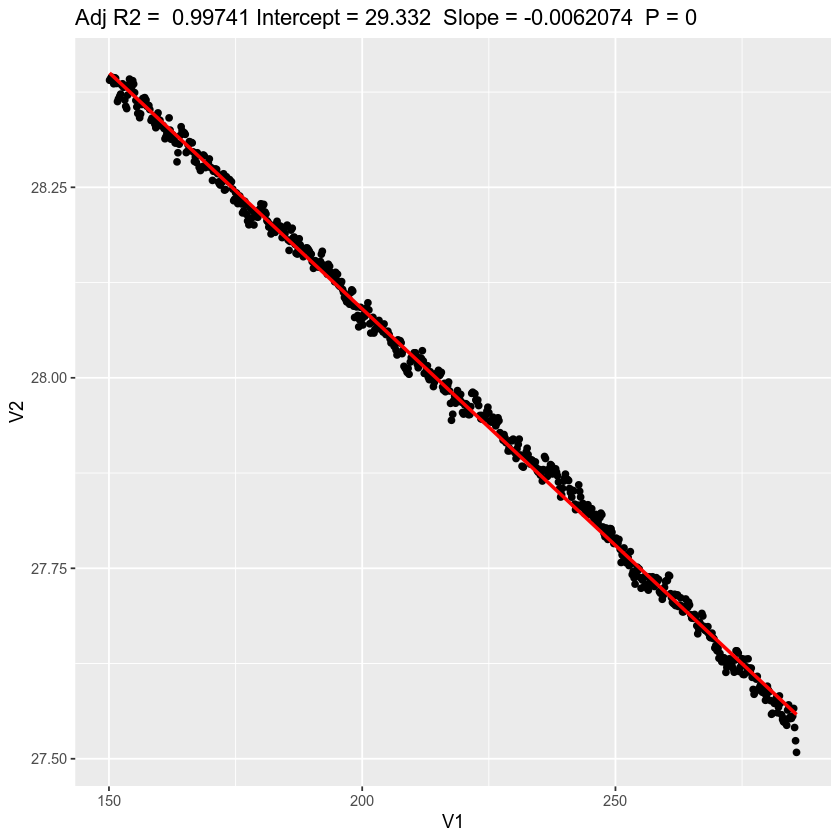

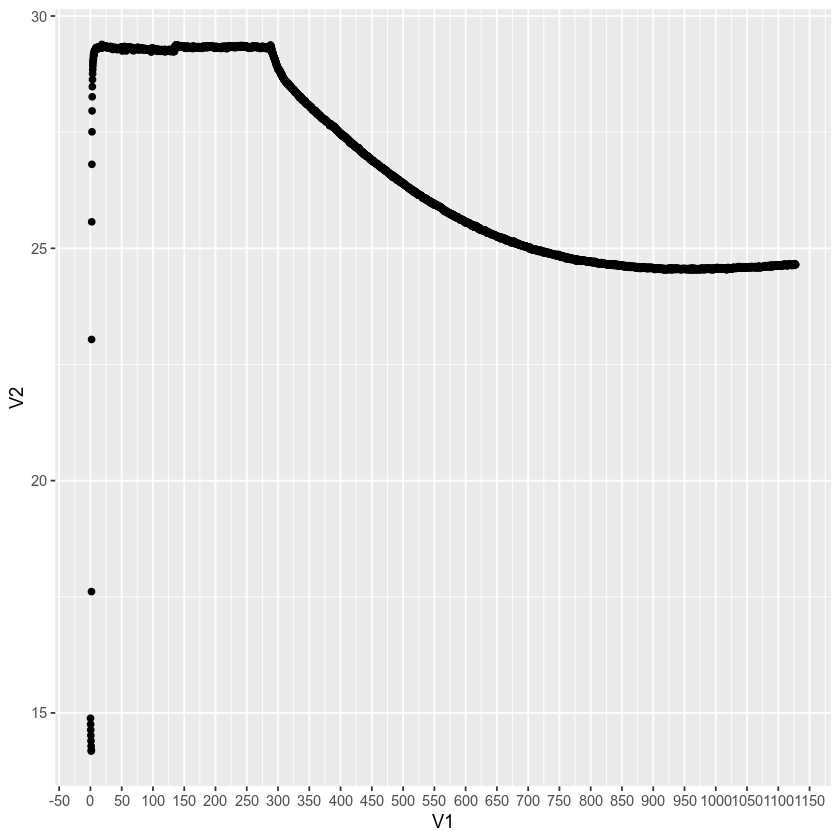

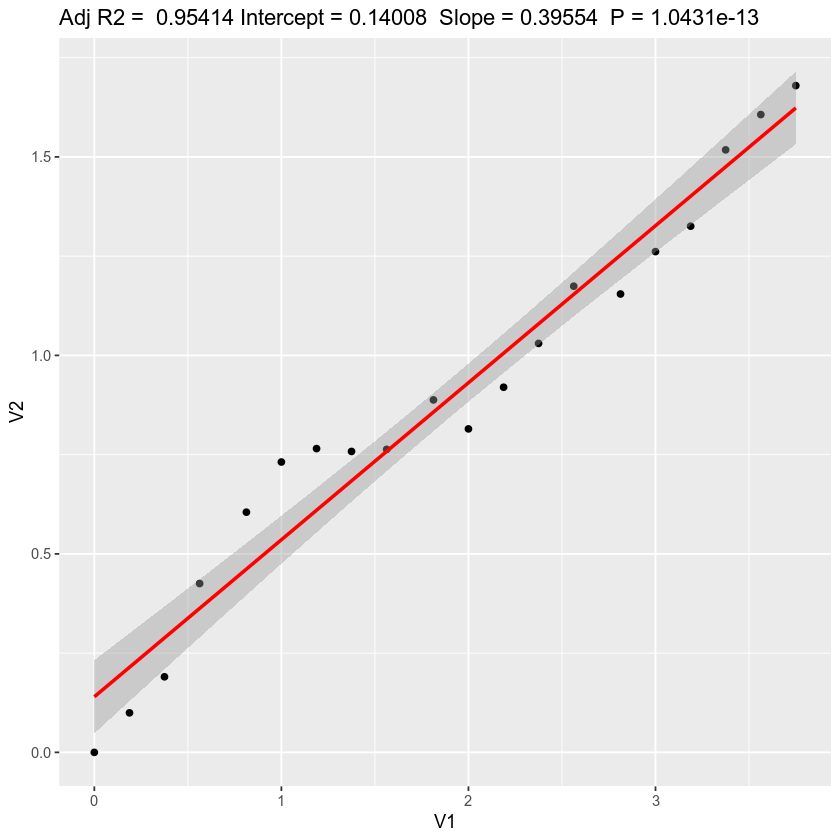

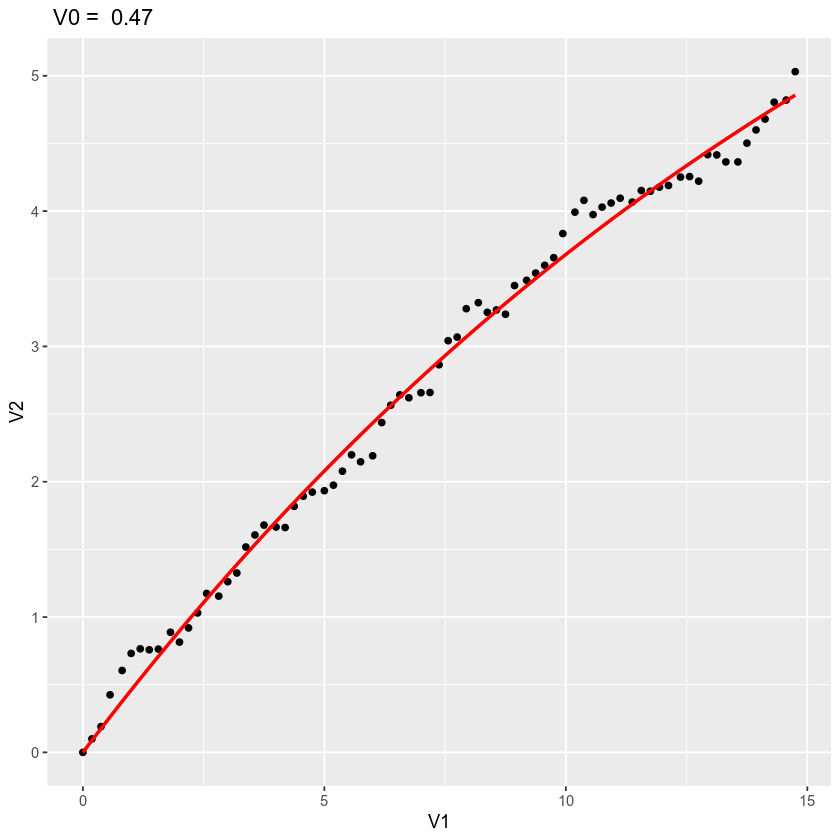

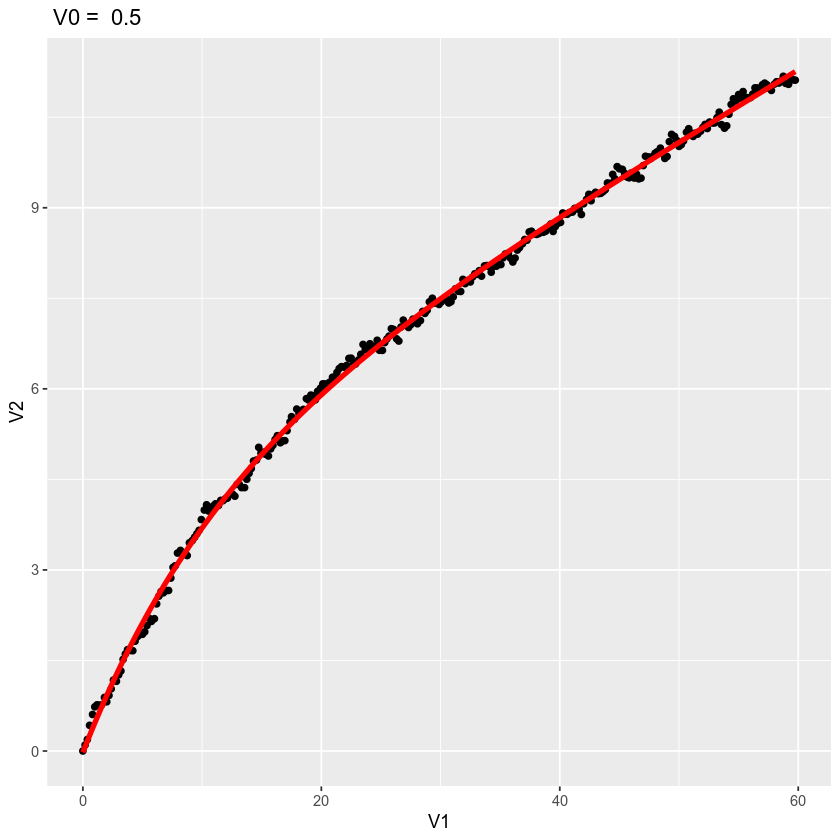

In [39]:
dot_data <- read.table("data/19.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 150
enzyme_start = 286
end_enzyme = 900

#Approximations
start_linear = 3.5
end_linear = 4
start_exp = start_linear
end_exp = 18.5
end_double_exp = 63.5
# ======================================================================
INDEX = 19

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp, STUBBORN=T)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

Poor convergence archieved for double exponent approximation since data is too close to a straight line. Using parameters from not converged approximation with least square distance from data.

## 20 experimental point (20-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr2100nM)

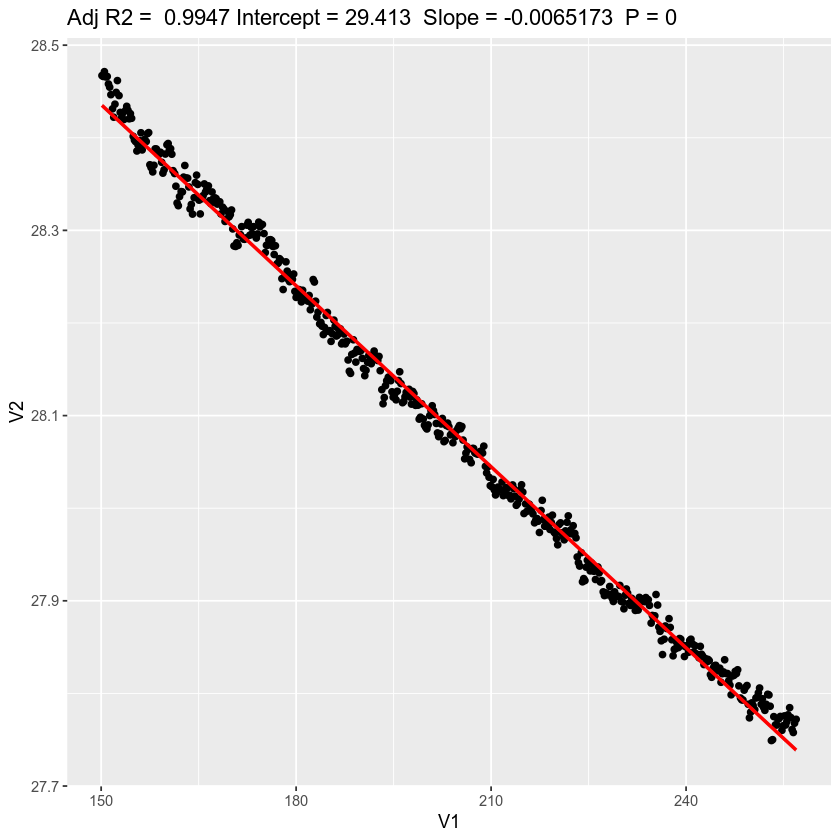

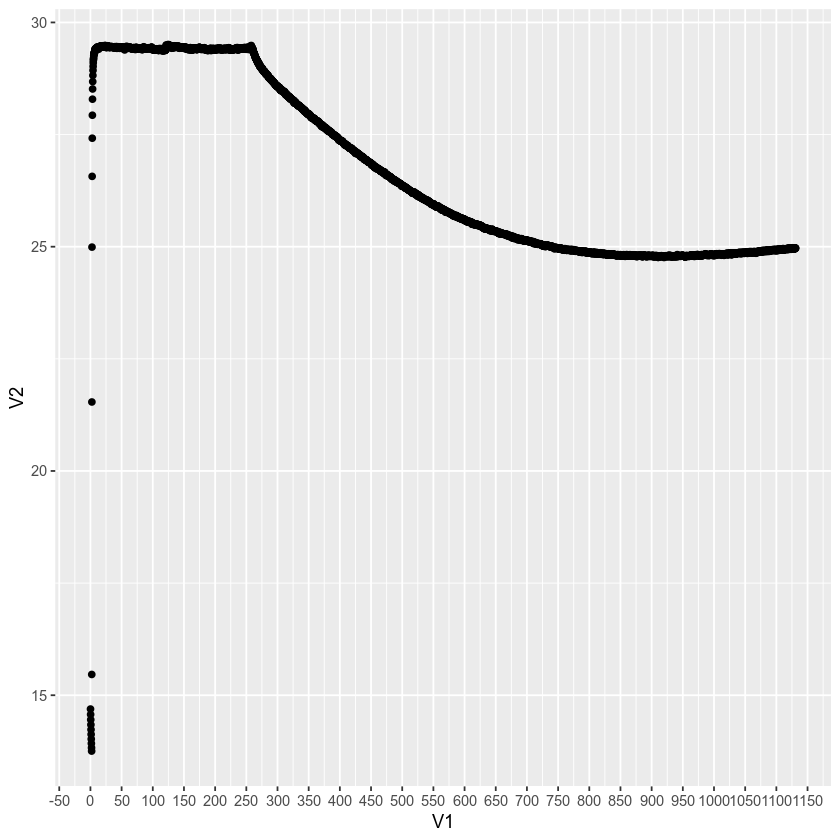

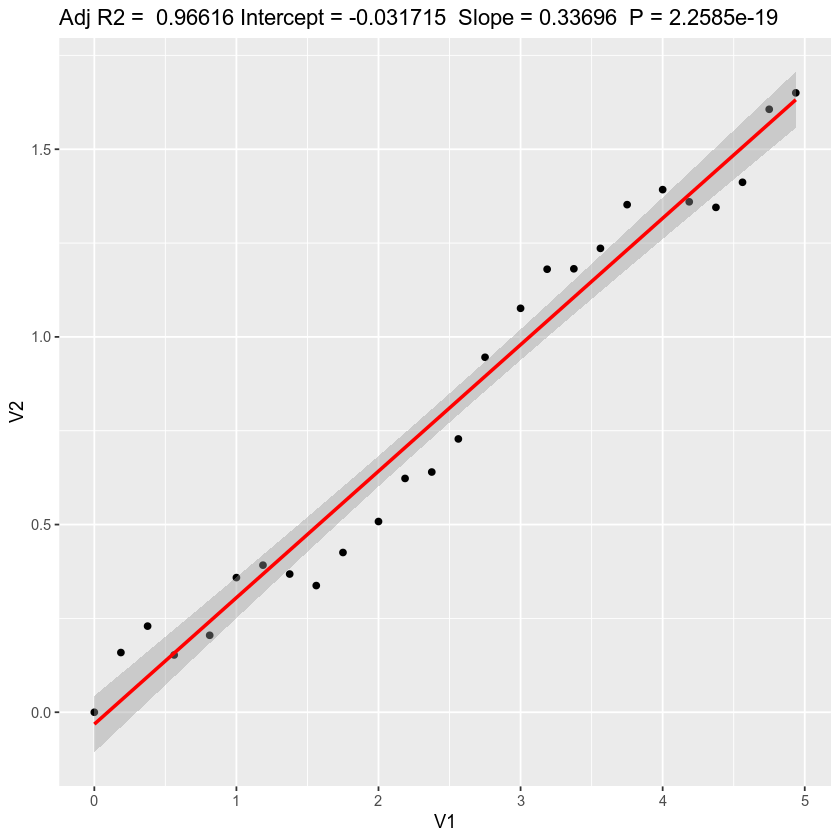

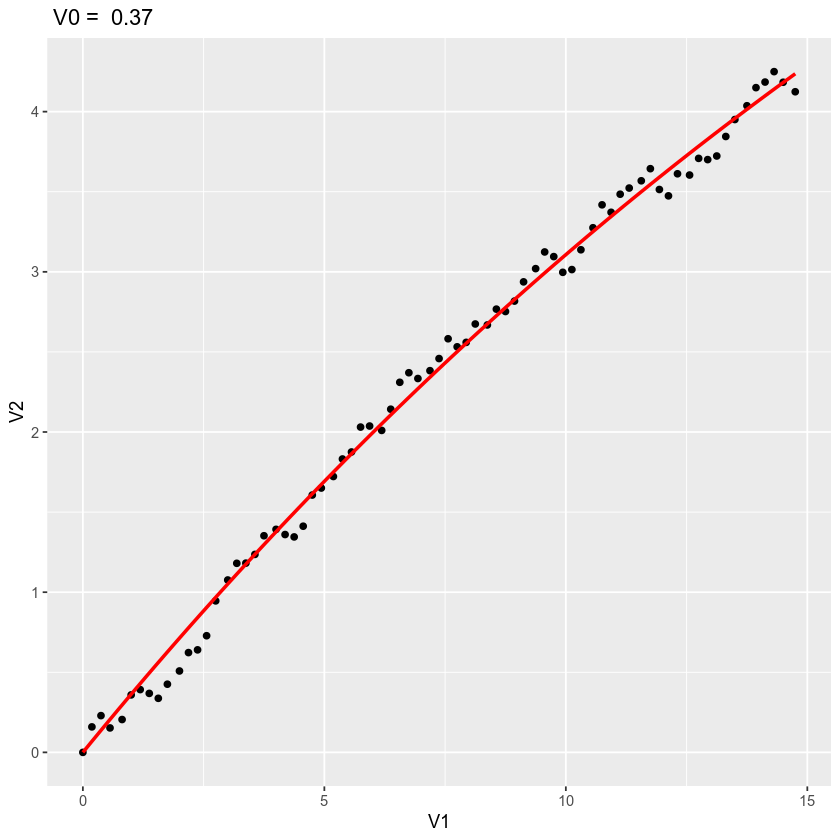

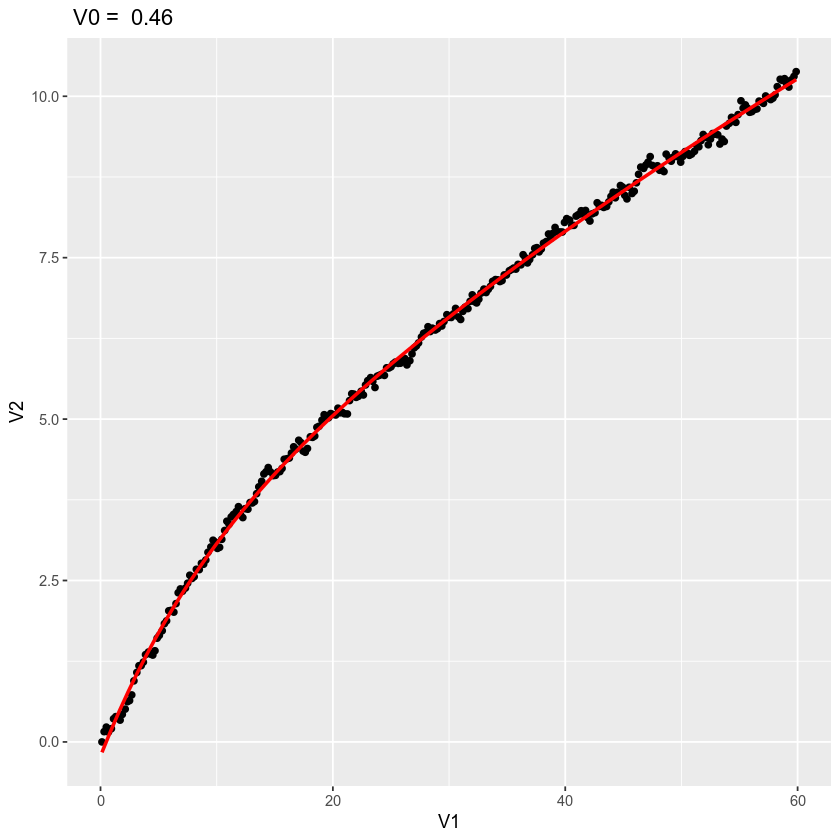

In [40]:
dot_data <- read.table("data/20.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 150
enzyme_start = 257
end_enzyme = 900

#Approximations
start_linear = 1
end_linear = 5
start_exp = start_linear
end_exp = 16
end_double_exp = 61
# ======================================================================
INDEX = 20

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

## 21 experimental point (21-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr3000nM)

SUBBORN first points before double exp approx00
Warning message in nls(V2 ~ y0 + A1 * (1 - exp(-V1/t1)) + A2 * (1 - exp(-V1/t2)), :
“Convergence failure: singular convergence (7)”

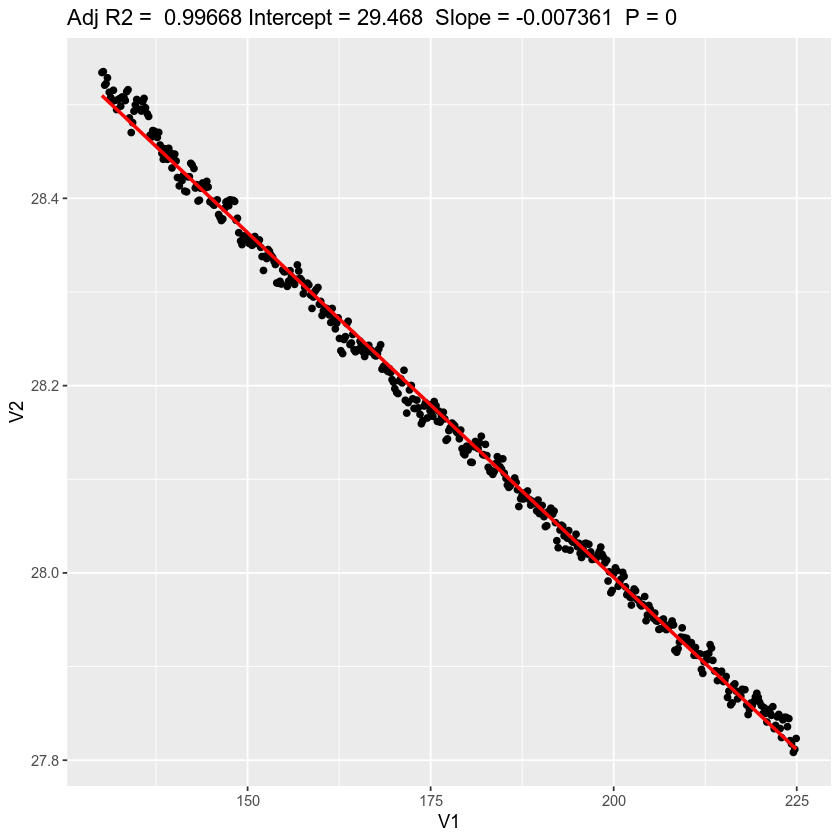

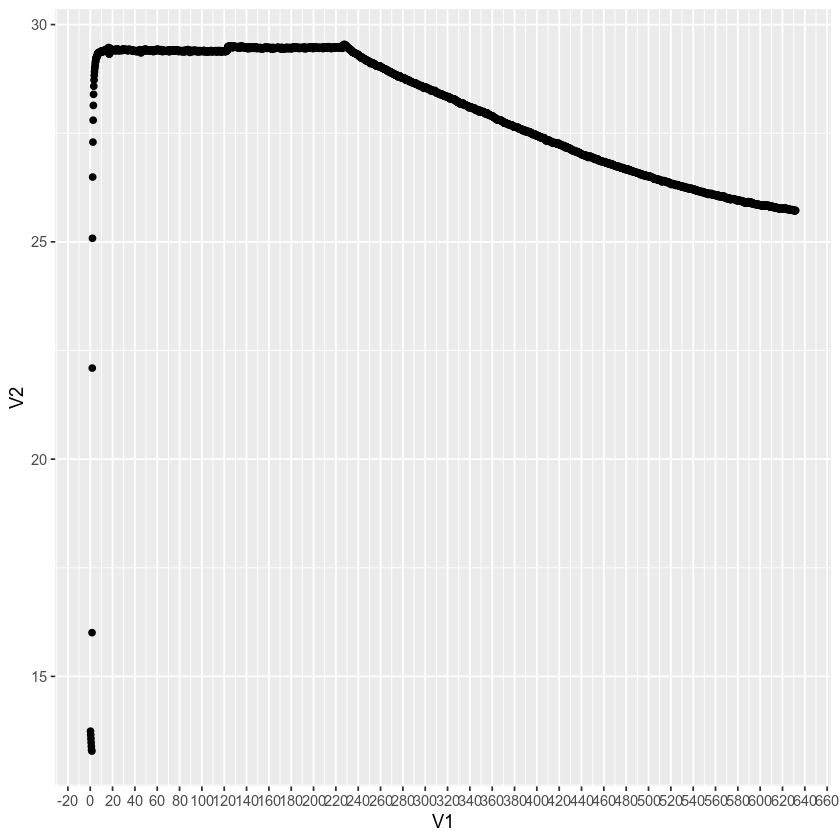

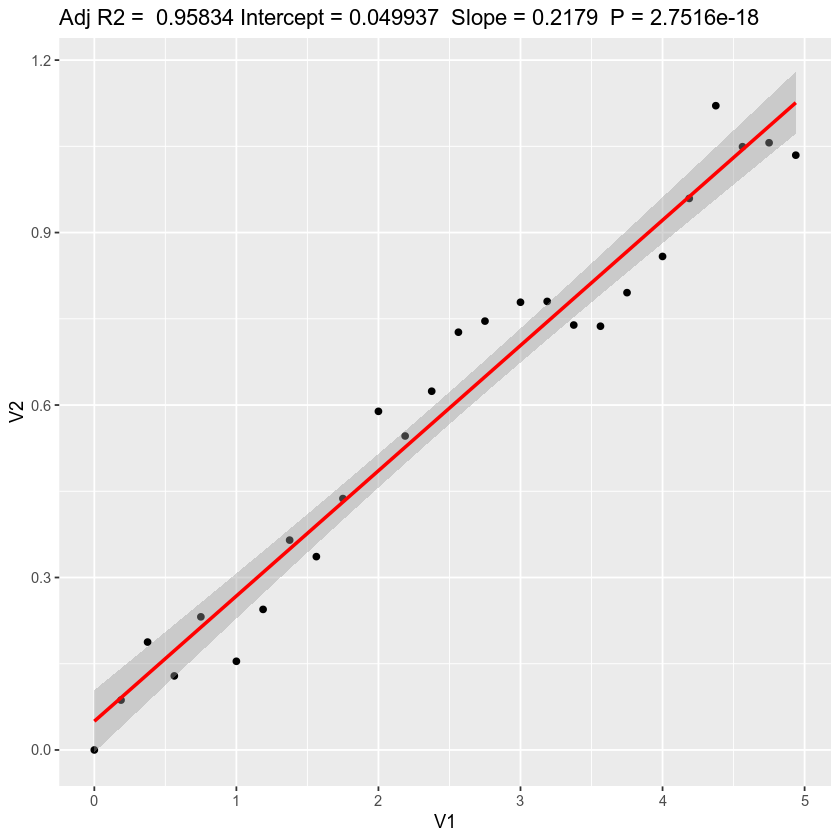

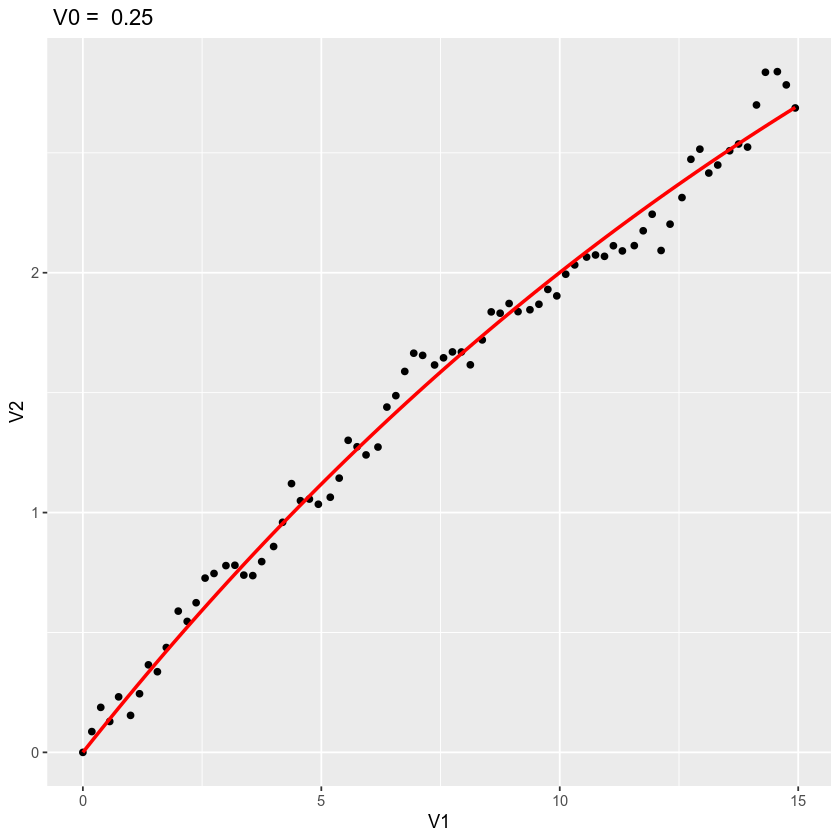

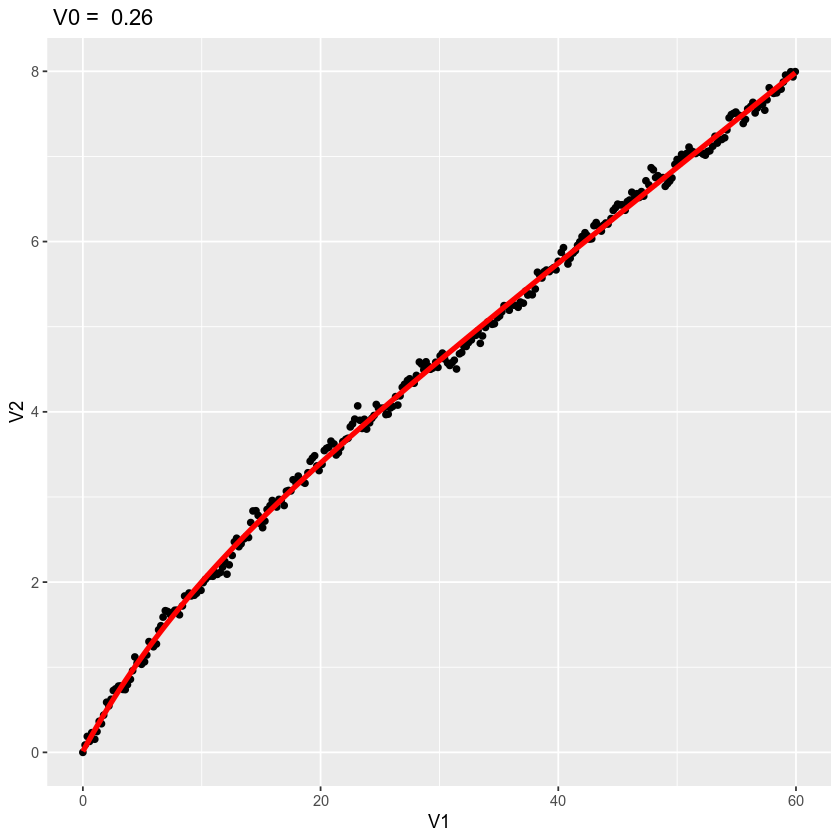

In [41]:
dot_data <- read.table("data/21.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 130
enzyme_start = 225
end_enzyme = 900

#Approximations
start_linear = 2.9
end_linear = 5
start_exp = start_linear
end_exp = 17.9
end_double_exp = 62.9
# ======================================================================
INDEX = 21

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp, STUBBORN=T)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

Poor convergence archieved for double exponent approximation since data is too close to a straight line. 
Using parameters from not converged approximation with least square distance from data.

## 22 experimental point (22-0S(IE)-FCii1mM_hem2uM_AA100uM1ul_IE11ulNapr5000nM)

SUBBORN first points before double exp approx00


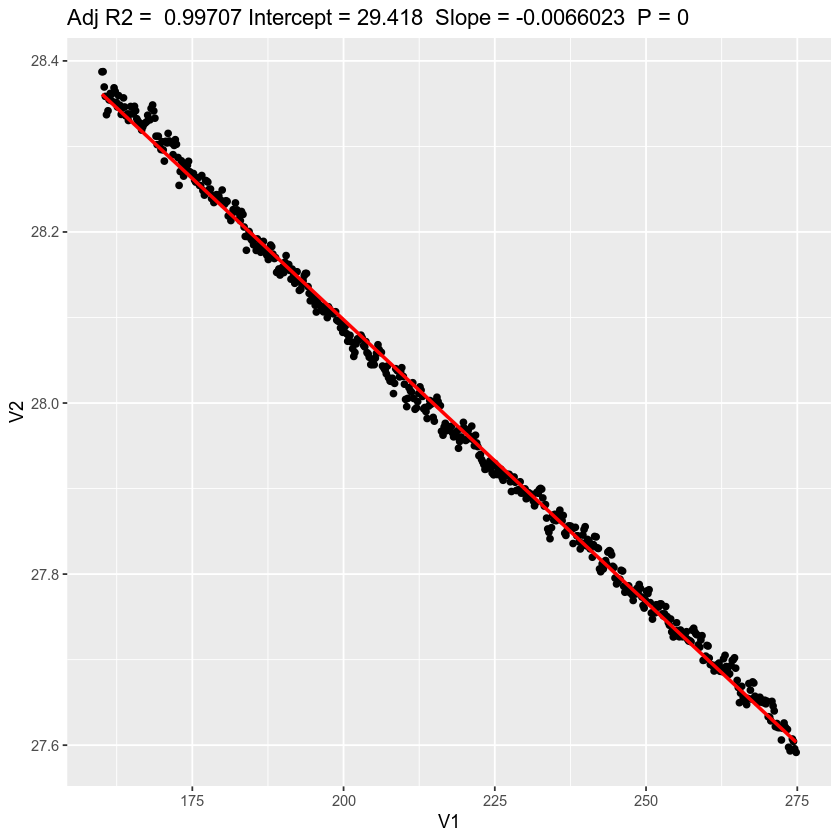

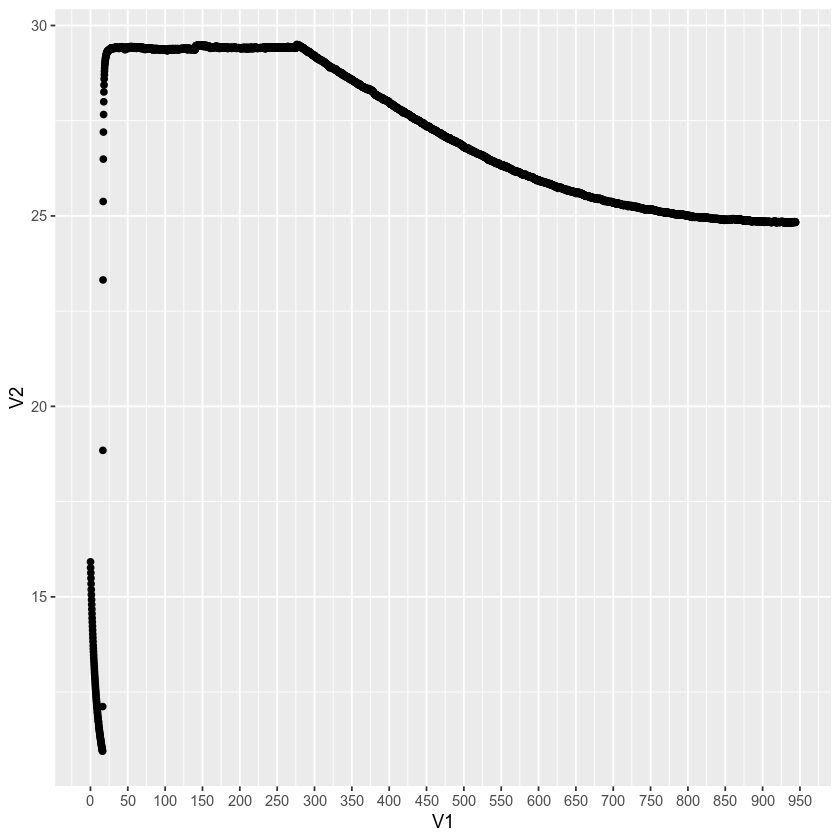

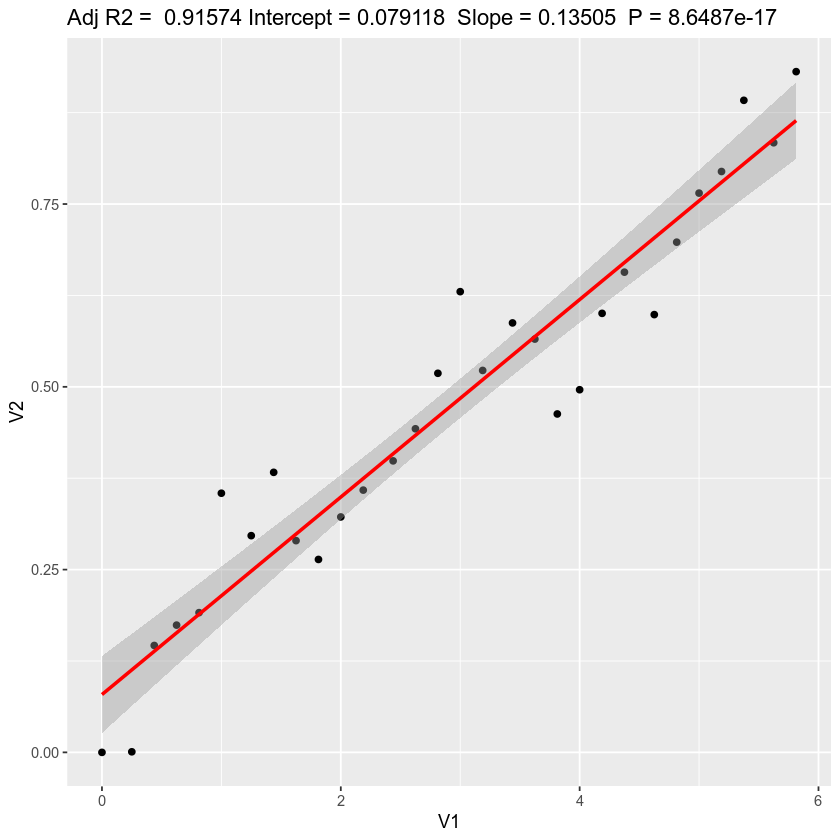

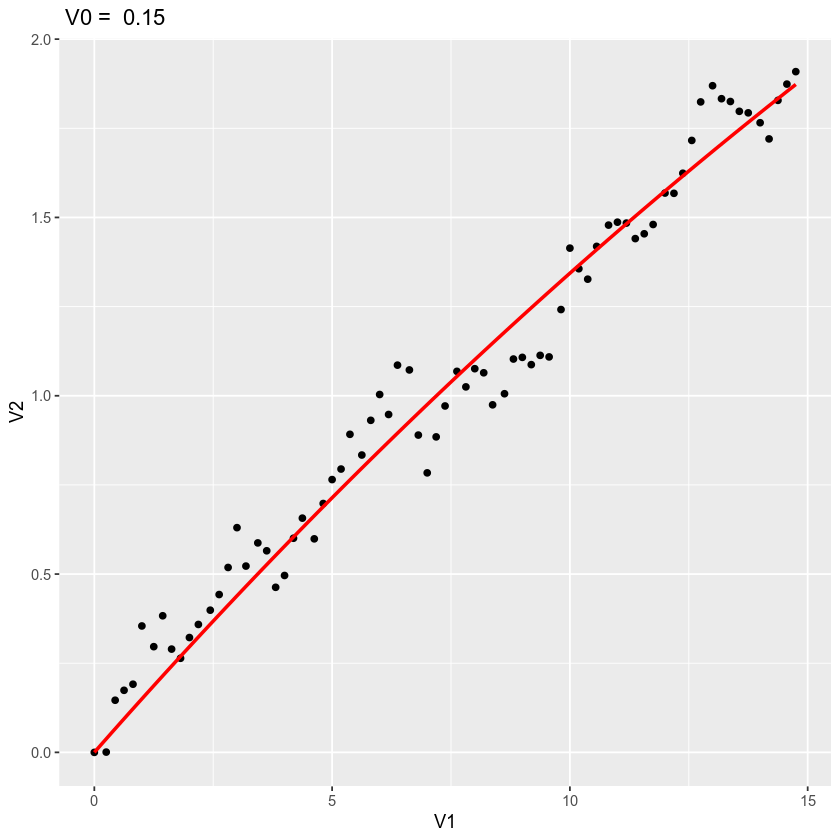

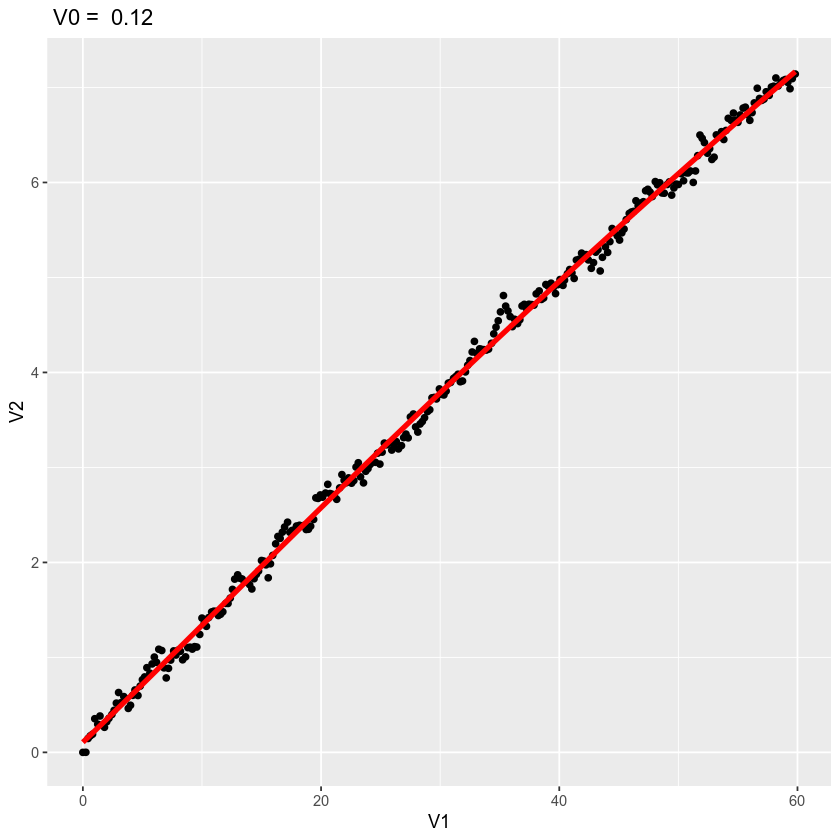

In [42]:
dot_data <- read.table("data/22.DAT", dec = ",")


# =========================== RANGES ===================================
#The whole graph
linear_start = 160
enzyme_start = 275
end_enzyme = 900

#Approximations
start_linear = 10
end_linear = 6
start_exp = start_linear
end_exp = 25
end_double_exp = 70
# ======================================================================
INDEX = 22

dot <- allPlotter(dot_data, linear_start, enzyme_start, end_enzyme,
                        start_linear, end_linear, start_exp, end_exp, end_double_exp, STUBBORN=T)
dot$non_enz_regression_PLOT
dot$whole_normalized_PLOT
dot$approx_linear_PLOT
dot$exponentials$approx_exp_PLOT
dot$exponentials$approx_double_exp_PLOT

exp_out <- unname(dot$exponentials$output_exp)
doub_exp_out <- unname(dot$exponentials$output_doub_exp[-1])
out <- c(dot$nEnz_start, dot$nEnz_end, dot$Enz_start, dot$approx_linear_slope,exp_out, doub_exp_out)

final_table[INDEX, ] <- out #add parameters to main table

enz_curves[[paste("time_",INDEX, sep="")]] <-
dot$Enz_data_part$V1[1:CURVE_END] #add enzyme curves to combined table
enz_curves[var_names[[INDEX]]] <- dot$Enz_data_part$V2[1:CURVE_END]

Poor convergence archieved for double exponent approximation since data is too close to a straight line. 
Using parameters from not converged approximation with least square distance from data.

In [43]:
write.csv(enz_curves, file = "All_enzyme_curves.csv", sep=",", row.names=FALSE)
write.csv(final_table, file = "final_params_table.csv", sep=",",row.names=FALSE, col.names=FALSE)

Warning message in write.csv(enz_curves, file = "All_enzyme_curves.csv", sep = ",", :
“attempt to set 'sep' ignored”Warning message in write.csv(final_table, file = "final_params_table.csv", sep = ",", :
“attempt to set 'col.names' ignored”Warning message in write.csv(final_table, file = "final_params_table.csv", sep = ",", :
“attempt to set 'sep' ignored”